In [1]:
%run -i model.ipynb

CPU times: user 956 ms, sys: 124 ms, total: 1.08 s
Wall time: 927 ms


100%|██████████| 100/100 [00:00<00:00, 1029.63it/s]


## Recovering conditional density with FFJORD

# All needed imports

In [2]:
device = torch.device('cuda:0')

In [3]:
import sys
import torch
import torch.optim as optim

sys.path.append('./ffjord/')
import ffjord.lib.utils as utils
from ffjord.lib.visualize_flow import visualize_transform
import ffjord.lib.layers.odefunc as odefunc
from ffjord.train_misc import standard_normal_logprob
from ffjord.train_misc import count_nfe, count_parameters, count_total_time
from ffjord.train_misc import add_spectral_norm, spectral_norm_power_iteration
from ffjord.train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
from ffjord.train_misc import build_model_tabular
import lib.layers as layers

In [4]:
SOLVERS = ["dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams']

print(odefunc.NONLINEARITIES)

{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


In [5]:
def set_cnf_options(model, solver, rademacher, residual, atol=1e-5, rtol=1e-5):

    def _set(module):
        if isinstance(module, layers.CNF):
            # Set training settings
            module.solver = solver
            module.atol = atol
            module.rtol = rtol

            # If using fixed-grid adams, restrict order to not be too high.
            if solver in ['fixed_adams', 'explicit_adams']:
                module.solver_options['max_order'] = 4

        if isinstance(module, layers.ODEfunc):
            module.rademacher = rademacher
            module.residual = residual

    model.apply(_set)
    
# layer_type - ["ignore", "concat", "concat_v2", "squash", "concatsquash", "concatcoord", "hyper", "blend"]
def build_model_tabular(dims=2,
                        layer_type='concatsquash', 
                        nonlinearity='relu', 
                        residual=False, 
                        rademacher=False,
                        train_T=True,
                        solver='dopri5',
                        time_length=0.1,
                        divergence_fn='brute_force', # ["brute_force", "approximate"]
                        hidden_dims=(32, 32), 
                        num_blocks=1, batch_norm=False, 
                        bn_lag=0, regularization_fns=None):


    def build_cnf():
        diffeq = layers.ODEnet(
            hidden_dims=hidden_dims,
            input_shape=(dims,),
            strides=None,
            conv=False,
            layer_type=layer_type,
            nonlinearity=nonlinearity,
        )
        odefunc = layers.ODEfunc(
            diffeq=diffeq,
            divergence_fn=divergence_fn,
            residual=residual,
            rademacher=rademacher,
        )
        cnf = layers.CNF(
            odefunc=odefunc,
            T=time_length,
            train_T=train_T,
            regularization_fns=regularization_fns,
            solver=solver,
        )
        return cnf

    chain = [build_cnf() for _ in range(num_blocks)]
    if batch_norm:
        bn_layers = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag) for _ in range(num_blocks)]
        bn_chain = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag)]
        for a, b in zip(chain, bn_layers):
            bn_chain.append(a)
            bn_chain.append(b)
        chain = bn_chain
    model = layers.SequentialFlow(chain)

    set_cnf_options(model, solver, rademacher, residual)

    return model


In [6]:
import ffjord.lib.layers.wrappers.cnf_regularization as reg_lib
import six

REGULARIZATION_FNS = {
    "l1int": reg_lib.l1_regularzation_fn,
    "l2int": reg_lib.l2_regularzation_fn,
    "dl2int": reg_lib.directional_l2_regularization_fn,
    "JFrobint": reg_lib.jacobian_frobenius_regularization_fn,
    "JdiagFrobint": reg_lib.jacobian_diag_frobenius_regularization_fn,
    "JoffdiagFrobint": reg_lib.jacobian_offdiag_frobenius_regularization_fn,
}

def create_regularization_fns(regs={'l1int': 1., 'JFrobint': 1.}):
    regularization_fns = []
    regularization_coeffs = []

    for arg_key, reg_fn in six.iteritems(REGULARIZATION_FNS):
        if arg_key in regs:
            regularization_fns.append(reg_fn)
            regularization_coeffs.append(regs[arg_key])

    regularization_fns = tuple(regularization_fns)
    regularization_coeffs = tuple(regularization_coeffs)
    return regularization_fns, regularization_coeffs


def get_regularization(model, regularization_coeffs):
    if len(regularization_coeffs) == 0:
        return None

    acc_reg_states = tuple([0.] * len(regularization_coeffs))
    for module in model.modules():
        if isinstance(module, layers.CNF):
            acc_reg_states = tuple(acc + reg for acc, reg in zip(acc_reg_states, module.get_regularization_states()))
    return acc_reg_states

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
def get_transforms(model):

    def sample_fn(z, logpz=None):
        if logpz is not None:
            return model(z, logpz, reverse=True)
        else:
            return model(z, reverse=True)

    def density_fn(x, logpx=None):
        if logpx is not None:
            return model(x, logpx, reverse=False)
        else:
            return model(x, reverse=False)

    return sample_fn, density_fn

In [31]:
import math

def standard_normal_logprob(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([torch.zeros(len(data)).to(data.device), 
                            data[:, 1],
                            data[:, 2]], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([1., 1., 1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas


def compute_loss(model, data, batch_size=None):
    # load data
    #x = sample_data(data, batch_size=batch_size)
    #x = torch.from_numpy(x).float().to(device)
    # zero = torch.stack([torch.zeros(data.shape[0]).to(data.device), data[:, 1], data[:, 2]], dim=1).float()
    zero = torch.zeros(data.shape[0], 1).to(data.device)
    # print(zero.shape)
    # transform to z
    #zero[:, 2] = data[:, 2].detach()
    z, delta_logp = model(data, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z, data).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

# Sampling train dataset

In [32]:
n_samples = 1000
y_sampler = YModel()
mu_range = (-30, 30)
mus = ((mu_range[0] - mu_range[1]) * (torch.rand(n_samples)) + mu_range[1]).to(device)
xs = y_sampler.x_dist.sample([n_samples]).to(device)
y_sampler.make_condition_sample({'mu': mus, 'X':xs})
data = y_sampler.condition_sample().detach().to(device)
data = torch.stack([data, mus, xs]).detach().t().to(device)

# Optimization is not very stable so should be optimized...

# Defining FFJORD model

In [33]:
regularization_fns = None
#regularization_fns, regularization_coeffs = create_regularization_fns()
model = build_model_tabular(dims=3, 
                            num_blocks=1, 
                            hidden_dims=(32, 32), bn_lag=0.1,
                            regularization_fns=regularization_fns).to(device)

In [34]:
from torch.nn.utils import clip_grad_norm
from tqdm import tqdm

In [35]:
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.5)
nfef_meter = utils.RunningAverageMeter(0.5)
nfeb_meter = utils.RunningAverageMeter(0.5)

In [36]:
model.train();
for i in tqdm(range(20)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    if loss.item() < 4:
        break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    
    print(loss_meter.avg, nfe_total)

  5%|▌         | 1/20 [00:00<00:04,  4.31it/s]

171.71446228027344 29.0


 10%|█         | 2/20 [00:00<00:04,  3.99it/s]

170.08067321777344 35.0


 15%|█▌        | 3/20 [00:00<00:04,  3.79it/s]

163.906494140625 35.0


 20%|██        | 4/20 [00:01<00:04,  3.34it/s]

149.3377227783203 47.0


 25%|██▌       | 5/20 [00:01<00:05,  2.83it/s]

122.49655151367188 59.0


 30%|███       | 6/20 [00:02<00:06,  2.21it/s]

84.53340721130371 95.0


 35%|███▌      | 7/20 [00:03<00:09,  1.38it/s]

48.00978422164917 179.0


 40%|████      | 8/20 [00:05<00:14,  1.18s/it]

31.62316584587097 287.0


 45%|████▌     | 9/20 [00:09<00:19,  1.76s/it]

30.129032492637634 401.0


 50%|█████     | 10/20 [00:12<00:24,  2.41s/it]

30.856488406658173 503.0


 55%|█████▌    | 11/20 [00:17<00:27,  3.07s/it]

31.090164750814438 575.0


 60%|██████    | 12/20 [00:22<00:27,  3.49s/it]

29.427293106913567 563.0


 65%|██████▌   | 13/20 [00:26<00:26,  3.78s/it]

25.591670654714108 563.0


 70%|███████   | 14/20 [00:30<00:23,  3.96s/it]

20.513672661036253 551.0


 75%|███████▌  | 15/20 [00:34<00:19,  3.92s/it]

15.909631645306945 485.0


 80%|████████  | 16/20 [00:38<00:15,  3.94s/it]

13.647518592886627 509.0


 85%|████████▌ | 17/20 [00:42<00:11,  3.78s/it]

12.766635635402054 425.0


 90%|█████████ | 18/20 [00:45<00:07,  3.59s/it]

11.28878961945884 395.0


 95%|█████████▌| 19/20 [00:48<00:03,  3.40s/it]

9.784591133124195 377.0


100%|██████████| 20/20 [00:51<00:00,  3.43s/it]

8.854395833972376 449.0


In [37]:
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.5)
nfef_meter = utils.RunningAverageMeter(0.5)
nfeb_meter = utils.RunningAverageMeter(0.5)

In [39]:
model.train();
for i in tqdm(range(50)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    #if loss.item() < 4:
    #    break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    
    print(loss_meter.avg, nfe_total)


  2%|▏         | 1/50 [00:02<02:20,  2.87s/it]

3.991788219307709 359.0



  4%|▍         | 2/50 [00:05<02:19,  2.91s/it]

3.983018552708054 383.0



  6%|▌         | 3/50 [00:08<02:17,  2.93s/it]

3.9760934886571886 395.0



  8%|▊         | 4/50 [00:11<02:12,  2.89s/it]

3.970543721181011 365.0



 10%|█         | 5/50 [00:14<02:06,  2.82s/it]

3.965443541040945 347.0



 12%|█▏        | 6/50 [00:17<02:05,  2.85s/it]

3.960556352849269 383.0



 14%|█▍        | 7/50 [00:19<02:01,  2.82s/it]

3.9562809888101933 353.0



 16%|█▌        | 8/50 [00:22<01:59,  2.84s/it]

3.9526628466237246 371.0



 18%|█▊        | 9/50 [00:25<01:54,  2.80s/it]

3.9494328007990447 353.0



 20%|██        | 10/50 [00:28<01:50,  2.75s/it]

3.9459439270642562 347.0



 22%|██▏       | 11/50 [00:30<01:45,  2.71s/it]

3.942150282509484 329.0



 24%|██▍       | 12/50 [00:33<01:43,  2.71s/it]

3.9384978650248836 335.0



 26%|██▌       | 13/50 [00:36<01:41,  2.74s/it]

3.935067337663809 353.0



 28%|██▊       | 14/50 [00:38<01:37,  2.72s/it]

3.931422433213313 341.0



 30%|███       | 15/50 [00:41<01:34,  2.69s/it]

3.927459697403471 335.0



 32%|███▏      | 16/50 [00:44<01:31,  2.71s/it]

3.9234216116259297 347.0



 34%|███▍      | 17/50 [00:47<01:29,  2.71s/it]

3.9195916604195933 347.0



 36%|███▌      | 18/50 [00:49<01:25,  2.68s/it]

3.9156095957356145 335.0



 38%|███▊      | 19/50 [00:52<01:22,  2.67s/it]

3.911223887185129 335.0



 40%|████      | 20/50 [00:54<01:18,  2.63s/it]

3.9070959085126082 323.0



 42%|████▏     | 21/50 [00:57<01:15,  2.60s/it]

3.903355598146685 323.0



 44%|████▍     | 22/50 [00:59<01:12,  2.59s/it]

3.8991507290278715 329.0



 46%|████▌     | 23/50 [01:02<01:09,  2.59s/it]

3.894241392536702 323.0



 48%|████▊     | 24/50 [01:05<01:08,  2.64s/it]

3.8896532356360267 353.0



 50%|█████     | 25/50 [01:07<01:05,  2.60s/it]

3.8856121450473227 317.0



 52%|█████▏    | 26/50 [01:10<01:02,  2.60s/it]

3.881082363417216 347.0



 54%|█████▍    | 27/50 [01:13<01:00,  2.62s/it]

3.8765668012154437 347.0



 56%|█████▌    | 28/50 [01:15<00:58,  2.68s/it]

3.872349457812922 359.0



 58%|█████▊    | 29/50 [01:18<00:57,  2.71s/it]

3.868138291871854 347.0



 60%|██████    | 30/50 [01:21<00:53,  2.67s/it]

3.864136089104567 323.0



 62%|██████▏   | 31/50 [01:24<00:51,  2.71s/it]

3.86062603653379 347.0



 64%|██████▍   | 32/50 [01:26<00:48,  2.72s/it]

3.856348780100086 353.0



 66%|██████▌   | 33/50 [01:29<00:45,  2.66s/it]

3.851909412594904 317.0



 68%|██████▊   | 34/50 [01:31<00:42,  2.64s/it]

3.8480378457170077 329.0



 70%|███████   | 35/50 [01:34<00:39,  2.62s/it]

3.844075504355696 323.0



 72%|███████▏  | 36/50 [01:37<00:36,  2.59s/it]

3.8397733288074867 329.0



 74%|███████▍  | 37/50 [01:39<00:34,  2.63s/it]

3.8355308332575033 347.0



 76%|███████▌  | 38/50 [01:42<00:31,  2.62s/it]

3.8314357180661296 335.0



 78%|███████▊  | 39/50 [01:45<00:29,  2.70s/it]

3.8272994945082237 347.0



 80%|████████  | 40/50 [01:47<00:26,  2.67s/it]

3.8231654857413555 323.0



 82%|████████▏ | 41/50 [01:50<00:24,  2.68s/it]

3.81901041144215 335.0



 84%|████████▍ | 42/50 [01:53<00:21,  2.69s/it]

3.814775782198126 341.0



 86%|████████▌ | 43/50 [01:56<00:19,  2.73s/it]

3.8109699871989164 335.0



 88%|████████▊ | 44/50 [01:58<00:16,  2.71s/it]

3.806765754364534 323.0



 90%|█████████ | 45/50 [02:01<00:13,  2.62s/it]

3.8028589285128334 311.0



 92%|█████████▏| 46/50 [02:03<00:10,  2.62s/it]

3.7991412181016315 335.0



 94%|█████████▍| 47/50 [02:06<00:07,  2.63s/it]

3.7950641164360697 329.0



 96%|█████████▌| 48/50 [02:08<00:05,  2.60s/it]

3.7911879544048634 329.0



 98%|█████████▊| 49/50 [02:11<00:02,  2.59s/it]

3.7874712707891627 329.0



100%|██████████| 50/50 [02:14<00:00,  2.60s/it]

3.7837113023943982 329.0


In [40]:
model.eval()

SequentialFlow(
  (chain): ModuleList(
    (0): CNF(
      (odefunc): ODEfunc(
        (diffeq): ODEnet(
          (layers): ModuleList(
            (0): ConcatSquashLinear(
              (_layer): Linear(in_features=3, out_features=32, bias=True)
              (_hyper_bias): Linear(in_features=1, out_features=32, bias=False)
              (_hyper_gate): Linear(in_features=1, out_features=32, bias=True)
            )
            (1): ConcatSquashLinear(
              (_layer): Linear(in_features=32, out_features=32, bias=True)
              (_hyper_bias): Linear(in_features=1, out_features=32, bias=False)
              (_hyper_gate): Linear(in_features=1, out_features=32, bias=True)
            )
            (2): ConcatSquashLinear(
              (_layer): Linear(in_features=32, out_features=3, bias=True)
              (_hyper_bias): Linear(in_features=1, out_features=3, bias=False)
              (_hyper_gate): Linear(in_features=1, out_features=3, bias=True)
            )
          )


In [41]:
sample_fn, density_fn = get_transforms(model)

# Test on mu outside of training domain

It was trained on $\mu \in [ -30: 30]$ and evaluated on $\mu \in [ -22: 60]$

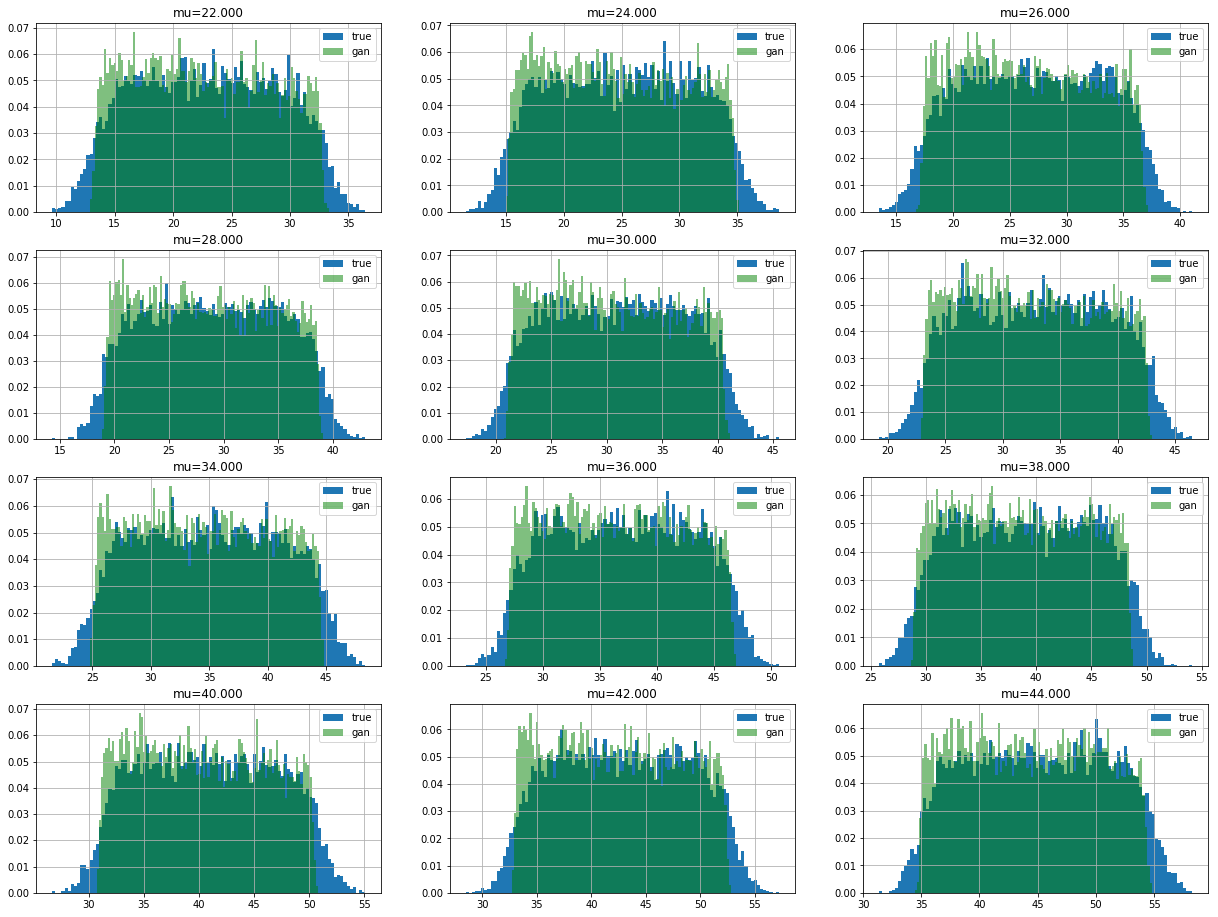

In [42]:
plt.figure(figsize=(21,16))
mu_range = list(range(22, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        input_mu = torch.full(size=(10000, ), fill_value=mu_range[i*3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample().detach().cpu().numpy()

        input_mu = input_mu.to(device)

        
        data_ref = torch.stack([0.1 * torch.randn(len(input_mu)).to(device), 
                                input_mu, input_x], dim=1).float()
        sampled = sample_fn(data_ref)
        
        
        plt.hist(data, bins=100, normed=True, label='true');
        plt.hist(sampled[:, 0].detach().cpu().numpy(),
             bins=100, color='g', density=True, alpha=0.5, label='gan');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))

# Density estimation

In [43]:
from scipy.signal import savgol_filter
def standard_normal_logprob_for_sampling(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([torch.zeros(len(data)).to(data.device), 
                            data[:, 1],
                            data[:, 2]], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([1., 1., 1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas


def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

def proba_fn(data_ref, density_fn):
    zero_ref = torch.stack([torch.zeros(len(data_ref)).to(device), 
                            data_ref[:, 1],
                            data_ref[:, 2]], dim=1).float()
    z, delta_logp = density_fn(data_ref, zero_ref)
    logpz = standard_normal_logprob_for_sampling(z, data_ref)
    logpx = logpz - delta_logp
    
    yhat = savgol_filter(logpx.sum(dim=1).detach().cpu().numpy(), 501, 3)
    proba = exp_normalize(yhat)
    return proba

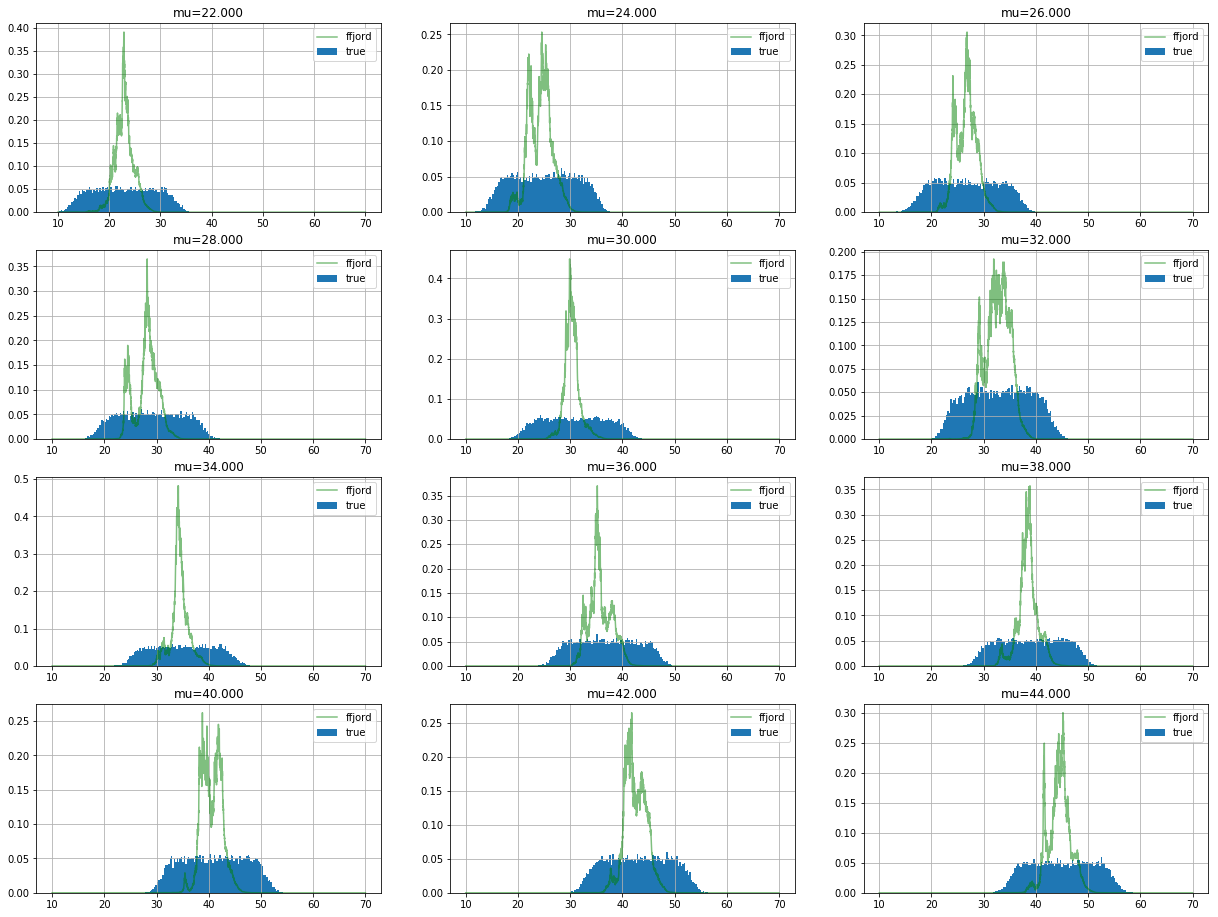

In [44]:
plt.figure(figsize=(21, 16))
mu_range = list(range(22, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4, 3, i*3 + j + 1)
        input_mu = torch.full(size=(10000, ), fill_value=mu_range[i*3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample().detach().cpu().numpy()

        input_mu = input_mu.to(device)

        ref = torch.linspace(10, 70, len(input_mu)).float().to(device)
        data_ref = torch.stack([ref, input_mu, input_x], dim=1).float()
        proba = proba_fn(data_ref, density_fn)
        plt.hist(data, bins=100, normed=True, label='true');
        plt.plot(ref.detach().cpu().numpy(), proba / (ref[1] - ref[0]).item(), color='g', alpha=0.5, label='ffjord');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))

# Test optimisation

In [26]:
lr = 0.1
sample_size = 100


mu_optim = torch.tensor(30.)
mu_optim = mu_optim.repeat(sample_size).to(device)
mu_optim.requires_grad=True

In [27]:
%%time
n_iter = 3000
losses = []
m_vals = []
for _iter in tqdm(range(n_iter)):    
    x = y_sampler.x_dist.sample([mu_optim.shape[0]]).to(device)
    # Do an update    
    data_ref = torch.stack([torch.randn(len(mu_optim)).to(device), 
                            mu_optim, x], dim=1).float()
    sampled = sample_fn(data_ref)
    
    loss = R(sampled[:, 0])
    losses.append(loss.item())
    if mu_optim.grad is not None: mu_optim.grad.zero_()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean()
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].item())
    print(mu_optim[0].item())

  0%|          | 1/3000 [00:06<5:39:57,  6.80s/it]

29.93254280090332


  0%|          | 2/3000 [00:13<5:34:02,  6.69s/it]

29.863983154296875


  0%|          | 3/3000 [00:20<5:43:31,  6.88s/it]

29.797224044799805


  0%|          | 4/3000 [00:27<5:42:32,  6.86s/it]

29.729202270507812


  0%|          | 5/3000 [00:34<5:49:54,  7.01s/it]

29.662817001342773


  0%|          | 6/3000 [00:42<6:01:08,  7.24s/it]

29.59871482849121


  0%|          | 7/3000 [00:48<5:48:19,  6.98s/it]

29.531421661376953


  0%|          | 8/3000 [00:56<5:57:00,  7.16s/it]

29.46668243408203


  0%|          | 9/3000 [01:03<5:47:51,  6.98s/it]

29.39788055419922


  0%|          | 10/3000 [01:10<5:51:09,  7.05s/it]

29.3320255279541


  0%|          | 11/3000 [01:17<5:49:39,  7.02s/it]

29.26615333557129


  0%|          | 12/3000 [01:24<5:47:16,  6.97s/it]

29.200092315673828


  0%|          | 13/3000 [01:30<5:43:38,  6.90s/it]

29.133440017700195


  0%|          | 14/3000 [01:37<5:47:56,  6.99s/it]

29.066547393798828


  0%|          | 15/3000 [01:45<5:50:26,  7.04s/it]

28.999147415161133


  1%|          | 16/3000 [01:51<5:39:10,  6.82s/it]

28.93433952331543


  1%|          | 17/3000 [01:58<5:45:15,  6.94s/it]

28.86757469177246


  1%|          | 18/3000 [02:05<5:41:48,  6.88s/it]

28.800121307373047


  1%|          | 19/3000 [02:11<5:30:19,  6.65s/it]

28.73411750793457


  1%|          | 20/3000 [02:19<5:50:25,  7.06s/it]

28.669612884521484


  1%|          | 21/3000 [02:26<5:42:33,  6.90s/it]

28.60222625732422


  1%|          | 22/3000 [02:33<5:51:03,  7.07s/it]

28.537532806396484


  1%|          | 23/3000 [02:40<5:45:57,  6.97s/it]

28.472429275512695


  1%|          | 24/3000 [02:47<5:46:11,  6.98s/it]

28.407447814941406


  1%|          | 25/3000 [02:54<5:45:16,  6.96s/it]

28.34320640563965


  1%|          | 26/3000 [03:01<5:45:40,  6.97s/it]

28.279460906982422


  1%|          | 27/3000 [03:07<5:34:43,  6.76s/it]

28.214862823486328


  1%|          | 28/3000 [03:13<5:22:13,  6.51s/it]

28.14851188659668


  1%|          | 29/3000 [03:20<5:27:38,  6.62s/it]

28.084514617919922


  1%|          | 30/3000 [03:27<5:30:53,  6.68s/it]

28.0205078125


  1%|          | 31/3000 [03:33<5:34:09,  6.75s/it]

27.957094192504883


  1%|          | 32/3000 [03:41<5:45:43,  6.99s/it]

27.89117431640625


  1%|          | 33/3000 [03:47<5:32:08,  6.72s/it]

27.82882308959961


  1%|          | 34/3000 [03:54<5:33:39,  6.75s/it]

27.764266967773438


  1%|          | 35/3000 [04:01<5:36:13,  6.80s/it]

27.699424743652344


  1%|          | 36/3000 [04:07<5:29:07,  6.66s/it]

27.637575149536133


  1%|          | 37/3000 [04:14<5:32:25,  6.73s/it]

27.57513999938965


  1%|▏         | 38/3000 [04:21<5:36:25,  6.81s/it]

27.51043128967285


  1%|▏         | 39/3000 [04:27<5:29:39,  6.68s/it]

27.444902420043945


  1%|▏         | 40/3000 [04:34<5:28:36,  6.66s/it]

27.380714416503906


  1%|▏         | 41/3000 [04:41<5:28:02,  6.65s/it]

27.31879997253418


  1%|▏         | 42/3000 [04:47<5:21:01,  6.51s/it]

27.25640106201172


  1%|▏         | 43/3000 [04:54<5:26:37,  6.63s/it]

27.1945743560791


  1%|▏         | 44/3000 [05:00<5:22:51,  6.55s/it]

27.132732391357422


  2%|▏         | 45/3000 [05:07<5:32:47,  6.76s/it]

27.071483612060547


  2%|▏         | 46/3000 [05:15<5:39:55,  6.90s/it]

27.009111404418945


  2%|▏         | 47/3000 [05:21<5:30:39,  6.72s/it]

26.946088790893555


  2%|▏         | 48/3000 [05:27<5:27:40,  6.66s/it]

26.881261825561523


  2%|▏         | 49/3000 [05:34<5:32:56,  6.77s/it]

26.81963539123535


  2%|▏         | 50/3000 [05:41<5:26:26,  6.64s/it]

26.75735092163086


  2%|▏         | 51/3000 [05:48<5:28:59,  6.69s/it]

26.694543838500977


  2%|▏         | 52/3000 [05:55<5:32:46,  6.77s/it]

26.63370132446289


  2%|▏         | 53/3000 [06:01<5:22:32,  6.57s/it]

26.572446823120117


  2%|▏         | 54/3000 [06:07<5:23:56,  6.60s/it]

26.51227378845215


  2%|▏         | 55/3000 [06:14<5:27:37,  6.67s/it]

26.450674057006836


  2%|▏         | 56/3000 [06:21<5:22:23,  6.57s/it]

26.390939712524414


  2%|▏         | 57/3000 [06:28<5:32:53,  6.79s/it]

26.328020095825195


  2%|▏         | 58/3000 [06:35<5:38:37,  6.91s/it]

26.26765251159668


  2%|▏         | 59/3000 [06:41<5:29:56,  6.73s/it]

26.206768035888672


  2%|▏         | 60/3000 [06:48<5:34:25,  6.83s/it]

26.14751625061035


  2%|▏         | 61/3000 [06:55<5:31:37,  6.77s/it]

26.087182998657227


  2%|▏         | 62/3000 [07:02<5:32:00,  6.78s/it]

26.02729606628418


  2%|▏         | 63/3000 [07:08<5:29:41,  6.74s/it]

25.967130661010742


  2%|▏         | 64/3000 [07:15<5:29:45,  6.74s/it]

25.907087326049805


  2%|▏         | 65/3000 [07:22<5:30:52,  6.76s/it]

25.84841537475586


  2%|▏         | 66/3000 [07:29<5:39:46,  6.95s/it]

25.78685188293457


  2%|▏         | 67/3000 [07:36<5:34:03,  6.83s/it]

25.726459503173828


  2%|▏         | 68/3000 [07:43<5:36:01,  6.88s/it]

25.66651725769043


  2%|▏         | 69/3000 [07:50<5:35:26,  6.87s/it]

25.607738494873047


  2%|▏         | 70/3000 [07:57<5:33:12,  6.82s/it]

25.550966262817383


  2%|▏         | 71/3000 [08:03<5:29:44,  6.75s/it]

25.49021339416504


  2%|▏         | 72/3000 [08:10<5:28:35,  6.73s/it]

25.427650451660156


  2%|▏         | 73/3000 [08:17<5:29:27,  6.75s/it]

25.369247436523438


  2%|▏         | 74/3000 [08:23<5:27:04,  6.71s/it]

25.310789108276367


  2%|▎         | 75/3000 [08:30<5:23:23,  6.63s/it]

25.251914978027344


  3%|▎         | 76/3000 [08:36<5:23:04,  6.63s/it]

25.197824478149414


  3%|▎         | 77/3000 [08:44<5:40:28,  6.99s/it]

25.13884735107422


  3%|▎         | 78/3000 [08:50<5:29:01,  6.76s/it]

25.080963134765625


  3%|▎         | 79/3000 [08:57<5:26:12,  6.70s/it]

25.019451141357422


  3%|▎         | 80/3000 [09:04<5:25:39,  6.69s/it]

24.959274291992188


  3%|▎         | 81/3000 [09:10<5:24:32,  6.67s/it]

24.899269104003906


  3%|▎         | 82/3000 [09:17<5:23:34,  6.65s/it]

24.840116500854492


  3%|▎         | 83/3000 [09:23<5:16:06,  6.50s/it]

24.78211784362793


  3%|▎         | 84/3000 [09:29<5:14:21,  6.47s/it]

24.724451065063477


  3%|▎         | 85/3000 [09:36<5:21:31,  6.62s/it]

24.66576385498047


  3%|▎         | 86/3000 [09:43<5:16:54,  6.53s/it]

24.60700225830078


  3%|▎         | 87/3000 [09:49<5:21:50,  6.63s/it]

24.54986572265625


  3%|▎         | 88/3000 [09:56<5:23:14,  6.66s/it]

24.492141723632812


  3%|▎         | 89/3000 [10:02<5:16:47,  6.53s/it]

24.43513298034668


  3%|▎         | 90/3000 [10:09<5:14:20,  6.48s/it]

24.378522872924805


  3%|▎         | 91/3000 [10:15<5:10:54,  6.41s/it]

24.31955337524414


  3%|▎         | 92/3000 [10:21<5:10:38,  6.41s/it]

24.26133155822754


  3%|▎         | 93/3000 [10:28<5:11:55,  6.44s/it]

24.204395294189453


  3%|▎         | 94/3000 [10:35<5:13:28,  6.47s/it]

24.147388458251953


  3%|▎         | 95/3000 [10:42<5:21:27,  6.64s/it]

24.08928871154785


  3%|▎         | 96/3000 [10:48<5:20:54,  6.63s/it]

24.033416748046875


  3%|▎         | 97/3000 [10:55<5:22:17,  6.66s/it]

23.976594924926758


  3%|▎         | 98/3000 [11:01<5:20:55,  6.64s/it]

23.920513153076172


  3%|▎         | 99/3000 [11:07<5:07:11,  6.35s/it]

23.864336013793945


  3%|▎         | 100/3000 [11:13<5:03:07,  6.27s/it]

23.80841064453125


  3%|▎         | 101/3000 [11:20<5:05:04,  6.31s/it]

23.7518253326416


  3%|▎         | 102/3000 [11:26<5:04:59,  6.31s/it]

23.692720413208008


  3%|▎         | 103/3000 [11:32<5:07:58,  6.38s/it]

23.637720108032227


  3%|▎         | 104/3000 [11:38<5:01:10,  6.24s/it]

23.582088470458984


  4%|▎         | 105/3000 [11:45<5:07:48,  6.38s/it]

23.525991439819336


  4%|▎         | 106/3000 [11:51<5:05:51,  6.34s/it]

23.469022750854492


  4%|▎         | 107/3000 [11:58<5:05:56,  6.34s/it]

23.411975860595703


  4%|▎         | 108/3000 [12:04<5:05:04,  6.33s/it]

23.35499382019043


  4%|▎         | 109/3000 [12:11<5:10:11,  6.44s/it]

23.299131393432617


  4%|▎         | 110/3000 [12:17<5:07:52,  6.39s/it]

23.245058059692383


  4%|▎         | 111/3000 [12:23<5:04:12,  6.32s/it]

23.19098472595215


  4%|▎         | 112/3000 [12:29<5:04:25,  6.32s/it]

23.134418487548828


  4%|▍         | 113/3000 [12:36<5:07:26,  6.39s/it]

23.082868576049805


  4%|▍         | 114/3000 [12:42<5:04:13,  6.32s/it]

23.030208587646484


  4%|▍         | 115/3000 [12:49<5:07:41,  6.40s/it]

22.974885940551758


  4%|▍         | 116/3000 [12:55<5:04:47,  6.34s/it]

22.918506622314453


  4%|▍         | 117/3000 [13:02<5:08:44,  6.43s/it]

22.863094329833984


  4%|▍         | 118/3000 [13:08<5:04:55,  6.35s/it]

22.810060501098633


  4%|▍         | 119/3000 [13:14<5:09:29,  6.45s/it]

22.75482177734375


  4%|▍         | 120/3000 [13:20<5:00:57,  6.27s/it]

22.70193099975586


  4%|▍         | 121/3000 [13:26<4:49:18,  6.03s/it]

22.646055221557617


  4%|▍         | 122/3000 [13:31<4:44:29,  5.93s/it]

22.5906982421875


  4%|▍         | 123/3000 [13:37<4:44:46,  5.94s/it]

22.535037994384766


  4%|▍         | 124/3000 [13:44<4:48:07,  6.01s/it]

22.4792537689209


  4%|▍         | 125/3000 [13:49<4:41:36,  5.88s/it]

22.42498016357422


  4%|▍         | 126/3000 [13:56<4:49:43,  6.05s/it]

22.37238311767578


  4%|▍         | 127/3000 [14:02<4:57:03,  6.20s/it]

22.32036781311035


  4%|▍         | 128/3000 [14:08<4:55:26,  6.17s/it]

22.266231536865234


  4%|▍         | 129/3000 [14:15<4:57:10,  6.21s/it]

22.213823318481445


  4%|▍         | 130/3000 [14:21<4:54:09,  6.15s/it]

22.16095542907715


  4%|▍         | 131/3000 [14:27<5:00:10,  6.28s/it]

22.107091903686523


  4%|▍         | 132/3000 [14:33<4:57:57,  6.23s/it]

22.052595138549805


  4%|▍         | 133/3000 [14:39<4:55:32,  6.19s/it]

21.999467849731445


  4%|▍         | 134/3000 [14:46<4:59:11,  6.26s/it]

21.945064544677734


  4%|▍         | 135/3000 [14:52<4:58:29,  6.25s/it]

21.89348793029785


  5%|▍         | 136/3000 [14:58<4:59:03,  6.27s/it]

21.841266632080078


  5%|▍         | 137/3000 [15:05<5:08:30,  6.47s/it]

21.788509368896484


  5%|▍         | 138/3000 [15:12<5:05:51,  6.41s/it]

21.736373901367188


  5%|▍         | 139/3000 [15:18<5:03:58,  6.37s/it]

21.68500328063965


  5%|▍         | 140/3000 [15:24<5:03:55,  6.38s/it]

21.633590698242188


  5%|▍         | 141/3000 [15:31<5:08:10,  6.47s/it]

21.581823348999023


  5%|▍         | 142/3000 [15:38<5:11:07,  6.53s/it]

21.527008056640625


  5%|▍         | 143/3000 [15:44<5:09:48,  6.51s/it]

21.47274398803711


  5%|▍         | 144/3000 [15:50<5:07:02,  6.45s/it]

21.42181396484375


  5%|▍         | 145/3000 [15:56<4:58:31,  6.27s/it]

21.37124252319336


  5%|▍         | 146/3000 [16:02<4:53:39,  6.17s/it]

21.32032585144043


  5%|▍         | 147/3000 [16:08<4:51:02,  6.12s/it]

21.268869400024414


  5%|▍         | 148/3000 [16:15<5:01:11,  6.34s/it]

21.216981887817383


  5%|▍         | 149/3000 [16:21<4:54:19,  6.19s/it]

21.168350219726562


  5%|▌         | 150/3000 [16:27<4:55:14,  6.22s/it]

21.116798400878906


  5%|▌         | 151/3000 [16:34<4:59:01,  6.30s/it]

21.065481185913086


  5%|▌         | 152/3000 [16:39<4:50:32,  6.12s/it]

21.013652801513672


  5%|▌         | 153/3000 [16:45<4:47:42,  6.06s/it]

20.964292526245117


  5%|▌         | 154/3000 [16:51<4:41:31,  5.93s/it]

20.91487693786621


  5%|▌         | 155/3000 [16:57<4:42:45,  5.96s/it]

20.863903045654297


  5%|▌         | 156/3000 [17:03<4:39:40,  5.90s/it]

20.81426239013672


  5%|▌         | 157/3000 [17:09<4:46:24,  6.04s/it]

20.764986038208008


  5%|▌         | 158/3000 [17:15<4:52:14,  6.17s/it]

20.717540740966797


  5%|▌         | 159/3000 [17:22<4:53:20,  6.20s/it]

20.66648292541504


  5%|▌         | 160/3000 [17:28<4:54:27,  6.22s/it]

20.616416931152344


  5%|▌         | 161/3000 [17:34<4:54:55,  6.23s/it]

20.565305709838867


  5%|▌         | 162/3000 [17:40<4:53:38,  6.21s/it]

20.515127182006836


  5%|▌         | 163/3000 [17:47<4:54:59,  6.24s/it]

20.464317321777344


  5%|▌         | 164/3000 [17:53<4:52:04,  6.18s/it]

20.41514778137207


  6%|▌         | 165/3000 [17:59<4:50:57,  6.16s/it]

20.362689971923828


  6%|▌         | 166/3000 [18:05<4:46:35,  6.07s/it]

20.31175994873047


  6%|▌         | 167/3000 [18:11<4:43:22,  6.00s/it]

20.260976791381836


  6%|▌         | 168/3000 [18:16<4:39:16,  5.92s/it]

20.21002197265625


  6%|▌         | 169/3000 [18:22<4:36:48,  5.87s/it]

20.16005516052246


  6%|▌         | 170/3000 [18:28<4:43:33,  6.01s/it]

20.111902236938477


  6%|▌         | 171/3000 [18:35<4:51:10,  6.18s/it]

20.064531326293945


  6%|▌         | 172/3000 [18:41<4:44:53,  6.04s/it]

20.016450881958008


  6%|▌         | 173/3000 [18:47<4:44:09,  6.03s/it]

19.96813201904297


  6%|▌         | 174/3000 [18:53<4:41:33,  5.98s/it]

19.91912841796875


  6%|▌         | 175/3000 [18:59<4:44:33,  6.04s/it]

19.86594581604004


  6%|▌         | 176/3000 [19:04<4:39:09,  5.93s/it]

19.817216873168945


  6%|▌         | 177/3000 [19:10<4:27:46,  5.69s/it]

19.76618766784668


  6%|▌         | 178/3000 [19:15<4:28:28,  5.71s/it]

19.716751098632812


  6%|▌         | 179/3000 [19:21<4:30:24,  5.75s/it]

19.66819953918457


  6%|▌         | 180/3000 [19:28<4:39:02,  5.94s/it]

19.618959426879883


  6%|▌         | 181/3000 [19:34<4:40:57,  5.98s/it]

19.572233200073242


  6%|▌         | 182/3000 [19:40<4:49:01,  6.15s/it]

19.522968292236328


  6%|▌         | 183/3000 [19:46<4:44:22,  6.06s/it]

19.47355079650879


  6%|▌         | 184/3000 [19:52<4:39:28,  5.95s/it]

19.425498962402344


  6%|▌         | 185/3000 [19:57<4:34:53,  5.86s/it]

19.377592086791992


  6%|▌         | 186/3000 [20:04<4:43:04,  6.04s/it]

19.33163833618164


  6%|▌         | 187/3000 [20:10<4:46:10,  6.10s/it]

19.28645133972168


  6%|▋         | 188/3000 [20:16<4:49:23,  6.17s/it]

19.237646102905273


  6%|▋         | 189/3000 [20:22<4:46:14,  6.11s/it]

19.19063377380371


  6%|▋         | 190/3000 [20:28<4:46:11,  6.11s/it]

19.14214324951172


  6%|▋         | 191/3000 [20:34<4:34:07,  5.86s/it]

19.092851638793945


  6%|▋         | 192/3000 [20:40<4:38:48,  5.96s/it]

19.04856300354004


  6%|▋         | 193/3000 [20:46<4:44:41,  6.09s/it]

19.002601623535156


  6%|▋         | 194/3000 [20:53<4:45:58,  6.11s/it]

18.95461654663086


  6%|▋         | 195/3000 [20:58<4:43:14,  6.06s/it]

18.907001495361328


  7%|▋         | 196/3000 [21:04<4:40:50,  6.01s/it]

18.85999298095703


  7%|▋         | 197/3000 [21:10<4:37:51,  5.95s/it]

18.812551498413086


  7%|▋         | 198/3000 [21:17<4:44:01,  6.08s/it]

18.76532554626465


  7%|▋         | 199/3000 [21:23<4:44:32,  6.10s/it]

18.719797134399414


  7%|▋         | 200/3000 [21:28<4:38:59,  5.98s/it]

18.674840927124023


  7%|▋         | 201/3000 [21:35<4:44:09,  6.09s/it]

18.627155303955078


  7%|▋         | 202/3000 [21:40<4:34:37,  5.89s/it]

18.58159065246582


  7%|▋         | 203/3000 [21:46<4:35:20,  5.91s/it]

18.535911560058594


  7%|▋         | 204/3000 [21:51<4:28:25,  5.76s/it]

18.49010467529297


  7%|▋         | 205/3000 [21:58<4:34:44,  5.90s/it]

18.444665908813477


  7%|▋         | 206/3000 [22:03<4:27:44,  5.75s/it]

18.39866065979004


  7%|▋         | 207/3000 [22:09<4:27:35,  5.75s/it]

18.352331161499023


  7%|▋         | 208/3000 [22:15<4:28:46,  5.78s/it]

18.30687713623047


  7%|▋         | 209/3000 [22:21<4:36:02,  5.93s/it]

18.260099411010742


  7%|▋         | 210/3000 [22:27<4:33:43,  5.89s/it]

18.21319007873535


  7%|▋         | 211/3000 [22:33<4:34:19,  5.90s/it]

18.167882919311523


  7%|▋         | 212/3000 [22:38<4:30:01,  5.81s/it]

18.1212158203125


  7%|▋         | 213/3000 [22:44<4:28:04,  5.77s/it]

18.076595306396484


  7%|▋         | 214/3000 [22:50<4:31:26,  5.85s/it]

18.031715393066406


  7%|▋         | 215/3000 [22:56<4:27:06,  5.75s/it]

17.985641479492188


  7%|▋         | 216/3000 [23:01<4:23:51,  5.69s/it]

17.941234588623047


  7%|▋         | 217/3000 [23:07<4:26:03,  5.74s/it]

17.893129348754883


  7%|▋         | 218/3000 [23:13<4:27:02,  5.76s/it]

17.847026824951172


  7%|▋         | 219/3000 [23:19<4:30:54,  5.84s/it]

17.8037166595459


  7%|▋         | 220/3000 [23:25<4:28:52,  5.80s/it]

17.759387969970703


  7%|▋         | 221/3000 [23:30<4:30:47,  5.85s/it]

17.716352462768555


  7%|▋         | 222/3000 [23:37<4:37:14,  5.99s/it]

17.66968536376953


  7%|▋         | 223/3000 [23:43<4:38:11,  6.01s/it]

17.625831604003906


  7%|▋         | 224/3000 [23:49<4:39:55,  6.05s/it]

17.579450607299805


  8%|▊         | 225/3000 [23:55<4:38:04,  6.01s/it]

17.537111282348633


  8%|▊         | 226/3000 [24:00<4:30:35,  5.85s/it]

17.49413299560547


  8%|▊         | 227/3000 [24:06<4:26:38,  5.77s/it]

17.449167251586914


  8%|▊         | 228/3000 [24:12<4:25:22,  5.74s/it]

17.404508590698242


  8%|▊         | 229/3000 [24:18<4:31:51,  5.89s/it]

17.359521865844727


  8%|▊         | 230/3000 [24:23<4:27:54,  5.80s/it]

17.316919326782227


  8%|▊         | 231/3000 [24:30<4:33:14,  5.92s/it]

17.271703720092773


  8%|▊         | 232/3000 [24:35<4:31:43,  5.89s/it]

17.228919982910156


  8%|▊         | 233/3000 [24:41<4:32:11,  5.90s/it]

17.18331527709961


  8%|▊         | 234/3000 [24:47<4:29:20,  5.84s/it]

17.139204025268555


  8%|▊         | 235/3000 [24:53<4:27:42,  5.81s/it]

17.09475326538086


  8%|▊         | 236/3000 [24:58<4:24:46,  5.75s/it]

17.052574157714844


  8%|▊         | 237/3000 [25:04<4:26:42,  5.79s/it]

17.008691787719727


  8%|▊         | 238/3000 [25:10<4:26:30,  5.79s/it]

16.964216232299805


  8%|▊         | 239/3000 [25:15<4:20:14,  5.66s/it]

16.920515060424805


  8%|▊         | 240/3000 [25:21<4:21:51,  5.69s/it]

16.87604331970215


  8%|▊         | 241/3000 [25:27<4:24:47,  5.76s/it]

16.833459854125977


  8%|▊         | 242/3000 [25:32<4:16:29,  5.58s/it]

16.789968490600586


  8%|▊         | 243/3000 [25:38<4:15:17,  5.56s/it]

16.74757194519043


  8%|▊         | 244/3000 [25:44<4:19:58,  5.66s/it]

16.705656051635742


  8%|▊         | 245/3000 [25:49<4:20:00,  5.66s/it]

16.659849166870117


  8%|▊         | 246/3000 [25:55<4:20:21,  5.67s/it]

16.617164611816406


  8%|▊         | 247/3000 [26:01<4:20:27,  5.68s/it]

16.57619285583496


  8%|▊         | 248/3000 [26:06<4:11:27,  5.48s/it]

16.534698486328125


  8%|▊         | 249/3000 [26:12<4:19:38,  5.66s/it]

16.494356155395508


  8%|▊         | 250/3000 [26:17<4:18:43,  5.64s/it]

16.452857971191406


  8%|▊         | 251/3000 [26:23<4:18:54,  5.65s/it]

16.411869049072266


  8%|▊         | 252/3000 [26:29<4:18:07,  5.64s/it]

16.369213104248047


  8%|▊         | 253/3000 [26:34<4:16:51,  5.61s/it]

16.32628631591797


  8%|▊         | 254/3000 [26:40<4:20:33,  5.69s/it]

16.284698486328125


  8%|▊         | 255/3000 [26:46<4:18:54,  5.66s/it]

16.2407169342041


  9%|▊         | 256/3000 [26:51<4:15:41,  5.59s/it]

16.199893951416016


  9%|▊         | 257/3000 [26:57<4:15:54,  5.60s/it]

16.15877342224121


  9%|▊         | 258/3000 [27:03<4:20:39,  5.70s/it]

16.117183685302734


  9%|▊         | 259/3000 [27:08<4:15:08,  5.58s/it]

16.07338523864746


  9%|▊         | 260/3000 [27:14<4:17:29,  5.64s/it]

16.029760360717773


  9%|▊         | 261/3000 [27:20<4:17:42,  5.65s/it]

15.986716270446777


  9%|▊         | 262/3000 [27:25<4:13:32,  5.56s/it]

15.946015357971191


  9%|▉         | 263/3000 [27:31<4:20:30,  5.71s/it]

15.90295696258545


  9%|▉         | 264/3000 [27:37<4:26:14,  5.84s/it]

15.86292839050293


  9%|▉         | 265/3000 [27:43<4:28:50,  5.90s/it]

15.822447776794434


  9%|▉         | 266/3000 [27:48<4:19:47,  5.70s/it]

15.779500961303711


  9%|▉         | 267/3000 [27:54<4:15:13,  5.60s/it]

15.73861312866211


  9%|▉         | 268/3000 [27:59<4:15:12,  5.60s/it]

15.700034141540527


  9%|▉         | 269/3000 [28:05<4:15:05,  5.60s/it]

15.65907096862793


  9%|▉         | 270/3000 [28:10<4:12:45,  5.56s/it]

15.617588996887207


  9%|▉         | 271/3000 [28:16<4:17:49,  5.67s/it]

15.577058792114258


  9%|▉         | 272/3000 [28:22<4:19:36,  5.71s/it]

15.535054206848145


  9%|▉         | 273/3000 [28:28<4:20:19,  5.73s/it]

15.492698669433594


  9%|▉         | 274/3000 [28:34<4:20:02,  5.72s/it]

15.453421592712402


  9%|▉         | 275/3000 [28:40<4:24:11,  5.82s/it]

15.414325714111328


  9%|▉         | 276/3000 [28:45<4:21:52,  5.77s/it]

15.375402450561523


  9%|▉         | 277/3000 [28:51<4:19:03,  5.71s/it]

15.335506439208984


  9%|▉         | 278/3000 [28:56<4:15:11,  5.63s/it]

15.294066429138184


  9%|▉         | 279/3000 [29:02<4:17:43,  5.68s/it]

15.252963066101074


  9%|▉         | 280/3000 [29:08<4:16:25,  5.66s/it]

15.210129737854004


  9%|▉         | 281/3000 [29:13<4:12:56,  5.58s/it]

15.170489311218262


  9%|▉         | 282/3000 [29:18<4:10:12,  5.52s/it]

15.129599571228027


  9%|▉         | 283/3000 [29:25<4:18:55,  5.72s/it]

15.088337898254395


  9%|▉         | 284/3000 [29:30<4:19:43,  5.74s/it]

15.047673225402832


 10%|▉         | 285/3000 [29:37<4:25:20,  5.86s/it]

15.007702827453613


 10%|▉         | 286/3000 [29:42<4:17:18,  5.69s/it]

14.966238975524902


 10%|▉         | 287/3000 [29:48<4:19:25,  5.74s/it]

14.92783260345459


 10%|▉         | 288/3000 [29:53<4:14:34,  5.63s/it]

14.885193824768066


 10%|▉         | 289/3000 [29:59<4:16:43,  5.68s/it]

14.845478057861328


 10%|▉         | 290/3000 [30:05<4:20:44,  5.77s/it]

14.806230545043945


 10%|▉         | 291/3000 [30:11<4:25:29,  5.88s/it]

14.76593017578125


 10%|▉         | 292/3000 [30:18<4:33:45,  6.07s/it]

14.728044509887695


 10%|▉         | 293/3000 [30:23<4:26:38,  5.91s/it]

14.687273025512695


 10%|▉         | 294/3000 [30:29<4:26:55,  5.92s/it]

14.646750450134277


 10%|▉         | 295/3000 [30:35<4:25:33,  5.89s/it]

14.607986450195312


 10%|▉         | 296/3000 [30:41<4:24:49,  5.88s/it]

14.568513870239258


 10%|▉         | 297/3000 [30:47<4:24:58,  5.88s/it]

14.527143478393555


 10%|▉         | 298/3000 [30:52<4:16:43,  5.70s/it]

14.486570358276367


 10%|▉         | 299/3000 [30:57<4:15:22,  5.67s/it]

14.446465492248535


 10%|█         | 300/3000 [31:03<4:14:57,  5.67s/it]

14.409246444702148


 10%|█         | 301/3000 [31:08<4:07:28,  5.50s/it]

14.369832992553711


 10%|█         | 302/3000 [31:14<4:11:15,  5.59s/it]

14.331903457641602


 10%|█         | 303/3000 [31:19<4:09:28,  5.55s/it]

14.29367446899414


 10%|█         | 304/3000 [31:25<4:12:59,  5.63s/it]

14.256033897399902


 10%|█         | 305/3000 [31:31<4:14:25,  5.66s/it]

14.217066764831543


 10%|█         | 306/3000 [31:36<4:10:19,  5.58s/it]

14.176024436950684


 10%|█         | 307/3000 [31:42<4:13:16,  5.64s/it]

14.138532638549805


 10%|█         | 308/3000 [31:48<4:13:21,  5.65s/it]

14.100016593933105


 10%|█         | 309/3000 [31:53<4:12:13,  5.62s/it]

14.0604887008667


 10%|█         | 310/3000 [31:59<4:06:50,  5.51s/it]

14.022116661071777


 10%|█         | 311/3000 [32:05<4:13:44,  5.66s/it]

13.983685493469238


 10%|█         | 312/3000 [32:11<4:16:22,  5.72s/it]

13.947044372558594


 10%|█         | 313/3000 [32:16<4:12:31,  5.64s/it]

13.908352851867676


 10%|█         | 314/3000 [32:21<4:07:18,  5.52s/it]

13.870327949523926


 10%|█         | 315/3000 [32:27<4:11:00,  5.61s/it]

13.831503868103027


 11%|█         | 316/3000 [32:33<4:12:27,  5.64s/it]

13.794777870178223


 11%|█         | 317/3000 [32:39<4:13:55,  5.68s/it]

13.7582368850708


 11%|█         | 318/3000 [32:43<4:02:32,  5.43s/it]

13.719663619995117


 11%|█         | 319/3000 [32:49<4:09:26,  5.58s/it]

13.682930946350098


 11%|█         | 320/3000 [32:55<4:09:28,  5.59s/it]

13.64587116241455


 11%|█         | 321/3000 [33:00<4:07:00,  5.53s/it]

13.609512329101562


 11%|█         | 322/3000 [33:06<4:04:51,  5.49s/it]

13.570188522338867


 11%|█         | 323/3000 [33:11<4:04:14,  5.47s/it]

13.532417297363281


 11%|█         | 324/3000 [33:17<4:06:53,  5.54s/it]

13.495641708374023


 11%|█         | 325/3000 [33:22<4:04:53,  5.49s/it]

13.458913803100586


 11%|█         | 326/3000 [33:28<4:05:37,  5.51s/it]

13.419510841369629


 11%|█         | 327/3000 [33:34<4:09:26,  5.60s/it]

13.382473945617676


 11%|█         | 328/3000 [33:40<4:16:52,  5.77s/it]

13.346796035766602


 11%|█         | 329/3000 [33:46<4:19:45,  5.84s/it]

13.310811042785645


 11%|█         | 330/3000 [33:51<4:17:17,  5.78s/it]

13.273736000061035


 11%|█         | 331/3000 [33:57<4:18:52,  5.82s/it]

13.238179206848145


 11%|█         | 332/3000 [34:03<4:15:41,  5.75s/it]

13.201562881469727


 11%|█         | 333/3000 [34:08<4:11:52,  5.67s/it]

13.165771484375


 11%|█         | 334/3000 [34:14<4:10:45,  5.64s/it]

13.130736351013184


 11%|█         | 335/3000 [34:20<4:10:53,  5.65s/it]

13.094730377197266


 11%|█         | 336/3000 [34:26<4:18:49,  5.83s/it]

13.060569763183594


 11%|█         | 337/3000 [34:32<4:23:43,  5.94s/it]

13.024184226989746


 11%|█▏        | 338/3000 [34:37<4:14:34,  5.74s/it]

12.98792839050293


 11%|█▏        | 339/3000 [34:43<4:11:25,  5.67s/it]

12.953031539916992


 11%|█▏        | 340/3000 [34:49<4:15:20,  5.76s/it]

12.918724060058594


 11%|█▏        | 341/3000 [34:55<4:18:13,  5.83s/it]

12.883001327514648


 11%|█▏        | 342/3000 [35:00<4:14:20,  5.74s/it]

12.845484733581543


 11%|█▏        | 343/3000 [35:06<4:12:19,  5.70s/it]

12.808821678161621


 11%|█▏        | 344/3000 [35:11<4:05:20,  5.54s/it]

12.773538589477539


 12%|█▏        | 345/3000 [35:17<4:06:03,  5.56s/it]

12.735514640808105


 12%|█▏        | 346/3000 [35:23<4:11:59,  5.70s/it]

12.700687408447266


 12%|█▏        | 347/3000 [35:28<4:05:45,  5.56s/it]

12.66516399383545


 12%|█▏        | 348/3000 [35:33<4:05:12,  5.55s/it]

12.628626823425293


 12%|█▏        | 349/3000 [35:38<3:57:49,  5.38s/it]

12.592066764831543


 12%|█▏        | 350/3000 [35:44<3:56:48,  5.36s/it]

12.55633544921875


 12%|█▏        | 351/3000 [35:49<3:58:20,  5.40s/it]

12.520256996154785


 12%|█▏        | 352/3000 [35:55<4:02:35,  5.50s/it]

12.48289680480957


 12%|█▏        | 353/3000 [36:01<4:06:43,  5.59s/it]

12.447256088256836


 12%|█▏        | 354/3000 [36:07<4:10:54,  5.69s/it]

12.412801742553711


 12%|█▏        | 355/3000 [36:12<4:04:59,  5.56s/it]

12.377836227416992


 12%|█▏        | 356/3000 [36:17<3:59:41,  5.44s/it]

12.343413352966309


 12%|█▏        | 357/3000 [36:22<3:57:19,  5.39s/it]

12.306840896606445


 12%|█▏        | 358/3000 [36:28<4:05:02,  5.57s/it]

12.270730018615723


 12%|█▏        | 359/3000 [36:34<3:59:20,  5.44s/it]

12.23487377166748


 12%|█▏        | 360/3000 [36:39<4:03:34,  5.54s/it]

12.199861526489258


 12%|█▏        | 361/3000 [36:45<4:05:47,  5.59s/it]

12.164186477661133


 12%|█▏        | 362/3000 [36:51<4:08:23,  5.65s/it]

12.130017280578613


 12%|█▏        | 363/3000 [36:56<4:07:07,  5.62s/it]

12.095070838928223


 12%|█▏        | 364/3000 [37:02<4:01:27,  5.50s/it]

12.06018352508545


 12%|█▏        | 365/3000 [37:07<4:03:09,  5.54s/it]

12.02621078491211


 12%|█▏        | 366/3000 [37:13<4:02:46,  5.53s/it]

11.99135971069336


 12%|█▏        | 367/3000 [37:18<4:02:15,  5.52s/it]

11.955842971801758


 12%|█▏        | 368/3000 [37:24<4:01:59,  5.52s/it]

11.920283317565918


 12%|█▏        | 369/3000 [37:30<4:09:47,  5.70s/it]

11.886013984680176


 12%|█▏        | 370/3000 [37:35<4:07:36,  5.65s/it]

11.853039741516113


 12%|█▏        | 371/3000 [37:42<4:14:03,  5.80s/it]

11.81888198852539


 12%|█▏        | 372/3000 [37:47<4:14:20,  5.81s/it]

11.783684730529785


 12%|█▏        | 373/3000 [37:53<4:15:17,  5.83s/it]

11.748610496520996


 12%|█▏        | 374/3000 [37:59<4:08:17,  5.67s/it]

11.715191841125488


 12%|█▎        | 375/3000 [38:05<4:13:08,  5.79s/it]

11.68175983428955


 13%|█▎        | 376/3000 [38:10<4:08:16,  5.68s/it]

11.645122528076172


 13%|█▎        | 377/3000 [38:16<4:05:56,  5.63s/it]

11.610944747924805


 13%|█▎        | 378/3000 [38:21<4:03:41,  5.58s/it]

11.577739715576172


 13%|█▎        | 379/3000 [38:27<4:07:08,  5.66s/it]

11.54624080657959


 13%|█▎        | 380/3000 [38:32<4:03:21,  5.57s/it]

11.513117790222168


 13%|█▎        | 381/3000 [38:38<4:08:15,  5.69s/it]

11.479506492614746


 13%|█▎        | 382/3000 [38:44<4:13:18,  5.81s/it]

11.445595741271973


 13%|█▎        | 383/3000 [38:50<4:09:05,  5.71s/it]

11.414554595947266


 13%|█▎        | 384/3000 [38:55<4:05:22,  5.63s/it]

11.381577491760254


 13%|█▎        | 385/3000 [39:01<4:04:22,  5.61s/it]

11.348112106323242


 13%|█▎        | 386/3000 [39:06<3:58:31,  5.47s/it]

11.31347370147705


 13%|█▎        | 387/3000 [39:11<3:55:52,  5.42s/it]

11.279943466186523


 13%|█▎        | 388/3000 [39:17<4:01:53,  5.56s/it]

11.248812675476074


 13%|█▎        | 389/3000 [39:22<4:00:02,  5.52s/it]

11.214945793151855


 13%|█▎        | 390/3000 [39:28<4:00:41,  5.53s/it]

11.183314323425293


 13%|█▎        | 391/3000 [39:34<4:01:33,  5.56s/it]

11.148889541625977


 13%|█▎        | 392/3000 [39:39<4:04:40,  5.63s/it]

11.11837100982666


 13%|█▎        | 393/3000 [39:45<4:03:31,  5.60s/it]

11.087446212768555


 13%|█▎        | 394/3000 [39:50<4:01:17,  5.56s/it]

11.054546356201172


 13%|█▎        | 395/3000 [39:56<4:04:44,  5.64s/it]

11.021526336669922


 13%|█▎        | 396/3000 [40:02<4:01:40,  5.57s/it]

10.991019248962402


 13%|█▎        | 397/3000 [40:07<4:02:30,  5.59s/it]

10.957647323608398


 13%|█▎        | 398/3000 [40:13<4:01:32,  5.57s/it]

10.924735069274902


 13%|█▎        | 399/3000 [40:18<4:00:24,  5.55s/it]

10.891910552978516


 13%|█▎        | 400/3000 [40:24<3:57:50,  5.49s/it]

10.861159324645996


 13%|█▎        | 401/3000 [40:29<3:54:31,  5.41s/it]

10.828878402709961


 13%|█▎        | 402/3000 [40:34<3:54:15,  5.41s/it]

10.793519973754883


 13%|█▎        | 403/3000 [40:40<3:57:42,  5.49s/it]

10.762223243713379


 13%|█▎        | 404/3000 [40:46<4:01:57,  5.59s/it]

10.73206615447998


 14%|█▎        | 405/3000 [40:51<3:56:53,  5.48s/it]

10.699708938598633


 14%|█▎        | 406/3000 [40:57<4:03:35,  5.63s/it]

10.668365478515625


 14%|█▎        | 407/3000 [41:03<4:05:35,  5.68s/it]

10.635470390319824


 14%|█▎        | 408/3000 [41:08<4:00:11,  5.56s/it]

10.603034019470215


 14%|█▎        | 409/3000 [41:14<4:00:40,  5.57s/it]

10.571242332458496


 14%|█▎        | 410/3000 [41:20<4:04:49,  5.67s/it]

10.539701461791992


 14%|█▎        | 411/3000 [41:25<4:04:19,  5.66s/it]

10.508429527282715


 14%|█▎        | 412/3000 [41:31<4:02:00,  5.61s/it]

10.47575855255127


 14%|█▍        | 413/3000 [41:36<3:55:57,  5.47s/it]

10.442014694213867


 14%|█▍        | 414/3000 [41:42<4:02:59,  5.64s/it]

10.409811973571777


 14%|█▍        | 415/3000 [41:47<4:01:42,  5.61s/it]

10.376351356506348


 14%|█▍        | 416/3000 [41:53<4:02:56,  5.64s/it]

10.34447193145752


 14%|█▍        | 417/3000 [41:58<3:58:08,  5.53s/it]

10.31251049041748


 14%|█▍        | 418/3000 [42:04<4:02:37,  5.64s/it]

10.281587600708008


 14%|█▍        | 419/3000 [42:10<3:57:09,  5.51s/it]

10.248414039611816


 14%|█▍        | 420/3000 [42:16<4:03:56,  5.67s/it]

10.219019889831543


 14%|█▍        | 421/3000 [42:21<4:03:28,  5.66s/it]

10.191083908081055


 14%|█▍        | 422/3000 [42:27<4:00:31,  5.60s/it]

10.1619873046875


 14%|█▍        | 423/3000 [42:32<4:02:47,  5.65s/it]

10.1307954788208


 14%|█▍        | 424/3000 [42:38<4:00:03,  5.59s/it]

10.099727630615234


 14%|█▍        | 425/3000 [42:43<3:53:02,  5.43s/it]

10.067085266113281


 14%|█▍        | 426/3000 [42:49<3:54:57,  5.48s/it]

10.036713600158691


 14%|█▍        | 427/3000 [42:54<3:57:12,  5.53s/it]

10.004953384399414


 14%|█▍        | 428/3000 [43:00<4:02:27,  5.66s/it]

9.97329330444336


 14%|█▍        | 429/3000 [43:06<4:01:55,  5.65s/it]

9.942697525024414


 14%|█▍        | 430/3000 [43:11<4:00:56,  5.63s/it]

9.911314964294434


 14%|█▍        | 431/3000 [43:18<4:07:56,  5.79s/it]

9.882047653198242


 14%|█▍        | 432/3000 [43:23<4:07:13,  5.78s/it]

9.852008819580078


 14%|█▍        | 433/3000 [43:29<4:03:46,  5.70s/it]

9.82049560546875


 14%|█▍        | 434/3000 [43:35<4:04:18,  5.71s/it]

9.791004180908203


 14%|█▍        | 435/3000 [43:40<4:00:37,  5.63s/it]

9.762104988098145


 15%|█▍        | 436/3000 [43:46<4:00:10,  5.62s/it]

9.73183822631836


 15%|█▍        | 437/3000 [43:52<4:07:39,  5.80s/it]

9.702226638793945


 15%|█▍        | 438/3000 [43:58<4:10:06,  5.86s/it]

9.673803329467773


 15%|█▍        | 439/3000 [44:03<4:02:54,  5.69s/it]

9.64338207244873


 15%|█▍        | 440/3000 [44:09<3:59:00,  5.60s/it]

9.611830711364746


 15%|█▍        | 441/3000 [44:14<3:53:15,  5.47s/it]

9.582185745239258


 15%|█▍        | 442/3000 [44:19<3:47:47,  5.34s/it]

9.551983833312988


 15%|█▍        | 443/3000 [44:24<3:43:55,  5.25s/it]

9.520621299743652


 15%|█▍        | 444/3000 [44:29<3:47:32,  5.34s/it]

9.488953590393066


 15%|█▍        | 445/3000 [44:35<3:54:00,  5.50s/it]

9.460280418395996


 15%|█▍        | 446/3000 [44:41<4:03:33,  5.72s/it]

9.432297706604004


 15%|█▍        | 447/3000 [44:47<4:04:48,  5.75s/it]

9.400815963745117


 15%|█▍        | 448/3000 [44:53<4:03:41,  5.73s/it]

9.372810363769531


 15%|█▍        | 449/3000 [44:59<4:08:38,  5.85s/it]

9.34280776977539


 15%|█▌        | 450/3000 [45:05<4:07:23,  5.82s/it]

9.311483383178711


 15%|█▌        | 451/3000 [45:10<4:04:15,  5.75s/it]

9.28266429901123


 15%|█▌        | 452/3000 [45:16<4:01:49,  5.69s/it]

9.253483772277832


 15%|█▌        | 453/3000 [45:21<3:58:10,  5.61s/it]

9.224087715148926


 15%|█▌        | 454/3000 [45:27<3:59:12,  5.64s/it]

9.194169044494629


 15%|█▌        | 455/3000 [45:33<3:58:49,  5.63s/it]

9.164490699768066


 15%|█▌        | 456/3000 [45:39<4:02:54,  5.73s/it]

9.133909225463867


 15%|█▌        | 457/3000 [45:44<4:04:22,  5.77s/it]

9.104676246643066


 15%|█▌        | 458/3000 [45:50<4:01:12,  5.69s/it]

9.075634002685547


 15%|█▌        | 459/3000 [45:55<3:57:02,  5.60s/it]

9.046114921569824


 15%|█▌        | 460/3000 [46:01<3:56:03,  5.58s/it]

9.016575813293457


 15%|█▌        | 461/3000 [46:07<4:00:07,  5.67s/it]

8.987436294555664


 15%|█▌        | 462/3000 [46:13<4:03:01,  5.75s/it]

8.955794334411621


 15%|█▌        | 463/3000 [46:19<4:06:28,  5.83s/it]

8.925036430358887


 15%|█▌        | 464/3000 [46:24<4:02:00,  5.73s/it]

8.895933151245117


 16%|█▌        | 465/3000 [46:30<3:58:38,  5.65s/it]

8.865764617919922


 16%|█▌        | 466/3000 [46:36<4:00:52,  5.70s/it]

8.839156150817871


 16%|█▌        | 467/3000 [46:41<3:58:42,  5.65s/it]

8.809316635131836


 16%|█▌        | 468/3000 [46:47<3:56:54,  5.61s/it]

8.779550552368164


 16%|█▌        | 469/3000 [46:52<3:55:17,  5.58s/it]

8.749686241149902


 16%|█▌        | 470/3000 [46:57<3:50:41,  5.47s/it]

8.721563339233398


 16%|█▌        | 471/3000 [47:03<3:48:17,  5.42s/it]

8.6924467086792


 16%|█▌        | 472/3000 [47:08<3:48:11,  5.42s/it]

8.66336727142334


 16%|█▌        | 473/3000 [47:13<3:46:21,  5.37s/it]

8.63499927520752


 16%|█▌        | 474/3000 [47:19<3:48:07,  5.42s/it]

8.606882095336914


 16%|█▌        | 475/3000 [47:24<3:51:10,  5.49s/it]

8.580193519592285


 16%|█▌        | 476/3000 [47:30<3:46:37,  5.39s/it]

8.551935195922852


 16%|█▌        | 477/3000 [47:35<3:47:39,  5.41s/it]

8.524436950683594


 16%|█▌        | 478/3000 [47:41<3:54:02,  5.57s/it]

8.494742393493652


 16%|█▌        | 479/3000 [47:47<3:56:10,  5.62s/it]

8.46989917755127


 16%|█▌        | 480/3000 [47:53<3:59:31,  5.70s/it]

8.442522048950195


 16%|█▌        | 481/3000 [47:58<4:00:35,  5.73s/it]

8.412160873413086


 16%|█▌        | 482/3000 [48:04<3:57:09,  5.65s/it]

8.386290550231934


 16%|█▌        | 483/3000 [48:10<3:57:43,  5.67s/it]

8.358327865600586


 16%|█▌        | 484/3000 [48:16<4:01:28,  5.76s/it]

8.32994270324707


 16%|█▌        | 485/3000 [48:21<3:59:16,  5.71s/it]

8.30294418334961


 16%|█▌        | 486/3000 [48:27<4:00:19,  5.74s/it]

8.27734661102295


 16%|█▌        | 487/3000 [48:33<3:59:26,  5.72s/it]

8.249768257141113


 16%|█▋        | 488/3000 [48:39<4:01:31,  5.77s/it]

8.223054885864258


 16%|█▋        | 489/3000 [48:44<3:59:37,  5.73s/it]

8.19522762298584


 16%|█▋        | 490/3000 [48:50<3:57:02,  5.67s/it]

8.168301582336426


 16%|█▋        | 491/3000 [48:55<3:53:11,  5.58s/it]

8.139270782470703


 16%|█▋        | 492/3000 [49:01<3:52:01,  5.55s/it]

8.111642837524414


 16%|█▋        | 493/3000 [49:06<3:47:11,  5.44s/it]

8.083311080932617


 16%|█▋        | 494/3000 [49:11<3:50:55,  5.53s/it]

8.053274154663086


 16%|█▋        | 495/3000 [49:17<3:52:03,  5.56s/it]

8.02595043182373


 17%|█▋        | 496/3000 [49:23<3:57:39,  5.69s/it]

7.99796724319458


 17%|█▋        | 497/3000 [49:29<3:56:49,  5.68s/it]

7.973139762878418


 17%|█▋        | 498/3000 [49:35<3:58:06,  5.71s/it]

7.946841239929199


 17%|█▋        | 499/3000 [49:40<3:59:23,  5.74s/it]

7.921765327453613


 17%|█▋        | 500/3000 [49:46<3:55:54,  5.66s/it]

7.895297527313232


 17%|█▋        | 501/3000 [49:52<3:57:16,  5.70s/it]

7.869710922241211


 17%|█▋        | 502/3000 [49:57<3:54:29,  5.63s/it]

7.844054698944092


 17%|█▋        | 503/3000 [50:03<3:59:53,  5.76s/it]

7.8162102699279785


 17%|█▋        | 504/3000 [50:09<3:58:57,  5.74s/it]

7.791506290435791


 17%|█▋        | 505/3000 [50:14<3:56:34,  5.69s/it]

7.766567230224609


 17%|█▋        | 506/3000 [50:21<4:01:40,  5.81s/it]

7.7419610023498535


 17%|█▋        | 507/3000 [50:26<3:57:53,  5.73s/it]

7.714367866516113


 17%|█▋        | 508/3000 [50:32<3:55:35,  5.67s/it]

7.687774181365967


 17%|█▋        | 509/3000 [50:37<3:52:39,  5.60s/it]

7.660757541656494


 17%|█▋        | 510/3000 [50:43<3:55:12,  5.67s/it]

7.634056091308594


 17%|█▋        | 511/3000 [50:48<3:52:50,  5.61s/it]

7.606720924377441


 17%|█▋        | 512/3000 [50:54<3:55:29,  5.68s/it]

7.582454204559326


 17%|█▋        | 513/3000 [51:00<3:54:13,  5.65s/it]

7.556510925292969


 17%|█▋        | 514/3000 [51:05<3:54:57,  5.67s/it]

7.530445098876953


 17%|█▋        | 515/3000 [51:11<3:49:54,  5.55s/it]

7.506145477294922


 17%|█▋        | 516/3000 [51:16<3:48:59,  5.53s/it]

7.480947494506836


 17%|█▋        | 517/3000 [51:22<3:53:32,  5.64s/it]

7.457420825958252


 17%|█▋        | 518/3000 [51:28<3:51:15,  5.59s/it]

7.4322919845581055


 17%|█▋        | 519/3000 [51:33<3:51:08,  5.59s/it]

7.405411243438721


 17%|█▋        | 520/3000 [51:39<3:55:03,  5.69s/it]

7.380693435668945


 17%|█▋        | 521/3000 [51:45<4:00:09,  5.81s/it]

7.355718612670898


 17%|█▋        | 522/3000 [51:51<3:59:12,  5.79s/it]

7.329161167144775


 17%|█▋        | 523/3000 [51:56<3:55:11,  5.70s/it]

7.303552627563477


 17%|█▋        | 524/3000 [52:02<3:51:02,  5.60s/it]

7.278244495391846


 18%|█▊        | 525/3000 [52:07<3:49:53,  5.57s/it]

7.251556396484375


 18%|█▊        | 526/3000 [52:13<3:50:18,  5.59s/it]

7.2249298095703125


 18%|█▊        | 527/3000 [52:18<3:46:18,  5.49s/it]

7.199652194976807


 18%|█▊        | 528/3000 [52:24<3:50:47,  5.60s/it]

7.175203323364258


 18%|█▊        | 529/3000 [52:29<3:46:43,  5.51s/it]

7.149124622344971


 18%|█▊        | 530/3000 [52:35<3:44:47,  5.46s/it]

7.122082710266113


 18%|█▊        | 531/3000 [52:40<3:42:01,  5.40s/it]

7.096528053283691


 18%|█▊        | 532/3000 [52:46<3:44:43,  5.46s/it]

7.0714569091796875


 18%|█▊        | 533/3000 [52:51<3:46:39,  5.51s/it]

7.049143314361572


 18%|█▊        | 534/3000 [52:57<3:55:12,  5.72s/it]

7.025787353515625


 18%|█▊        | 535/3000 [53:03<3:55:04,  5.72s/it]

7.00062370300293


 18%|█▊        | 536/3000 [53:09<3:50:48,  5.62s/it]

6.976522445678711


 18%|█▊        | 537/3000 [53:14<3:47:29,  5.54s/it]

6.95131254196167


 18%|█▊        | 538/3000 [53:19<3:43:16,  5.44s/it]

6.926588535308838


 18%|█▊        | 539/3000 [53:25<3:44:43,  5.48s/it]

6.900460243225098


 18%|█▊        | 540/3000 [53:30<3:45:25,  5.50s/it]

6.876061916351318


 18%|█▊        | 541/3000 [53:36<3:52:03,  5.66s/it]

6.850406169891357


 18%|█▊        | 542/3000 [53:42<3:51:41,  5.66s/it]

6.829179286956787


 18%|█▊        | 543/3000 [53:47<3:49:16,  5.60s/it]

6.806404113769531


 18%|█▊        | 544/3000 [53:53<3:46:25,  5.53s/it]

6.782242774963379


 18%|█▊        | 545/3000 [53:58<3:46:18,  5.53s/it]

6.759214878082275


 18%|█▊        | 546/3000 [54:03<3:42:39,  5.44s/it]

6.733849048614502


 18%|█▊        | 547/3000 [54:08<3:36:36,  5.30s/it]

6.708408832550049


 18%|█▊        | 548/3000 [54:14<3:37:55,  5.33s/it]

6.684803485870361


 18%|█▊        | 549/3000 [54:19<3:39:58,  5.38s/it]

6.65982723236084


 18%|█▊        | 550/3000 [54:25<3:46:53,  5.56s/it]

6.637323379516602


 18%|█▊        | 551/3000 [54:30<3:42:18,  5.45s/it]

6.61014461517334


 18%|█▊        | 552/3000 [54:36<3:43:03,  5.47s/it]

6.586353778839111


 18%|█▊        | 553/3000 [54:42<3:48:52,  5.61s/it]

6.564705848693848


 18%|█▊        | 554/3000 [54:47<3:47:46,  5.59s/it]

6.5410943031311035


 18%|█▊        | 555/3000 [54:53<3:47:03,  5.57s/it]

6.516528606414795


 19%|█▊        | 556/3000 [54:59<3:56:29,  5.81s/it]

6.493615627288818


 19%|█▊        | 557/3000 [55:05<3:56:10,  5.80s/it]

6.470367431640625


 19%|█▊        | 558/3000 [55:10<3:43:21,  5.49s/it]

6.4471821784973145


 19%|█▊        | 559/3000 [55:15<3:43:22,  5.49s/it]

6.421988487243652


 19%|█▊        | 560/3000 [55:21<3:42:21,  5.47s/it]

6.398159503936768


 19%|█▊        | 561/3000 [55:27<3:46:11,  5.56s/it]

6.372676849365234


 19%|█▊        | 562/3000 [55:32<3:44:42,  5.53s/it]

6.34962797164917


 19%|█▉        | 563/3000 [55:37<3:35:16,  5.30s/it]

6.3252739906311035


 19%|█▉        | 564/3000 [55:43<3:40:03,  5.42s/it]

6.301168441772461


 19%|█▉        | 565/3000 [55:48<3:41:01,  5.45s/it]

6.278909683227539


 19%|█▉        | 566/3000 [55:54<3:41:30,  5.46s/it]

6.257998943328857


 19%|█▉        | 567/3000 [55:59<3:40:28,  5.44s/it]

6.234635353088379


 19%|█▉        | 568/3000 [56:04<3:41:05,  5.45s/it]

6.2107672691345215


 19%|█▉        | 569/3000 [56:10<3:40:43,  5.45s/it]

6.186842918395996


 19%|█▉        | 570/3000 [56:15<3:39:44,  5.43s/it]

6.164491176605225


 19%|█▉        | 571/3000 [56:21<3:42:17,  5.49s/it]

6.141794204711914


 19%|█▉        | 572/3000 [56:26<3:37:45,  5.38s/it]

6.11776876449585


 19%|█▉        | 573/3000 [56:32<3:39:25,  5.42s/it]

6.0948309898376465


 19%|█▉        | 574/3000 [56:37<3:40:30,  5.45s/it]

6.070003509521484


 19%|█▉        | 575/3000 [56:42<3:40:17,  5.45s/it]

6.044487953186035


 19%|█▉        | 576/3000 [56:48<3:41:31,  5.48s/it]

6.02220344543457


 19%|█▉        | 577/3000 [56:53<3:40:28,  5.46s/it]

5.999485015869141


 19%|█▉        | 578/3000 [56:59<3:41:16,  5.48s/it]

5.97760009765625


 19%|█▉        | 579/3000 [57:05<3:43:33,  5.54s/it]

5.956076145172119


 19%|█▉        | 580/3000 [57:10<3:41:38,  5.50s/it]

5.934319496154785


 19%|█▉        | 581/3000 [57:15<3:39:02,  5.43s/it]

5.91208553314209


 19%|█▉        | 582/3000 [57:21<3:39:47,  5.45s/it]

5.889584064483643


 19%|█▉        | 583/3000 [57:26<3:37:15,  5.39s/it]

5.868025779724121


 19%|█▉        | 584/3000 [57:32<3:42:19,  5.52s/it]

5.846259117126465


 20%|█▉        | 585/3000 [57:37<3:42:28,  5.53s/it]

5.824098110198975


 20%|█▉        | 586/3000 [57:44<3:50:50,  5.74s/it]

5.800173759460449


 20%|█▉        | 587/3000 [57:49<3:42:29,  5.53s/it]

5.776473045349121


 20%|█▉        | 588/3000 [57:54<3:41:55,  5.52s/it]

5.755330562591553


 20%|█▉        | 589/3000 [58:00<3:46:30,  5.64s/it]

5.733665943145752


 20%|█▉        | 590/3000 [58:06<3:49:23,  5.71s/it]

5.711217403411865


 20%|█▉        | 591/3000 [58:12<3:49:39,  5.72s/it]

5.68928861618042


 20%|█▉        | 592/3000 [58:17<3:44:41,  5.60s/it]

5.666333198547363


 20%|█▉        | 593/3000 [58:23<3:44:49,  5.60s/it]

5.644450664520264


 20%|█▉        | 594/3000 [58:28<3:45:29,  5.62s/it]

5.624263286590576


 20%|█▉        | 595/3000 [58:34<3:46:43,  5.66s/it]

5.602772235870361


 20%|█▉        | 596/3000 [58:39<3:39:40,  5.48s/it]

5.583028793334961


 20%|█▉        | 597/3000 [58:45<3:41:27,  5.53s/it]

5.561236381530762


 20%|█▉        | 598/3000 [58:50<3:39:11,  5.48s/it]

5.539371013641357


 20%|█▉        | 599/3000 [58:56<3:41:35,  5.54s/it]

5.5190324783325195


 20%|██        | 600/3000 [59:01<3:42:04,  5.55s/it]

5.498348236083984


 20%|██        | 601/3000 [59:07<3:42:21,  5.56s/it]

5.476864814758301


 20%|██        | 602/3000 [59:13<3:42:37,  5.57s/it]

5.453794479370117


 20%|██        | 603/3000 [59:18<3:41:29,  5.54s/it]

5.430599212646484


 20%|██        | 604/3000 [59:23<3:39:50,  5.51s/it]

5.410070896148682


 20%|██        | 605/3000 [59:29<3:39:18,  5.49s/it]

5.3901896476745605


 20%|██        | 606/3000 [59:34<3:35:54,  5.41s/it]

5.368748188018799


 20%|██        | 607/3000 [59:40<3:41:35,  5.56s/it]

5.348222255706787


 20%|██        | 608/3000 [59:45<3:37:57,  5.47s/it]

5.325356483459473


 20%|██        | 609/3000 [59:51<3:38:47,  5.49s/it]

5.305269241333008


 20%|██        | 610/3000 [59:56<3:35:04,  5.40s/it]

5.284577369689941


 20%|██        | 611/3000 [1:00:02<3:37:11,  5.45s/it]

5.262442588806152


 20%|██        | 612/3000 [1:00:07<3:33:53,  5.37s/it]

5.240229606628418


 20%|██        | 613/3000 [1:00:13<3:38:34,  5.49s/it]

5.218724727630615


 20%|██        | 614/3000 [1:00:18<3:40:55,  5.56s/it]

5.197791576385498


 20%|██        | 615/3000 [1:00:24<3:40:14,  5.54s/it]

5.178905963897705


 21%|██        | 616/3000 [1:00:29<3:40:41,  5.55s/it]

5.158212661743164


 21%|██        | 617/3000 [1:00:35<3:40:20,  5.55s/it]

5.138169765472412


 21%|██        | 618/3000 [1:00:40<3:39:14,  5.52s/it]

5.116873264312744


 21%|██        | 619/3000 [1:00:46<3:37:12,  5.47s/it]

5.099902629852295


 21%|██        | 620/3000 [1:00:51<3:31:30,  5.33s/it]

5.077732563018799


 21%|██        | 621/3000 [1:00:56<3:29:24,  5.28s/it]

5.056546211242676


 21%|██        | 622/3000 [1:01:01<3:25:23,  5.18s/it]

5.036276817321777


 21%|██        | 623/3000 [1:01:06<3:27:08,  5.23s/it]

5.015667915344238


 21%|██        | 624/3000 [1:01:12<3:34:05,  5.41s/it]

4.995491027832031


 21%|██        | 625/3000 [1:01:17<3:33:59,  5.41s/it]

4.9750566482543945


 21%|██        | 626/3000 [1:01:23<3:33:56,  5.41s/it]

4.952800750732422


 21%|██        | 627/3000 [1:01:28<3:28:19,  5.27s/it]

4.930927276611328


 21%|██        | 628/3000 [1:01:33<3:29:57,  5.31s/it]

4.910693645477295


 21%|██        | 629/3000 [1:01:39<3:32:18,  5.37s/it]

4.891883373260498


 21%|██        | 630/3000 [1:01:44<3:34:38,  5.43s/it]

4.871517658233643


 21%|██        | 631/3000 [1:01:49<3:26:34,  5.23s/it]

4.851802825927734


 21%|██        | 632/3000 [1:01:54<3:27:01,  5.25s/it]

4.831401348114014


 21%|██        | 633/3000 [1:02:00<3:31:23,  5.36s/it]

4.810652256011963


 21%|██        | 634/3000 [1:02:05<3:31:09,  5.35s/it]

4.789607048034668


 21%|██        | 635/3000 [1:02:11<3:31:20,  5.36s/it]

4.766031742095947


 21%|██        | 636/3000 [1:02:16<3:32:46,  5.40s/it]

4.744488716125488


 21%|██        | 637/3000 [1:02:22<3:33:14,  5.41s/it]

4.724325656890869


 21%|██▏       | 638/3000 [1:02:27<3:33:35,  5.43s/it]

4.7037787437438965


 21%|██▏       | 639/3000 [1:02:33<3:34:24,  5.45s/it]

4.68447732925415


 21%|██▏       | 640/3000 [1:02:38<3:29:11,  5.32s/it]

4.662220001220703


 21%|██▏       | 641/3000 [1:02:43<3:33:01,  5.42s/it]

4.641480922698975


 21%|██▏       | 642/3000 [1:02:48<3:30:43,  5.36s/it]

4.621687889099121


 21%|██▏       | 643/3000 [1:02:54<3:33:42,  5.44s/it]

4.601202011108398


 21%|██▏       | 644/3000 [1:03:00<3:34:32,  5.46s/it]

4.581966400146484


 22%|██▏       | 645/3000 [1:03:05<3:39:11,  5.58s/it]

4.562097549438477


 22%|██▏       | 646/3000 [1:03:11<3:36:28,  5.52s/it]

4.541677951812744


 22%|██▏       | 647/3000 [1:03:16<3:37:34,  5.55s/it]

4.523708343505859


 22%|██▏       | 648/3000 [1:03:22<3:34:04,  5.46s/it]

4.504158020019531


 22%|██▏       | 649/3000 [1:03:28<3:39:59,  5.61s/it]

4.483241081237793


 22%|██▏       | 650/3000 [1:03:34<3:42:12,  5.67s/it]

4.46477746963501


 22%|██▏       | 651/3000 [1:03:39<3:42:30,  5.68s/it]

4.445266246795654


 22%|██▏       | 652/3000 [1:03:44<3:31:53,  5.41s/it]

4.427407264709473


 22%|██▏       | 653/3000 [1:03:49<3:30:30,  5.38s/it]

4.406343936920166


 22%|██▏       | 654/3000 [1:03:54<3:26:56,  5.29s/it]

4.388096809387207


 22%|██▏       | 655/3000 [1:04:00<3:32:35,  5.44s/it]

4.369500160217285


 22%|██▏       | 656/3000 [1:04:06<3:35:05,  5.51s/it]

4.351221084594727


 22%|██▏       | 657/3000 [1:04:11<3:27:31,  5.31s/it]

4.333602428436279


 22%|██▏       | 658/3000 [1:04:16<3:26:32,  5.29s/it]

4.314958095550537


 22%|██▏       | 659/3000 [1:04:21<3:23:52,  5.23s/it]

4.2981953620910645


 22%|██▏       | 660/3000 [1:04:26<3:25:02,  5.26s/it]

4.279806137084961


 22%|██▏       | 661/3000 [1:04:31<3:22:57,  5.21s/it]

4.261119842529297


 22%|██▏       | 662/3000 [1:04:37<3:25:13,  5.27s/it]

4.241916179656982


 22%|██▏       | 663/3000 [1:04:42<3:23:10,  5.22s/it]

4.220597267150879


 22%|██▏       | 664/3000 [1:04:47<3:25:37,  5.28s/it]

4.2023091316223145


 22%|██▏       | 665/3000 [1:04:53<3:27:29,  5.33s/it]

4.183671474456787


 22%|██▏       | 666/3000 [1:04:59<3:33:37,  5.49s/it]

4.1623454093933105


 22%|██▏       | 667/3000 [1:05:04<3:33:38,  5.49s/it]

4.14486026763916


 22%|██▏       | 668/3000 [1:05:10<3:31:45,  5.45s/it]

4.126671314239502


 22%|██▏       | 669/3000 [1:05:15<3:28:05,  5.36s/it]

4.1081037521362305


 22%|██▏       | 670/3000 [1:05:20<3:26:13,  5.31s/it]

4.08831262588501


 22%|██▏       | 671/3000 [1:05:25<3:20:18,  5.16s/it]

4.068192958831787


 22%|██▏       | 672/3000 [1:05:30<3:19:07,  5.13s/it]

4.04964542388916


 22%|██▏       | 673/3000 [1:05:35<3:16:58,  5.08s/it]

4.031478404998779


 22%|██▏       | 674/3000 [1:05:40<3:20:00,  5.16s/it]

4.0155534744262695


 22%|██▎       | 675/3000 [1:05:46<3:26:14,  5.32s/it]

3.9956483840942383


 23%|██▎       | 676/3000 [1:05:51<3:21:33,  5.20s/it]

3.980297803878784


 23%|██▎       | 677/3000 [1:05:56<3:22:27,  5.23s/it]

3.96052622795105


 23%|██▎       | 678/3000 [1:06:01<3:22:35,  5.23s/it]

3.9440324306488037


 23%|██▎       | 679/3000 [1:06:07<3:28:19,  5.39s/it]

3.925926923751831


 23%|██▎       | 680/3000 [1:06:12<3:27:17,  5.36s/it]

3.908071994781494


 23%|██▎       | 681/3000 [1:06:18<3:25:59,  5.33s/it]

3.88899564743042


 23%|██▎       | 682/3000 [1:06:23<3:23:42,  5.27s/it]

3.8720781803131104


 23%|██▎       | 683/3000 [1:06:28<3:23:39,  5.27s/it]

3.8532183170318604


 23%|██▎       | 684/3000 [1:06:33<3:22:15,  5.24s/it]

3.8356666564941406


 23%|██▎       | 685/3000 [1:06:39<3:25:59,  5.34s/it]

3.8173036575317383


 23%|██▎       | 686/3000 [1:06:44<3:23:28,  5.28s/it]

3.7993175983428955


 23%|██▎       | 687/3000 [1:06:49<3:21:20,  5.22s/it]

3.7813682556152344


 23%|██▎       | 688/3000 [1:06:54<3:18:16,  5.15s/it]

3.7620339393615723


 23%|██▎       | 689/3000 [1:06:59<3:17:50,  5.14s/it]

3.745006561279297


 23%|██▎       | 690/3000 [1:07:04<3:17:41,  5.13s/it]

3.7272627353668213


 23%|██▎       | 691/3000 [1:07:09<3:16:20,  5.10s/it]

3.7105674743652344


 23%|██▎       | 692/3000 [1:07:14<3:12:59,  5.02s/it]

3.6908187866210938


 23%|██▎       | 693/3000 [1:07:19<3:11:07,  4.97s/it]

3.673429012298584


 23%|██▎       | 694/3000 [1:07:24<3:16:56,  5.12s/it]

3.6573851108551025


 23%|██▎       | 695/3000 [1:07:29<3:16:14,  5.11s/it]

3.638519525527954


 23%|██▎       | 696/3000 [1:07:34<3:14:11,  5.06s/it]

3.6185927391052246


 23%|██▎       | 697/3000 [1:07:39<3:08:58,  4.92s/it]

3.5999433994293213


 23%|██▎       | 698/3000 [1:07:44<3:13:19,  5.04s/it]

3.585048198699951


 23%|██▎       | 699/3000 [1:07:49<3:16:07,  5.11s/it]

3.564319372177124


 23%|██▎       | 700/3000 [1:07:55<3:18:22,  5.17s/it]

3.548309564590454


 23%|██▎       | 701/3000 [1:08:01<3:25:14,  5.36s/it]

3.5285634994506836


 23%|██▎       | 702/3000 [1:08:06<3:28:17,  5.44s/it]

3.510023832321167


 23%|██▎       | 703/3000 [1:08:12<3:26:50,  5.40s/it]

3.4920191764831543


 23%|██▎       | 704/3000 [1:08:17<3:25:57,  5.38s/it]

3.4742536544799805


 24%|██▎       | 705/3000 [1:08:22<3:23:00,  5.31s/it]

3.456498146057129


 24%|██▎       | 706/3000 [1:08:27<3:23:19,  5.32s/it]

3.4380252361297607


 24%|██▎       | 707/3000 [1:08:33<3:29:17,  5.48s/it]

3.422487258911133


 24%|██▎       | 708/3000 [1:08:39<3:28:33,  5.46s/it]

3.4045913219451904


 24%|██▎       | 709/3000 [1:08:44<3:26:24,  5.41s/it]

3.38754940032959


 24%|██▎       | 710/3000 [1:08:49<3:19:58,  5.24s/it]

3.369849681854248


 24%|██▎       | 711/3000 [1:08:54<3:22:36,  5.31s/it]

3.3519673347473145


 24%|██▎       | 712/3000 [1:08:59<3:17:41,  5.18s/it]

3.3345601558685303


 24%|██▍       | 713/3000 [1:09:05<3:21:17,  5.28s/it]

3.3185880184173584


 24%|██▍       | 714/3000 [1:09:10<3:18:31,  5.21s/it]

3.302726984024048


 24%|██▍       | 715/3000 [1:09:15<3:19:26,  5.24s/it]

3.2835569381713867


 24%|██▍       | 716/3000 [1:09:20<3:16:45,  5.17s/it]

3.266671895980835


 24%|██▍       | 717/3000 [1:09:25<3:19:27,  5.24s/it]

3.2471630573272705


 24%|██▍       | 718/3000 [1:09:31<3:23:22,  5.35s/it]

3.231613874435425


 24%|██▍       | 719/3000 [1:09:36<3:24:13,  5.37s/it]

3.215425729751587


 24%|██▍       | 720/3000 [1:09:42<3:22:06,  5.32s/it]

3.19891619682312


 24%|██▍       | 721/3000 [1:09:47<3:21:00,  5.29s/it]

3.1841166019439697


 24%|██▍       | 722/3000 [1:09:52<3:19:19,  5.25s/it]

3.1682465076446533


 24%|██▍       | 723/3000 [1:09:57<3:16:46,  5.19s/it]

3.1493117809295654


 24%|██▍       | 724/3000 [1:10:02<3:17:10,  5.20s/it]

3.13474440574646


 24%|██▍       | 725/3000 [1:10:07<3:15:30,  5.16s/it]

3.117872714996338


 24%|██▍       | 726/3000 [1:10:13<3:17:23,  5.21s/it]

3.099027395248413


 24%|██▍       | 727/3000 [1:10:18<3:17:14,  5.21s/it]

3.08150577545166


 24%|██▍       | 728/3000 [1:10:23<3:17:59,  5.23s/it]

3.062379837036133


 24%|██▍       | 729/3000 [1:10:28<3:16:40,  5.20s/it]

3.046588182449341


 24%|██▍       | 730/3000 [1:10:33<3:15:38,  5.17s/it]

3.0307469367980957


 24%|██▍       | 731/3000 [1:10:39<3:22:43,  5.36s/it]

3.0162696838378906


 24%|██▍       | 732/3000 [1:10:44<3:12:59,  5.11s/it]

2.9989991188049316


 24%|██▍       | 733/3000 [1:10:49<3:12:57,  5.11s/it]

2.982071876525879


 24%|██▍       | 734/3000 [1:10:53<3:07:53,  4.97s/it]

2.9666759967803955


 24%|██▍       | 735/3000 [1:10:59<3:11:40,  5.08s/it]

2.9501562118530273


 25%|██▍       | 736/3000 [1:11:04<3:11:27,  5.07s/it]

2.9339218139648438


 25%|██▍       | 737/3000 [1:11:09<3:12:44,  5.11s/it]

2.917829990386963


 25%|██▍       | 738/3000 [1:11:14<3:15:27,  5.18s/it]

2.90116548538208


 25%|██▍       | 739/3000 [1:11:20<3:20:05,  5.31s/it]

2.8846771717071533


 25%|██▍       | 740/3000 [1:11:25<3:15:51,  5.20s/it]

2.8663647174835205


 25%|██▍       | 741/3000 [1:11:30<3:11:21,  5.08s/it]

2.8515143394470215


 25%|██▍       | 742/3000 [1:11:35<3:18:24,  5.27s/it]

2.835324287414551


 25%|██▍       | 743/3000 [1:11:41<3:16:08,  5.21s/it]

2.8180153369903564


 25%|██▍       | 744/3000 [1:11:46<3:15:55,  5.21s/it]

2.802245855331421


 25%|██▍       | 745/3000 [1:11:51<3:15:10,  5.19s/it]

2.7876946926116943


 25%|██▍       | 746/3000 [1:11:56<3:14:53,  5.19s/it]

2.775190830230713


 25%|██▍       | 747/3000 [1:12:01<3:12:43,  5.13s/it]

2.7570641040802


 25%|██▍       | 748/3000 [1:12:07<3:16:30,  5.24s/it]

2.7403132915496826


 25%|██▍       | 749/3000 [1:12:12<3:16:11,  5.23s/it]

2.726149320602417


 25%|██▌       | 750/3000 [1:12:18<3:25:53,  5.49s/it]

2.7099738121032715


 25%|██▌       | 751/3000 [1:12:24<3:29:45,  5.60s/it]

2.696584463119507


 25%|██▌       | 752/3000 [1:12:30<3:32:00,  5.66s/it]

2.683018445968628


 25%|██▌       | 753/3000 [1:12:35<3:31:46,  5.65s/it]

2.6663336753845215


 25%|██▌       | 754/3000 [1:12:41<3:28:33,  5.57s/it]

2.6512398719787598


 25%|██▌       | 755/3000 [1:12:46<3:24:03,  5.45s/it]

2.6332404613494873


 25%|██▌       | 756/3000 [1:12:50<3:16:26,  5.25s/it]

2.6172173023223877


 25%|██▌       | 757/3000 [1:12:56<3:19:56,  5.35s/it]

2.5981976985931396


 25%|██▌       | 758/3000 [1:13:02<3:21:57,  5.40s/it]

2.582991361618042


 25%|██▌       | 759/3000 [1:13:07<3:22:07,  5.41s/it]

2.5702590942382812


 25%|██▌       | 760/3000 [1:13:12<3:20:50,  5.38s/it]

2.555229663848877


 25%|██▌       | 761/3000 [1:13:18<3:23:35,  5.46s/it]

2.5400846004486084


 25%|██▌       | 762/3000 [1:13:22<3:11:49,  5.14s/it]

2.525193214416504


 25%|██▌       | 763/3000 [1:13:28<3:15:13,  5.24s/it]

2.508916139602661


 25%|██▌       | 764/3000 [1:13:33<3:16:15,  5.27s/it]

2.494255542755127


 26%|██▌       | 765/3000 [1:13:38<3:14:29,  5.22s/it]

2.478256940841675


 26%|██▌       | 766/3000 [1:13:44<3:16:02,  5.27s/it]

2.4617831707000732


 26%|██▌       | 767/3000 [1:13:49<3:18:41,  5.34s/it]

2.446179151535034


 26%|██▌       | 768/3000 [1:13:54<3:10:22,  5.12s/it]

2.4291045665740967


 26%|██▌       | 769/3000 [1:13:59<3:10:03,  5.11s/it]

2.416569471359253


 26%|██▌       | 770/3000 [1:14:04<3:10:06,  5.12s/it]

2.401865005493164


 26%|██▌       | 771/3000 [1:14:09<3:08:46,  5.08s/it]

2.3860490322113037


 26%|██▌       | 772/3000 [1:14:14<3:05:22,  4.99s/it]

2.373359441757202


 26%|██▌       | 773/3000 [1:14:20<3:15:05,  5.26s/it]

2.3577253818511963


 26%|██▌       | 774/3000 [1:14:25<3:16:38,  5.30s/it]

2.343459367752075


 26%|██▌       | 775/3000 [1:14:30<3:16:31,  5.30s/it]

2.3286454677581787


 26%|██▌       | 776/3000 [1:14:35<3:11:52,  5.18s/it]

2.3079371452331543


 26%|██▌       | 777/3000 [1:14:40<3:10:26,  5.14s/it]

2.2935194969177246


 26%|██▌       | 778/3000 [1:14:45<3:08:31,  5.09s/it]

2.2788257598876953


 26%|██▌       | 779/3000 [1:14:50<3:06:05,  5.03s/it]

2.2623603343963623


 26%|██▌       | 780/3000 [1:14:56<3:10:24,  5.15s/it]

2.2490851879119873


 26%|██▌       | 781/3000 [1:15:01<3:16:13,  5.31s/it]

2.233515739440918


 26%|██▌       | 782/3000 [1:15:07<3:15:50,  5.30s/it]

2.218505382537842


 26%|██▌       | 783/3000 [1:15:12<3:12:39,  5.21s/it]

2.2037532329559326


 26%|██▌       | 784/3000 [1:15:17<3:12:47,  5.22s/it]

2.1903469562530518


 26%|██▌       | 785/3000 [1:15:22<3:09:07,  5.12s/it]

2.17592716217041


 26%|██▌       | 786/3000 [1:15:27<3:10:48,  5.17s/it]

2.160233736038208


 26%|██▌       | 787/3000 [1:15:32<3:11:42,  5.20s/it]

2.146465301513672


 26%|██▋       | 788/3000 [1:15:38<3:15:13,  5.30s/it]

2.1308207511901855


 26%|██▋       | 789/3000 [1:15:43<3:11:29,  5.20s/it]

2.116232395172119


 26%|██▋       | 790/3000 [1:15:49<3:20:24,  5.44s/it]

2.1007962226867676


 26%|██▋       | 791/3000 [1:15:54<3:22:25,  5.50s/it]

2.0867581367492676


 26%|██▋       | 792/3000 [1:16:00<3:25:46,  5.59s/it]

2.0753960609436035


 26%|██▋       | 793/3000 [1:16:05<3:18:47,  5.40s/it]

2.061948537826538


 26%|██▋       | 794/3000 [1:16:11<3:18:50,  5.41s/it]

2.049021005630493


 26%|██▋       | 795/3000 [1:16:16<3:17:00,  5.36s/it]

2.035676956176758


 27%|██▋       | 796/3000 [1:16:21<3:18:55,  5.42s/it]

2.0206704139709473


 27%|██▋       | 797/3000 [1:16:26<3:14:28,  5.30s/it]

2.0049636363983154


 27%|██▋       | 798/3000 [1:16:32<3:14:50,  5.31s/it]

1.9916620254516602


 27%|██▋       | 799/3000 [1:16:37<3:10:08,  5.18s/it]

1.9782603979110718


 27%|██▋       | 800/3000 [1:16:42<3:13:39,  5.28s/it]

1.9654964208602905


 27%|██▋       | 801/3000 [1:16:47<3:09:54,  5.18s/it]

1.9515841007232666


 27%|██▋       | 802/3000 [1:16:53<3:19:25,  5.44s/it]

1.9373213052749634


 27%|██▋       | 803/3000 [1:16:59<3:20:33,  5.48s/it]

1.9222424030303955


 27%|██▋       | 804/3000 [1:17:04<3:20:25,  5.48s/it]

1.9091440439224243


 27%|██▋       | 805/3000 [1:17:09<3:18:55,  5.44s/it]

1.8953630924224854


 27%|██▋       | 806/3000 [1:17:15<3:15:56,  5.36s/it]

1.8800162076950073


 27%|██▋       | 807/3000 [1:17:20<3:13:04,  5.28s/it]

1.8655742406845093


 27%|██▋       | 808/3000 [1:17:25<3:11:30,  5.24s/it]

1.8516417741775513


 27%|██▋       | 809/3000 [1:17:30<3:14:43,  5.33s/it]

1.8411649465560913


 27%|██▋       | 810/3000 [1:17:35<3:11:17,  5.24s/it]

1.8253676891326904


 27%|██▋       | 811/3000 [1:17:40<3:07:11,  5.13s/it]

1.810499668121338


 27%|██▋       | 812/3000 [1:17:46<3:11:04,  5.24s/it]

1.7959524393081665


 27%|██▋       | 813/3000 [1:17:51<3:09:29,  5.20s/it]

1.7811909914016724


 27%|██▋       | 814/3000 [1:17:56<3:07:56,  5.16s/it]

1.7679634094238281


 27%|██▋       | 815/3000 [1:18:01<3:02:52,  5.02s/it]

1.753546118736267


 27%|██▋       | 816/3000 [1:18:06<3:02:56,  5.03s/it]

1.7370857000350952


 27%|██▋       | 817/3000 [1:18:11<3:09:38,  5.21s/it]

1.7224853038787842


 27%|██▋       | 818/3000 [1:18:17<3:09:56,  5.22s/it]

1.7094777822494507


 27%|██▋       | 819/3000 [1:18:22<3:08:43,  5.19s/it]

1.6955695152282715


 27%|██▋       | 820/3000 [1:18:27<3:06:17,  5.13s/it]

1.6819672584533691


 27%|██▋       | 821/3000 [1:18:32<3:03:35,  5.06s/it]

1.6679517030715942


 27%|██▋       | 822/3000 [1:18:36<3:00:33,  4.97s/it]

1.653752088546753


 27%|██▋       | 823/3000 [1:18:41<2:58:54,  4.93s/it]

1.6434667110443115


 27%|██▋       | 824/3000 [1:18:46<2:55:19,  4.83s/it]

1.6316792964935303


 28%|██▊       | 825/3000 [1:18:50<2:53:09,  4.78s/it]

1.6194652318954468


 28%|██▊       | 826/3000 [1:18:56<3:01:52,  5.02s/it]

1.6099600791931152


 28%|██▊       | 827/3000 [1:19:01<3:02:46,  5.05s/it]

1.5958763360977173


 28%|██▊       | 828/3000 [1:19:06<3:00:20,  4.98s/it]

1.5808091163635254


 28%|██▊       | 829/3000 [1:19:11<3:01:55,  5.03s/it]

1.5677748918533325


 28%|██▊       | 830/3000 [1:19:16<3:00:31,  4.99s/it]

1.5537272691726685


 28%|██▊       | 831/3000 [1:19:21<3:00:27,  4.99s/it]

1.5390336513519287


 28%|██▊       | 832/3000 [1:19:26<2:57:53,  4.92s/it]

1.5274070501327515


 28%|██▊       | 833/3000 [1:19:31<2:59:29,  4.97s/it]

1.5126620531082153


 28%|██▊       | 834/3000 [1:19:36<3:01:31,  5.03s/it]

1.4978911876678467


 28%|██▊       | 835/3000 [1:19:42<3:06:21,  5.16s/it]

1.4836337566375732


 28%|██▊       | 836/3000 [1:19:47<3:06:07,  5.16s/it]

1.4687612056732178


 28%|██▊       | 837/3000 [1:19:52<3:05:08,  5.14s/it]

1.454675316810608


 28%|██▊       | 838/3000 [1:19:57<3:06:03,  5.16s/it]

1.4427763223648071


 28%|██▊       | 839/3000 [1:20:02<3:08:33,  5.24s/it]

1.4292514324188232


 28%|██▊       | 840/3000 [1:20:08<3:07:23,  5.21s/it]

1.4143842458724976


 28%|██▊       | 841/3000 [1:20:12<3:01:36,  5.05s/it]

1.403143286705017


 28%|██▊       | 842/3000 [1:20:17<3:02:41,  5.08s/it]

1.3917760848999023


 28%|██▊       | 843/3000 [1:20:22<2:58:58,  4.98s/it]

1.378814697265625


 28%|██▊       | 844/3000 [1:20:28<3:04:33,  5.14s/it]

1.3662735223770142


 28%|██▊       | 845/3000 [1:20:33<3:04:30,  5.14s/it]

1.3513926267623901


 28%|██▊       | 846/3000 [1:20:38<3:10:31,  5.31s/it]

1.3382998704910278


 28%|██▊       | 847/3000 [1:20:44<3:07:38,  5.23s/it]

1.3271363973617554


 28%|██▊       | 848/3000 [1:20:49<3:06:25,  5.20s/it]

1.3165380954742432


 28%|██▊       | 849/3000 [1:20:53<2:57:15,  4.94s/it]

1.3046143054962158


 28%|██▊       | 850/3000 [1:20:58<2:56:59,  4.94s/it]

1.2899627685546875


 28%|██▊       | 851/3000 [1:21:03<2:54:29,  4.87s/it]

1.2748509645462036


 28%|██▊       | 852/3000 [1:21:07<2:53:51,  4.86s/it]

1.2618677616119385


 28%|██▊       | 853/3000 [1:21:13<2:57:18,  4.96s/it]

1.2497891187667847


 28%|██▊       | 854/3000 [1:21:18<3:05:38,  5.19s/it]

1.2384461164474487


 28%|██▊       | 855/3000 [1:21:23<3:02:24,  5.10s/it]

1.2278352975845337


 29%|██▊       | 856/3000 [1:21:28<3:03:09,  5.13s/it]

1.2156898975372314


 29%|██▊       | 857/3000 [1:21:34<3:04:37,  5.17s/it]

1.202805757522583


 29%|██▊       | 858/3000 [1:21:39<3:04:08,  5.16s/it]

1.1936219930648804


 29%|██▊       | 859/3000 [1:21:44<3:08:42,  5.29s/it]

1.1825450658798218


 29%|██▊       | 860/3000 [1:21:50<3:08:44,  5.29s/it]

1.1733757257461548


 29%|██▊       | 861/3000 [1:21:55<3:08:32,  5.29s/it]

1.1610231399536133


 29%|██▊       | 862/3000 [1:22:00<3:09:05,  5.31s/it]

1.1505802869796753


 29%|██▉       | 863/3000 [1:22:05<3:06:07,  5.23s/it]

1.1405560970306396


 29%|██▉       | 864/3000 [1:22:11<3:07:46,  5.27s/it]

1.1277059316635132


 29%|██▉       | 865/3000 [1:22:16<3:03:01,  5.14s/it]

1.1189353466033936


 29%|██▉       | 866/3000 [1:22:21<3:01:47,  5.11s/it]

1.1071703433990479


 29%|██▉       | 867/3000 [1:22:26<3:01:40,  5.11s/it]

1.0955926179885864


 29%|██▉       | 868/3000 [1:22:31<3:03:05,  5.15s/it]

1.0851037502288818


 29%|██▉       | 869/3000 [1:22:36<3:05:19,  5.22s/it]

1.0721137523651123


 29%|██▉       | 870/3000 [1:22:42<3:11:29,  5.39s/it]

1.058690071105957


 29%|██▉       | 871/3000 [1:22:47<3:08:21,  5.31s/it]

1.0462690591812134


 29%|██▉       | 872/3000 [1:22:52<3:06:55,  5.27s/it]

1.0353976488113403


 29%|██▉       | 873/3000 [1:22:57<2:59:35,  5.07s/it]

1.0249338150024414


 29%|██▉       | 874/3000 [1:23:02<2:58:23,  5.03s/it]

1.0142513513565063


 29%|██▉       | 875/3000 [1:23:07<2:57:30,  5.01s/it]

0.9988644123077393


 29%|██▉       | 876/3000 [1:23:12<2:56:41,  4.99s/it]

0.985101044178009


 29%|██▉       | 877/3000 [1:23:17<2:59:23,  5.07s/it]

0.9732811450958252


 29%|██▉       | 878/3000 [1:23:22<2:59:51,  5.09s/it]

0.9629856944084167


 29%|██▉       | 879/3000 [1:23:27<2:57:20,  5.02s/it]

0.9493630528450012


 29%|██▉       | 880/3000 [1:23:33<3:02:22,  5.16s/it]

0.9367703795433044


 29%|██▉       | 881/3000 [1:23:38<3:01:13,  5.13s/it]

0.9253940582275391


 29%|██▉       | 882/3000 [1:23:43<2:59:57,  5.10s/it]

0.9118268489837646


 29%|██▉       | 883/3000 [1:23:47<2:55:11,  4.97s/it]

0.9003952741622925


 29%|██▉       | 884/3000 [1:23:53<2:57:52,  5.04s/it]

0.8880506753921509


 30%|██▉       | 885/3000 [1:23:58<2:56:00,  4.99s/it]

0.8736480474472046


 30%|██▉       | 886/3000 [1:24:02<2:55:40,  4.99s/it]

0.8606033325195312


 30%|██▉       | 887/3000 [1:24:08<2:57:20,  5.04s/it]

0.8479482531547546


 30%|██▉       | 888/3000 [1:24:13<3:01:22,  5.15s/it]

0.8361385464668274


 30%|██▉       | 889/3000 [1:24:18<2:59:46,  5.11s/it]

0.82399582862854


 30%|██▉       | 890/3000 [1:24:23<3:00:00,  5.12s/it]

0.811869740486145


 30%|██▉       | 891/3000 [1:24:28<2:57:21,  5.05s/it]

0.799686849117279


 30%|██▉       | 892/3000 [1:24:33<2:57:52,  5.06s/it]

0.789294421672821


 30%|██▉       | 893/3000 [1:24:38<2:54:36,  4.97s/it]

0.7787526249885559


 30%|██▉       | 894/3000 [1:24:44<3:03:12,  5.22s/it]

0.7674097418785095


 30%|██▉       | 895/3000 [1:24:49<3:02:37,  5.21s/it]

0.7555280923843384


 30%|██▉       | 896/3000 [1:24:55<3:08:27,  5.37s/it]

0.7456564903259277


 30%|██▉       | 897/3000 [1:25:00<3:08:25,  5.38s/it]

0.7353891730308533


 30%|██▉       | 898/3000 [1:25:05<3:08:52,  5.39s/it]

0.7256449460983276


 30%|██▉       | 899/3000 [1:25:11<3:09:15,  5.40s/it]

0.7139903903007507


 30%|███       | 900/3000 [1:25:16<3:06:12,  5.32s/it]

0.7024790048599243


 30%|███       | 901/3000 [1:25:21<3:02:38,  5.22s/it]

0.6931851506233215


 30%|███       | 902/3000 [1:25:26<3:02:11,  5.21s/it]

0.6808673143386841


 30%|███       | 903/3000 [1:25:31<3:00:09,  5.15s/it]

0.6696658730506897


 30%|███       | 904/3000 [1:25:36<2:59:10,  5.13s/it]

0.6578056812286377


 30%|███       | 905/3000 [1:25:42<3:00:38,  5.17s/it]

0.6445263028144836


 30%|███       | 906/3000 [1:25:46<2:54:25,  5.00s/it]

0.6335443258285522


 30%|███       | 907/3000 [1:25:51<2:57:01,  5.07s/it]

0.6237054467201233


 30%|███       | 908/3000 [1:25:56<2:56:39,  5.07s/it]

0.6116043329238892


 30%|███       | 909/3000 [1:26:01<2:49:45,  4.87s/it]

0.5991582274436951


 30%|███       | 910/3000 [1:26:06<2:56:54,  5.08s/it]

0.5917888283729553


 30%|███       | 911/3000 [1:26:11<2:54:57,  5.03s/it]

0.5816810727119446


 30%|███       | 912/3000 [1:26:16<2:51:37,  4.93s/it]

0.5700367093086243


 30%|███       | 913/3000 [1:26:22<2:59:46,  5.17s/it]

0.5592845678329468


 30%|███       | 914/3000 [1:26:27<2:59:32,  5.16s/it]

0.5488909482955933


 30%|███       | 915/3000 [1:26:32<3:01:23,  5.22s/it]

0.5376096367835999


 31%|███       | 916/3000 [1:26:37<3:00:47,  5.20s/it]

0.5297122597694397


 31%|███       | 917/3000 [1:26:43<3:05:26,  5.34s/it]

0.5167409181594849


 31%|███       | 918/3000 [1:26:48<3:04:01,  5.30s/it]

0.5065291523933411


 31%|███       | 919/3000 [1:26:53<3:01:24,  5.23s/it]

0.4968830943107605


 31%|███       | 920/3000 [1:26:59<3:02:01,  5.25s/it]

0.48700007796287537


 31%|███       | 921/3000 [1:27:03<2:56:29,  5.09s/it]

0.4776005744934082


 31%|███       | 922/3000 [1:27:08<2:52:32,  4.98s/it]

0.4679066240787506


 31%|███       | 923/3000 [1:27:13<2:53:35,  5.01s/it]

0.4552611708641052


 31%|███       | 924/3000 [1:27:18<2:54:13,  5.04s/it]

0.44343385100364685


 31%|███       | 925/3000 [1:27:24<2:57:44,  5.14s/it]

0.4300020635128021


 31%|███       | 926/3000 [1:27:29<2:58:42,  5.17s/it]

0.4170862138271332


 31%|███       | 927/3000 [1:27:34<3:01:30,  5.25s/it]

0.4060797393321991


 31%|███       | 928/3000 [1:27:39<2:56:45,  5.12s/it]

0.3958011865615845


 31%|███       | 929/3000 [1:27:44<2:57:40,  5.15s/it]

0.3857935667037964


 31%|███       | 930/3000 [1:27:49<2:56:36,  5.12s/it]

0.37700769305229187


 31%|███       | 931/3000 [1:27:54<2:52:53,  5.01s/it]

0.3666301965713501


 31%|███       | 932/3000 [1:27:59<2:46:54,  4.84s/it]

0.3551391065120697


 31%|███       | 933/3000 [1:28:04<2:49:04,  4.91s/it]

0.3464930057525635


 31%|███       | 934/3000 [1:28:08<2:47:11,  4.86s/it]

0.336826354265213


 31%|███       | 935/3000 [1:28:14<2:49:28,  4.92s/it]

0.32551953196525574


 31%|███       | 936/3000 [1:28:19<2:50:16,  4.95s/it]

0.31641873717308044


 31%|███       | 937/3000 [1:28:23<2:46:36,  4.85s/it]

0.30859166383743286


 31%|███▏      | 938/3000 [1:28:28<2:50:20,  4.96s/it]

0.29689300060272217


 31%|███▏      | 939/3000 [1:28:34<2:57:42,  5.17s/it]

0.28521662950515747


 31%|███▏      | 940/3000 [1:28:39<2:55:26,  5.11s/it]

0.27466243505477905


 31%|███▏      | 941/3000 [1:28:44<2:57:01,  5.16s/it]

0.2654668390750885


 31%|███▏      | 942/3000 [1:28:50<3:04:32,  5.38s/it]

0.254103422164917


 31%|███▏      | 943/3000 [1:28:56<3:04:21,  5.38s/it]

0.24384886026382446


 31%|███▏      | 944/3000 [1:29:01<3:03:36,  5.36s/it]

0.23456141352653503


 32%|███▏      | 945/3000 [1:29:06<3:00:11,  5.26s/it]

0.22710725665092468


 32%|███▏      | 946/3000 [1:29:11<2:57:48,  5.19s/it]

0.21556824445724487


 32%|███▏      | 947/3000 [1:29:16<2:58:47,  5.23s/it]

0.20542722940444946


 32%|███▏      | 948/3000 [1:29:21<2:55:18,  5.13s/it]

0.1951398104429245


 32%|███▏      | 949/3000 [1:29:26<2:52:07,  5.04s/it]

0.18637610971927643


 32%|███▏      | 950/3000 [1:29:31<2:52:48,  5.06s/it]

0.17475678026676178


 32%|███▏      | 951/3000 [1:29:36<2:54:02,  5.10s/it]

0.16423192620277405


 32%|███▏      | 952/3000 [1:29:41<2:54:34,  5.11s/it]

0.1525447815656662


 32%|███▏      | 953/3000 [1:29:46<2:50:21,  4.99s/it]

0.14314144849777222


 32%|███▏      | 954/3000 [1:29:51<2:51:49,  5.04s/it]

0.13370558619499207


 32%|███▏      | 955/3000 [1:29:56<2:47:04,  4.90s/it]

0.1228330209851265


 32%|███▏      | 956/3000 [1:30:01<2:46:27,  4.89s/it]

0.112325020134449


 32%|███▏      | 957/3000 [1:30:06<2:46:03,  4.88s/it]

0.10211838781833649


 32%|███▏      | 958/3000 [1:30:11<2:51:23,  5.04s/it]

0.09475401788949966


 32%|███▏      | 959/3000 [1:30:16<2:48:50,  4.96s/it]

0.08175168931484222


 32%|███▏      | 960/3000 [1:30:21<2:54:07,  5.12s/it]

0.07080081850290298


 32%|███▏      | 961/3000 [1:30:26<2:52:13,  5.07s/it]

0.06130785122513771


 32%|███▏      | 962/3000 [1:30:31<2:48:17,  4.95s/it]

0.04997028410434723


 32%|███▏      | 963/3000 [1:30:37<2:55:18,  5.16s/it]

0.0388643778860569


 32%|███▏      | 964/3000 [1:30:41<2:49:14,  4.99s/it]

0.027987858280539513


 32%|███▏      | 965/3000 [1:30:46<2:47:09,  4.93s/it]

0.017066767439246178


 32%|███▏      | 966/3000 [1:30:51<2:48:57,  4.98s/it]

0.007974514737725258


 32%|███▏      | 967/3000 [1:30:56<2:49:41,  5.01s/it]

-0.002637181431055069


 32%|███▏      | 968/3000 [1:31:01<2:52:27,  5.09s/it]

-0.014029928483068943


 32%|███▏      | 969/3000 [1:31:07<2:54:05,  5.14s/it]

-0.02340146154165268


 32%|███▏      | 970/3000 [1:31:12<2:54:24,  5.15s/it]

-0.03287675231695175


 32%|███▏      | 971/3000 [1:31:17<2:50:09,  5.03s/it]

-0.04133596643805504


 32%|███▏      | 972/3000 [1:31:22<2:50:36,  5.05s/it]

-0.05122142657637596


 32%|███▏      | 973/3000 [1:31:27<2:48:40,  4.99s/it]

-0.060381513088941574


 32%|███▏      | 974/3000 [1:31:31<2:47:19,  4.96s/it]

-0.06965622305870056


 32%|███▎      | 975/3000 [1:31:37<2:50:45,  5.06s/it]

-0.08087962865829468


 33%|███▎      | 976/3000 [1:31:42<2:49:06,  5.01s/it]

-0.09237083792686462


 33%|███▎      | 977/3000 [1:31:46<2:46:14,  4.93s/it]

-0.10220801830291748


 33%|███▎      | 978/3000 [1:31:51<2:42:30,  4.82s/it]

-0.11077561974525452


 33%|███▎      | 979/3000 [1:31:56<2:43:35,  4.86s/it]

-0.1178789958357811


 33%|███▎      | 980/3000 [1:32:01<2:48:13,  5.00s/it]

-0.12826357781887054


 33%|███▎      | 981/3000 [1:32:06<2:46:11,  4.94s/it]

-0.1368795931339264


 33%|███▎      | 982/3000 [1:32:11<2:45:32,  4.92s/it]

-0.14515945315361023


 33%|███▎      | 983/3000 [1:32:16<2:48:38,  5.02s/it]

-0.15267974138259888


 33%|███▎      | 984/3000 [1:32:21<2:48:49,  5.02s/it]

-0.16220980882644653


 33%|███▎      | 985/3000 [1:32:26<2:49:32,  5.05s/it]

-0.17450271546840668


 33%|███▎      | 986/3000 [1:32:31<2:49:08,  5.04s/it]

-0.18546462059020996


 33%|███▎      | 987/3000 [1:32:37<2:53:06,  5.16s/it]

-0.19499394297599792


 33%|███▎      | 988/3000 [1:32:41<2:48:49,  5.03s/it]

-0.2031126469373703


 33%|███▎      | 989/3000 [1:32:47<2:51:13,  5.11s/it]

-0.2129966765642166


 33%|███▎      | 990/3000 [1:32:51<2:46:49,  4.98s/it]

-0.22303368151187897


 33%|███▎      | 991/3000 [1:32:57<2:48:27,  5.03s/it]

-0.23104602098464966


 33%|███▎      | 992/3000 [1:33:01<2:43:28,  4.88s/it]

-0.23991894721984863


 33%|███▎      | 993/3000 [1:33:07<2:48:56,  5.05s/it]

-0.2493172585964203


 33%|███▎      | 994/3000 [1:33:12<2:51:22,  5.13s/it]

-0.26120224595069885


 33%|███▎      | 995/3000 [1:33:17<2:50:06,  5.09s/it]

-0.2678951919078827


 33%|███▎      | 996/3000 [1:33:22<2:46:14,  4.98s/it]

-0.275358110666275


 33%|███▎      | 997/3000 [1:33:27<2:51:14,  5.13s/it]

-0.2853545844554901


 33%|███▎      | 998/3000 [1:33:32<2:50:47,  5.12s/it]

-0.2932935357093811


 33%|███▎      | 999/3000 [1:33:37<2:48:41,  5.06s/it]

-0.3020980954170227


 33%|███▎      | 1000/3000 [1:33:42<2:46:03,  4.98s/it]

-0.311915785074234


 33%|███▎      | 1001/3000 [1:33:47<2:46:26,  5.00s/it]

-0.32201963663101196


 33%|███▎      | 1002/3000 [1:33:52<2:48:01,  5.05s/it]

-0.33137255907058716


 33%|███▎      | 1003/3000 [1:33:57<2:50:40,  5.13s/it]

-0.3387433588504791


 33%|███▎      | 1004/3000 [1:34:03<2:54:10,  5.24s/it]

-0.3494359850883484


 34%|███▎      | 1005/3000 [1:34:08<2:51:39,  5.16s/it]

-0.3567395508289337


 34%|███▎      | 1006/3000 [1:34:12<2:44:46,  4.96s/it]

-0.365988552570343


 34%|███▎      | 1007/3000 [1:34:17<2:44:22,  4.95s/it]

-0.3753981292247772


 34%|███▎      | 1008/3000 [1:34:23<2:48:15,  5.07s/it]

-0.38509678840637207


 34%|███▎      | 1009/3000 [1:34:27<2:42:24,  4.89s/it]

-0.39572614431381226


 34%|███▎      | 1010/3000 [1:34:31<2:37:21,  4.74s/it]

-0.40640971064567566


 34%|███▎      | 1011/3000 [1:34:36<2:37:23,  4.75s/it]

-0.4158417582511902


 34%|███▎      | 1012/3000 [1:34:41<2:41:30,  4.87s/it]

-0.42742013931274414


 34%|███▍      | 1013/3000 [1:34:47<2:43:56,  4.95s/it]

-0.4357505738735199


 34%|███▍      | 1014/3000 [1:34:52<2:45:01,  4.99s/it]

-0.4442884922027588


 34%|███▍      | 1015/3000 [1:34:57<2:50:54,  5.17s/it]

-0.45363444089889526


 34%|███▍      | 1016/3000 [1:35:02<2:46:29,  5.04s/it]

-0.4617707431316376


 34%|███▍      | 1017/3000 [1:35:07<2:47:05,  5.06s/it]

-0.47020164132118225


 34%|███▍      | 1018/3000 [1:35:12<2:44:37,  4.98s/it]

-0.4763309061527252


 34%|███▍      | 1019/3000 [1:35:17<2:46:39,  5.05s/it]

-0.484699010848999


 34%|███▍      | 1020/3000 [1:35:22<2:48:55,  5.12s/it]

-0.49479320645332336


 34%|███▍      | 1021/3000 [1:35:28<2:52:17,  5.22s/it]

-0.5053099989891052


 34%|███▍      | 1022/3000 [1:35:33<2:51:07,  5.19s/it]

-0.516933262348175


 34%|███▍      | 1023/3000 [1:35:38<2:46:08,  5.04s/it]

-0.525590717792511


 34%|███▍      | 1024/3000 [1:35:43<2:46:49,  5.07s/it]

-0.5349646210670471


 34%|███▍      | 1025/3000 [1:35:48<2:51:35,  5.21s/it]

-0.541802704334259


 34%|███▍      | 1026/3000 [1:35:53<2:48:18,  5.12s/it]

-0.5503095388412476


 34%|███▍      | 1027/3000 [1:35:58<2:45:28,  5.03s/it]

-0.5565968751907349


 34%|███▍      | 1028/3000 [1:36:03<2:44:46,  5.01s/it]

-0.5652483105659485


 34%|███▍      | 1029/3000 [1:36:09<2:52:01,  5.24s/it]

-0.5764196515083313


 34%|███▍      | 1030/3000 [1:36:14<2:51:59,  5.24s/it]

-0.5851745009422302


 34%|███▍      | 1031/3000 [1:36:19<2:50:05,  5.18s/it]

-0.593239426612854


 34%|███▍      | 1032/3000 [1:36:24<2:45:47,  5.05s/it]

-0.6023166179656982


 34%|███▍      | 1033/3000 [1:36:28<2:41:25,  4.92s/it]

-0.6110547780990601


 34%|███▍      | 1034/3000 [1:36:34<2:44:06,  5.01s/it]

-0.6176543831825256


 34%|███▍      | 1035/3000 [1:36:39<2:46:39,  5.09s/it]

-0.627525806427002


 35%|███▍      | 1036/3000 [1:36:44<2:45:46,  5.06s/it]

-0.638351559638977


 35%|███▍      | 1037/3000 [1:36:49<2:46:04,  5.08s/it]

-0.6499149203300476


 35%|███▍      | 1038/3000 [1:36:54<2:45:39,  5.07s/it]

-0.6579016447067261


 35%|███▍      | 1039/3000 [1:36:59<2:44:18,  5.03s/it]

-0.666083037853241


 35%|███▍      | 1040/3000 [1:37:04<2:42:59,  4.99s/it]

-0.6748566031455994


 35%|███▍      | 1041/3000 [1:37:09<2:43:19,  5.00s/it]

-0.6841951012611389


 35%|███▍      | 1042/3000 [1:37:14<2:44:43,  5.05s/it]

-0.6925579309463501


 35%|███▍      | 1043/3000 [1:37:19<2:43:41,  5.02s/it]

-0.7007669806480408


 35%|███▍      | 1044/3000 [1:37:24<2:46:29,  5.11s/it]

-0.7097858190536499


 35%|███▍      | 1045/3000 [1:37:29<2:38:41,  4.87s/it]

-0.7181118726730347


 35%|███▍      | 1046/3000 [1:37:33<2:35:27,  4.77s/it]

-0.7261675596237183


 35%|███▍      | 1047/3000 [1:37:39<2:42:19,  4.99s/it]

-0.7325237989425659


 35%|███▍      | 1048/3000 [1:37:44<2:47:58,  5.16s/it]

-0.7375420928001404


 35%|███▍      | 1049/3000 [1:37:50<2:49:05,  5.20s/it]

-0.7453742027282715


 35%|███▌      | 1050/3000 [1:37:54<2:45:07,  5.08s/it]

-0.7547252774238586


 35%|███▌      | 1051/3000 [1:37:59<2:44:45,  5.07s/it]

-0.7652628421783447


 35%|███▌      | 1052/3000 [1:38:04<2:42:48,  5.01s/it]

-0.7729088664054871


 35%|███▌      | 1053/3000 [1:38:09<2:42:37,  5.01s/it]

-0.7805870771408081


 35%|███▌      | 1054/3000 [1:38:14<2:42:26,  5.01s/it]

-0.7881506085395813


 35%|███▌      | 1055/3000 [1:38:19<2:37:43,  4.87s/it]

-0.7957367300987244


 35%|███▌      | 1056/3000 [1:38:23<2:32:26,  4.71s/it]

-0.802436351776123


 35%|███▌      | 1057/3000 [1:38:28<2:34:59,  4.79s/it]

-0.8104914426803589


 35%|███▌      | 1058/3000 [1:38:33<2:34:27,  4.77s/it]

-0.8191472887992859


 35%|███▌      | 1059/3000 [1:38:38<2:38:32,  4.90s/it]

-0.8287773728370667


 35%|███▌      | 1060/3000 [1:38:43<2:41:24,  4.99s/it]

-0.8355579376220703


 35%|███▌      | 1061/3000 [1:38:49<2:44:02,  5.08s/it]

-0.8437091112136841


 35%|███▌      | 1062/3000 [1:38:54<2:44:02,  5.08s/it]

-0.8520806431770325


 35%|███▌      | 1063/3000 [1:38:59<2:44:53,  5.11s/it]

-0.8589336276054382


 35%|███▌      | 1064/3000 [1:39:04<2:49:44,  5.26s/it]

-0.8682136535644531


 36%|███▌      | 1065/3000 [1:39:08<2:38:20,  4.91s/it]

-0.8761137127876282


 36%|███▌      | 1066/3000 [1:39:14<2:41:30,  5.01s/it]

-0.882159411907196


 36%|███▌      | 1067/3000 [1:39:19<2:44:55,  5.12s/it]

-0.8896085619926453


 36%|███▌      | 1068/3000 [1:39:24<2:45:20,  5.13s/it]

-0.9008432626724243


 36%|███▌      | 1069/3000 [1:39:29<2:42:48,  5.06s/it]

-0.9050840735435486


 36%|███▌      | 1070/3000 [1:39:34<2:44:16,  5.11s/it]

-0.9143290519714355


 36%|███▌      | 1071/3000 [1:39:39<2:42:54,  5.07s/it]

-0.9219642281532288


 36%|███▌      | 1072/3000 [1:39:45<2:44:48,  5.13s/it]

-0.9304406046867371


 36%|███▌      | 1073/3000 [1:39:50<2:43:41,  5.10s/it]

-0.9381278157234192


 36%|███▌      | 1074/3000 [1:39:54<2:40:15,  4.99s/it]

-0.9452097415924072


 36%|███▌      | 1075/3000 [1:40:00<2:43:02,  5.08s/it]

-0.9525406360626221


 36%|███▌      | 1076/3000 [1:40:04<2:39:17,  4.97s/it]

-0.9593822360038757


 36%|███▌      | 1077/3000 [1:40:10<2:43:16,  5.09s/it]

-0.966029167175293


 36%|███▌      | 1078/3000 [1:40:15<2:41:20,  5.04s/it]

-0.9724365472793579


 36%|███▌      | 1079/3000 [1:40:20<2:44:08,  5.13s/it]

-0.9795538783073425


 36%|███▌      | 1080/3000 [1:40:25<2:43:06,  5.10s/it]

-0.9855000972747803


 36%|███▌      | 1081/3000 [1:40:30<2:41:36,  5.05s/it]

-0.9935500025749207


 36%|███▌      | 1082/3000 [1:40:35<2:39:24,  4.99s/it]

-1.0000637769699097


 36%|███▌      | 1083/3000 [1:40:40<2:43:20,  5.11s/it]

-1.0074745416641235


 36%|███▌      | 1084/3000 [1:40:46<2:45:02,  5.17s/it]

-1.0168910026550293


 36%|███▌      | 1085/3000 [1:40:50<2:40:19,  5.02s/it]

-1.0233721733093262


 36%|███▌      | 1086/3000 [1:40:56<2:42:48,  5.10s/it]

-1.0301475524902344


 36%|███▌      | 1087/3000 [1:41:01<2:41:51,  5.08s/it]

-1.0370439291000366


 36%|███▋      | 1088/3000 [1:41:06<2:42:17,  5.09s/it]

-1.0446914434432983


 36%|███▋      | 1089/3000 [1:41:11<2:41:31,  5.07s/it]

-1.0507298707962036


 36%|███▋      | 1090/3000 [1:41:15<2:38:12,  4.97s/it]

-1.0594671964645386


 36%|███▋      | 1091/3000 [1:41:21<2:39:32,  5.01s/it]

-1.0673507452011108


 36%|███▋      | 1092/3000 [1:41:25<2:35:57,  4.90s/it]

-1.075377106666565


 36%|███▋      | 1093/3000 [1:41:30<2:34:44,  4.87s/it]

-1.0836284160614014


 36%|███▋      | 1094/3000 [1:41:35<2:39:52,  5.03s/it]

-1.091752290725708


 36%|███▋      | 1095/3000 [1:41:41<2:41:17,  5.08s/it]

-1.0991058349609375


 37%|███▋      | 1096/3000 [1:41:45<2:31:37,  4.78s/it]

-1.1052534580230713


 37%|███▋      | 1097/3000 [1:41:50<2:33:49,  4.85s/it]

-1.1137819290161133


 37%|███▋      | 1098/3000 [1:41:54<2:33:35,  4.85s/it]

-1.1196612119674683


 37%|███▋      | 1099/3000 [1:42:00<2:37:13,  4.96s/it]

-1.1248950958251953


 37%|███▋      | 1100/3000 [1:42:05<2:35:20,  4.91s/it]

-1.132946252822876


 37%|███▋      | 1101/3000 [1:42:10<2:36:20,  4.94s/it]

-1.1419670581817627


 37%|███▋      | 1102/3000 [1:42:14<2:34:20,  4.88s/it]

-1.1486120223999023


 37%|███▋      | 1103/3000 [1:42:19<2:33:40,  4.86s/it]

-1.15674889087677


 37%|███▋      | 1104/3000 [1:42:23<2:27:43,  4.67s/it]

-1.16422700881958


 37%|███▋      | 1105/3000 [1:42:28<2:28:49,  4.71s/it]

-1.1706945896148682


 37%|███▋      | 1106/3000 [1:42:33<2:32:46,  4.84s/it]

-1.1769829988479614


 37%|███▋      | 1107/3000 [1:42:38<2:31:56,  4.82s/it]

-1.1852385997772217


 37%|███▋      | 1108/3000 [1:42:43<2:29:30,  4.74s/it]

-1.1920772790908813


 37%|███▋      | 1109/3000 [1:42:48<2:34:08,  4.89s/it]

-1.2002366781234741


 37%|███▋      | 1110/3000 [1:42:53<2:32:39,  4.85s/it]

-1.2065638303756714


 37%|███▋      | 1111/3000 [1:42:58<2:36:42,  4.98s/it]

-1.2142817974090576


 37%|███▋      | 1112/3000 [1:43:03<2:37:01,  4.99s/it]

-1.2219732999801636


 37%|███▋      | 1113/3000 [1:43:07<2:33:02,  4.87s/it]

-1.2299634218215942


 37%|███▋      | 1114/3000 [1:43:13<2:35:42,  4.95s/it]

-1.238067865371704


 37%|███▋      | 1115/3000 [1:43:18<2:36:56,  5.00s/it]

-1.2470617294311523


 37%|███▋      | 1116/3000 [1:43:23<2:36:25,  4.98s/it]

-1.2539968490600586


 37%|███▋      | 1117/3000 [1:43:28<2:38:09,  5.04s/it]

-1.2605957984924316


 37%|███▋      | 1118/3000 [1:43:33<2:39:47,  5.09s/it]

-1.2677792310714722


 37%|███▋      | 1119/3000 [1:43:38<2:39:26,  5.09s/it]

-1.2756778001785278


 37%|███▋      | 1120/3000 [1:43:43<2:36:23,  4.99s/it]

-1.2827149629592896


 37%|███▋      | 1121/3000 [1:43:48<2:36:05,  4.98s/it]

-1.2895606756210327


 37%|███▋      | 1122/3000 [1:43:53<2:39:00,  5.08s/it]

-1.2958862781524658


 37%|███▋      | 1123/3000 [1:43:58<2:39:31,  5.10s/it]

-1.3043075799942017


 37%|███▋      | 1124/3000 [1:44:03<2:38:28,  5.07s/it]

-1.312808871269226


 38%|███▊      | 1125/3000 [1:44:08<2:36:39,  5.01s/it]

-1.3203601837158203


 38%|███▊      | 1126/3000 [1:44:13<2:34:31,  4.95s/it]

-1.326276183128357


 38%|███▊      | 1127/3000 [1:44:18<2:35:01,  4.97s/it]

-1.3329987525939941


 38%|███▊      | 1128/3000 [1:44:23<2:32:48,  4.90s/it]

-1.3399311304092407


 38%|███▊      | 1129/3000 [1:44:27<2:30:26,  4.82s/it]

-1.3457348346710205


 38%|███▊      | 1130/3000 [1:44:32<2:31:00,  4.85s/it]

-1.3560558557510376


 38%|███▊      | 1131/3000 [1:44:38<2:36:54,  5.04s/it]

-1.3624613285064697


 38%|███▊      | 1132/3000 [1:44:42<2:31:48,  4.88s/it]

-1.3665932416915894


 38%|███▊      | 1133/3000 [1:44:47<2:35:08,  4.99s/it]

-1.3715258836746216


 38%|███▊      | 1134/3000 [1:44:53<2:37:56,  5.08s/it]

-1.377287745475769


 38%|███▊      | 1135/3000 [1:44:57<2:33:43,  4.95s/it]

-1.3845911026000977


 38%|███▊      | 1136/3000 [1:45:03<2:37:03,  5.06s/it]

-1.3919856548309326


 38%|███▊      | 1137/3000 [1:45:08<2:37:03,  5.06s/it]

-1.3981328010559082


 38%|███▊      | 1138/3000 [1:45:13<2:37:44,  5.08s/it]

-1.4044201374053955


 38%|███▊      | 1139/3000 [1:45:18<2:34:08,  4.97s/it]

-1.4110721349716187


 38%|███▊      | 1140/3000 [1:45:22<2:32:10,  4.91s/it]

-1.4189270734786987


 38%|███▊      | 1141/3000 [1:45:28<2:34:57,  5.00s/it]

-1.4234988689422607


 38%|███▊      | 1142/3000 [1:45:32<2:31:37,  4.90s/it]

-1.430434226989746


 38%|███▊      | 1143/3000 [1:45:37<2:31:35,  4.90s/it]

-1.436073899269104


 38%|███▊      | 1144/3000 [1:45:42<2:34:07,  4.98s/it]

-1.4397631883621216


 38%|███▊      | 1145/3000 [1:45:47<2:31:29,  4.90s/it]

-1.4463177919387817


 38%|███▊      | 1146/3000 [1:45:52<2:28:12,  4.80s/it]

-1.4546855688095093


 38%|███▊      | 1147/3000 [1:45:57<2:32:18,  4.93s/it]

-1.4631612300872803


 38%|███▊      | 1148/3000 [1:46:01<2:28:28,  4.81s/it]

-1.469817042350769


 38%|███▊      | 1149/3000 [1:46:07<2:37:39,  5.11s/it]

-1.4734708070755005


 38%|███▊      | 1150/3000 [1:46:13<2:42:24,  5.27s/it]

-1.4777498245239258


 38%|███▊      | 1151/3000 [1:46:18<2:40:29,  5.21s/it]

-1.4828312397003174


 38%|███▊      | 1152/3000 [1:46:23<2:39:11,  5.17s/it]

-1.489129662513733


 38%|███▊      | 1153/3000 [1:46:28<2:40:21,  5.21s/it]

-1.497412919998169


 38%|███▊      | 1154/3000 [1:46:33<2:38:31,  5.15s/it]

-1.5049946308135986


 38%|███▊      | 1155/3000 [1:46:38<2:36:29,  5.09s/it]

-1.5116944313049316


 39%|███▊      | 1156/3000 [1:46:43<2:34:04,  5.01s/it]

-1.5202665328979492


 39%|███▊      | 1157/3000 [1:46:48<2:34:08,  5.02s/it]

-1.5280808210372925


 39%|███▊      | 1158/3000 [1:46:53<2:36:41,  5.10s/it]

-1.5331346988677979


 39%|███▊      | 1159/3000 [1:46:58<2:32:36,  4.97s/it]

-1.540429711341858


 39%|███▊      | 1160/3000 [1:47:03<2:31:40,  4.95s/it]

-1.5481326580047607


 39%|███▊      | 1161/3000 [1:47:08<2:30:58,  4.93s/it]

-1.5545698404312134


 39%|███▊      | 1162/3000 [1:47:13<2:32:34,  4.98s/it]

-1.5584709644317627


 39%|███▉      | 1163/3000 [1:47:18<2:34:49,  5.06s/it]

-1.56351637840271


 39%|███▉      | 1164/3000 [1:47:24<2:37:23,  5.14s/it]

-1.5712957382202148


 39%|███▉      | 1165/3000 [1:47:29<2:36:11,  5.11s/it]

-1.5786880254745483


 39%|███▉      | 1166/3000 [1:47:33<2:34:22,  5.05s/it]

-1.5859185457229614


 39%|███▉      | 1167/3000 [1:47:39<2:34:10,  5.05s/it]

-1.5915164947509766


 39%|███▉      | 1168/3000 [1:47:44<2:38:33,  5.19s/it]

-1.5996345281600952


 39%|███▉      | 1169/3000 [1:47:49<2:35:26,  5.09s/it]

-1.6058988571166992


 39%|███▉      | 1170/3000 [1:47:54<2:34:30,  5.07s/it]

-1.6110789775848389


 39%|███▉      | 1171/3000 [1:47:59<2:35:08,  5.09s/it]

-1.6174075603485107


 39%|███▉      | 1172/3000 [1:48:04<2:35:45,  5.11s/it]

-1.6237564086914062


 39%|███▉      | 1173/3000 [1:48:09<2:34:40,  5.08s/it]

-1.6311339139938354


 39%|███▉      | 1174/3000 [1:48:15<2:37:45,  5.18s/it]

-1.6376442909240723


 39%|███▉      | 1175/3000 [1:48:20<2:40:37,  5.28s/it]

-1.644922137260437


 39%|███▉      | 1176/3000 [1:48:25<2:38:44,  5.22s/it]

-1.6515798568725586


 39%|███▉      | 1177/3000 [1:48:30<2:35:22,  5.11s/it]

-1.6588046550750732


 39%|███▉      | 1178/3000 [1:48:35<2:34:47,  5.10s/it]

-1.663981318473816


 39%|███▉      | 1179/3000 [1:48:40<2:35:33,  5.13s/it]

-1.6681305170059204


 39%|███▉      | 1180/3000 [1:48:45<2:34:52,  5.11s/it]

-1.6731116771697998


 39%|███▉      | 1181/3000 [1:48:50<2:31:43,  5.00s/it]

-1.6802613735198975


 39%|███▉      | 1182/3000 [1:48:55<2:33:30,  5.07s/it]

-1.686495065689087


 39%|███▉      | 1183/3000 [1:49:01<2:39:35,  5.27s/it]

-1.6936453580856323


 39%|███▉      | 1184/3000 [1:49:06<2:37:50,  5.22s/it]

-1.7009049654006958


 40%|███▉      | 1185/3000 [1:49:12<2:38:43,  5.25s/it]

-1.7106541395187378


 40%|███▉      | 1186/3000 [1:49:17<2:38:09,  5.23s/it]

-1.7178961038589478


 40%|███▉      | 1187/3000 [1:49:22<2:35:39,  5.15s/it]

-1.723708987236023


 40%|███▉      | 1188/3000 [1:49:27<2:32:24,  5.05s/it]

-1.7291942834854126


 40%|███▉      | 1189/3000 [1:49:31<2:29:55,  4.97s/it]

-1.7367626428604126


 40%|███▉      | 1190/3000 [1:49:37<2:33:17,  5.08s/it]

-1.7431434392929077


 40%|███▉      | 1191/3000 [1:49:42<2:36:28,  5.19s/it]

-1.7495583295822144


 40%|███▉      | 1192/3000 [1:49:47<2:34:46,  5.14s/it]

-1.7542494535446167


 40%|███▉      | 1193/3000 [1:49:52<2:31:59,  5.05s/it]

-1.7620002031326294


 40%|███▉      | 1194/3000 [1:49:57<2:32:17,  5.06s/it]

-1.7666809558868408


 40%|███▉      | 1195/3000 [1:50:02<2:31:58,  5.05s/it]

-1.7731884717941284


 40%|███▉      | 1196/3000 [1:50:07<2:28:19,  4.93s/it]

-1.7791459560394287


 40%|███▉      | 1197/3000 [1:50:12<2:27:49,  4.92s/it]

-1.7850728034973145


 40%|███▉      | 1198/3000 [1:50:17<2:30:04,  5.00s/it]

-1.7918264865875244


 40%|███▉      | 1199/3000 [1:50:22<2:35:20,  5.18s/it]

-1.797813892364502


 40%|████      | 1200/3000 [1:50:28<2:35:53,  5.20s/it]

-1.8046879768371582


 40%|████      | 1201/3000 [1:50:32<2:31:26,  5.05s/it]

-1.8107409477233887


 40%|████      | 1202/3000 [1:50:37<2:31:11,  5.05s/it]

-1.8171930313110352


 40%|████      | 1203/3000 [1:50:43<2:33:53,  5.14s/it]

-1.8235124349594116


 40%|████      | 1204/3000 [1:50:48<2:32:56,  5.11s/it]

-1.8292542695999146


 40%|████      | 1205/3000 [1:50:53<2:35:58,  5.21s/it]

-1.837587594985962


 40%|████      | 1206/3000 [1:50:58<2:35:03,  5.19s/it]

-1.8427050113677979


 40%|████      | 1207/3000 [1:51:03<2:28:20,  4.96s/it]

-1.8470439910888672


 40%|████      | 1208/3000 [1:51:08<2:26:23,  4.90s/it]

-1.8522357940673828


 40%|████      | 1209/3000 [1:51:13<2:27:53,  4.95s/it]

-1.8597218990325928


 40%|████      | 1210/3000 [1:51:18<2:27:28,  4.94s/it]

-1.8665114641189575


 40%|████      | 1211/3000 [1:51:22<2:22:59,  4.80s/it]

-1.8710708618164062


 40%|████      | 1212/3000 [1:51:27<2:24:09,  4.84s/it]

-1.8764152526855469


 40%|████      | 1213/3000 [1:51:32<2:29:49,  5.03s/it]

-1.8833818435668945


 40%|████      | 1214/3000 [1:51:38<2:34:22,  5.19s/it]

-1.8895957469940186


 40%|████      | 1215/3000 [1:51:43<2:29:05,  5.01s/it]

-1.8956754207611084


 41%|████      | 1216/3000 [1:51:47<2:28:16,  4.99s/it]

-1.900708556175232


 41%|████      | 1217/3000 [1:51:52<2:24:57,  4.88s/it]

-1.905194878578186


 41%|████      | 1218/3000 [1:51:57<2:26:51,  4.94s/it]

-1.9128270149230957


 41%|████      | 1219/3000 [1:52:02<2:29:28,  5.04s/it]

-1.9167746305465698


 41%|████      | 1220/3000 [1:52:08<2:32:11,  5.13s/it]

-1.9233460426330566


 41%|████      | 1221/3000 [1:52:13<2:30:28,  5.08s/it]

-1.9271289110183716


 41%|████      | 1222/3000 [1:52:17<2:24:29,  4.88s/it]

-1.933606505393982


 41%|████      | 1223/3000 [1:52:22<2:25:00,  4.90s/it]

-1.9416061639785767


 41%|████      | 1224/3000 [1:52:27<2:27:18,  4.98s/it]

-1.9476398229599


 41%|████      | 1225/3000 [1:52:32<2:21:40,  4.79s/it]

-1.9512602090835571


 41%|████      | 1226/3000 [1:52:37<2:22:47,  4.83s/it]

-1.9579236507415771


 41%|████      | 1227/3000 [1:52:42<2:26:18,  4.95s/it]

-1.9647648334503174


 41%|████      | 1228/3000 [1:52:47<2:27:09,  4.98s/it]

-1.9707437753677368


 41%|████      | 1229/3000 [1:52:52<2:26:56,  4.98s/it]

-1.9758338928222656


 41%|████      | 1230/3000 [1:52:57<2:27:50,  5.01s/it]

-1.9786583185195923


 41%|████      | 1231/3000 [1:53:02<2:27:56,  5.02s/it]

-1.9857475757598877


 41%|████      | 1232/3000 [1:53:07<2:25:25,  4.94s/it]

-1.9903912544250488


 41%|████      | 1233/3000 [1:53:12<2:25:53,  4.95s/it]

-1.9976328611373901


 41%|████      | 1234/3000 [1:53:17<2:29:04,  5.07s/it]

-2.002126455307007


 41%|████      | 1235/3000 [1:53:22<2:27:42,  5.02s/it]

-2.0062448978424072


 41%|████      | 1236/3000 [1:53:27<2:32:04,  5.17s/it]

-2.014124870300293


 41%|████      | 1237/3000 [1:53:32<2:25:05,  4.94s/it]

-2.018217086791992


 41%|████▏     | 1238/3000 [1:53:37<2:24:00,  4.90s/it]

-2.0229806900024414


 41%|████▏     | 1239/3000 [1:53:42<2:26:14,  4.98s/it]

-2.0313773155212402


 41%|████▏     | 1240/3000 [1:53:47<2:31:09,  5.15s/it]

-2.0385611057281494


 41%|████▏     | 1241/3000 [1:53:53<2:31:38,  5.17s/it]

-2.043935775756836


 41%|████▏     | 1242/3000 [1:53:58<2:33:12,  5.23s/it]

-2.0516176223754883


 41%|████▏     | 1243/3000 [1:54:03<2:31:04,  5.16s/it]

-2.0596132278442383


 41%|████▏     | 1244/3000 [1:54:08<2:29:37,  5.11s/it]

-2.065683364868164


 42%|████▏     | 1245/3000 [1:54:13<2:31:19,  5.17s/it]

-2.0725672245025635


 42%|████▏     | 1246/3000 [1:54:18<2:29:44,  5.12s/it]

-2.0764636993408203


 42%|████▏     | 1247/3000 [1:54:23<2:29:46,  5.13s/it]

-2.0806870460510254


 42%|████▏     | 1248/3000 [1:54:29<2:29:53,  5.13s/it]

-2.089242935180664


 42%|████▏     | 1249/3000 [1:54:33<2:27:36,  5.06s/it]

-2.093709707260132


 42%|████▏     | 1250/3000 [1:54:38<2:26:47,  5.03s/it]

-2.0979578495025635


 42%|████▏     | 1251/3000 [1:54:43<2:26:47,  5.04s/it]

-2.102745532989502


 42%|████▏     | 1252/3000 [1:54:49<2:26:50,  5.04s/it]

-2.1084976196289062


 42%|████▏     | 1253/3000 [1:54:53<2:26:11,  5.02s/it]

-2.114229440689087


 42%|████▏     | 1254/3000 [1:54:58<2:26:06,  5.02s/it]

-2.1185338497161865


 42%|████▏     | 1255/3000 [1:55:04<2:29:00,  5.12s/it]

-2.124912977218628


 42%|████▏     | 1256/3000 [1:55:09<2:29:34,  5.15s/it]

-2.127251148223877


 42%|████▏     | 1257/3000 [1:55:14<2:27:06,  5.06s/it]

-2.1325628757476807


 42%|████▏     | 1258/3000 [1:55:19<2:26:13,  5.04s/it]

-2.1371777057647705


 42%|████▏     | 1259/3000 [1:55:24<2:27:51,  5.10s/it]

-2.141892194747925


 42%|████▏     | 1260/3000 [1:55:30<2:30:40,  5.20s/it]

-2.1468427181243896


 42%|████▏     | 1261/3000 [1:55:35<2:31:24,  5.22s/it]

-2.1519882678985596


 42%|████▏     | 1262/3000 [1:55:40<2:27:53,  5.11s/it]

-2.1538796424865723


 42%|████▏     | 1263/3000 [1:55:45<2:31:22,  5.23s/it]

-2.159278392791748


 42%|████▏     | 1264/3000 [1:55:50<2:28:51,  5.15s/it]

-2.1648292541503906


 42%|████▏     | 1265/3000 [1:55:55<2:26:40,  5.07s/it]

-2.171596050262451


 42%|████▏     | 1266/3000 [1:56:00<2:25:40,  5.04s/it]

-2.1776254177093506


 42%|████▏     | 1267/3000 [1:56:05<2:21:37,  4.90s/it]

-2.181434392929077


 42%|████▏     | 1268/3000 [1:56:10<2:21:50,  4.91s/it]

-2.185429334640503


 42%|████▏     | 1269/3000 [1:56:16<2:30:53,  5.23s/it]

-2.191852569580078


 42%|████▏     | 1270/3000 [1:56:21<2:33:16,  5.32s/it]

-2.1973981857299805


 42%|████▏     | 1271/3000 [1:56:26<2:32:11,  5.28s/it]

-2.2045276165008545


 42%|████▏     | 1272/3000 [1:56:31<2:27:19,  5.12s/it]

-2.210475206375122


 42%|████▏     | 1273/3000 [1:56:36<2:26:55,  5.10s/it]

-2.2179460525512695


 42%|████▏     | 1274/3000 [1:56:41<2:27:21,  5.12s/it]

-2.223848581314087


 42%|████▎     | 1275/3000 [1:56:46<2:24:05,  5.01s/it]

-2.230221748352051


 43%|████▎     | 1276/3000 [1:56:51<2:27:07,  5.12s/it]

-2.235652208328247


 43%|████▎     | 1277/3000 [1:56:57<2:28:48,  5.18s/it]

-2.2404754161834717


 43%|████▎     | 1278/3000 [1:57:02<2:27:32,  5.14s/it]

-2.2473838329315186


 43%|████▎     | 1279/3000 [1:57:07<2:28:26,  5.18s/it]

-2.2505574226379395


 43%|████▎     | 1280/3000 [1:57:12<2:29:59,  5.23s/it]

-2.257295608520508


 43%|████▎     | 1281/3000 [1:57:18<2:30:37,  5.26s/it]

-2.260043144226074


 43%|████▎     | 1282/3000 [1:57:23<2:28:00,  5.17s/it]

-2.264150857925415


 43%|████▎     | 1283/3000 [1:57:28<2:26:28,  5.12s/it]

-2.2678847312927246


 43%|████▎     | 1284/3000 [1:57:33<2:27:22,  5.15s/it]

-2.272064208984375


 43%|████▎     | 1285/3000 [1:57:37<2:23:05,  5.01s/it]

-2.2768867015838623


 43%|████▎     | 1286/3000 [1:57:43<2:27:53,  5.18s/it]

-2.280834913253784


 43%|████▎     | 1287/3000 [1:57:48<2:24:21,  5.06s/it]

-2.285885810852051


 43%|████▎     | 1288/3000 [1:57:52<2:20:10,  4.91s/it]

-2.28969407081604


 43%|████▎     | 1289/3000 [1:57:57<2:18:59,  4.87s/it]

-2.295621156692505


 43%|████▎     | 1290/3000 [1:58:03<2:22:39,  5.01s/it]

-2.299145460128784


 43%|████▎     | 1291/3000 [1:58:07<2:21:40,  4.97s/it]

-2.3035900592803955


 43%|████▎     | 1292/3000 [1:58:13<2:22:45,  5.01s/it]

-2.3085134029388428


 43%|████▎     | 1293/3000 [1:58:17<2:21:46,  4.98s/it]

-2.312922477722168


 43%|████▎     | 1294/3000 [1:58:23<2:23:18,  5.04s/it]

-2.3175528049468994


 43%|████▎     | 1295/3000 [1:58:27<2:20:16,  4.94s/it]

-2.3200907707214355


 43%|████▎     | 1296/3000 [1:58:33<2:25:12,  5.11s/it]

-2.3225150108337402


 43%|████▎     | 1297/3000 [1:58:38<2:22:45,  5.03s/it]

-2.326929807662964


 43%|████▎     | 1298/3000 [1:58:43<2:26:21,  5.16s/it]

-2.329671859741211


 43%|████▎     | 1299/3000 [1:58:48<2:24:50,  5.11s/it]

-2.3325676918029785


 43%|████▎     | 1300/3000 [1:58:53<2:24:24,  5.10s/it]

-2.340219736099243


 43%|████▎     | 1301/3000 [1:58:58<2:23:33,  5.07s/it]

-2.3449618816375732


 43%|████▎     | 1302/3000 [1:59:03<2:24:15,  5.10s/it]

-2.3490970134735107


 43%|████▎     | 1303/3000 [1:59:08<2:21:02,  4.99s/it]

-2.3551149368286133


 43%|████▎     | 1304/3000 [1:59:13<2:20:40,  4.98s/it]

-2.3609797954559326


 44%|████▎     | 1305/3000 [1:59:18<2:23:33,  5.08s/it]

-2.3653786182403564


 44%|████▎     | 1306/3000 [1:59:24<2:25:56,  5.17s/it]

-2.3691132068634033


 44%|████▎     | 1307/3000 [1:59:29<2:24:13,  5.11s/it]

-2.3734488487243652


 44%|████▎     | 1308/3000 [1:59:33<2:19:32,  4.95s/it]

-2.3784737586975098


 44%|████▎     | 1309/3000 [1:59:39<2:22:54,  5.07s/it]

-2.3829476833343506


 44%|████▎     | 1310/3000 [1:59:43<2:20:29,  4.99s/it]

-2.385681390762329


 44%|████▎     | 1311/3000 [1:59:48<2:19:24,  4.95s/it]

-2.3888723850250244


 44%|████▎     | 1312/3000 [1:59:53<2:18:14,  4.91s/it]

-2.391414165496826


 44%|████▍     | 1313/3000 [1:59:59<2:24:00,  5.12s/it]

-2.3961706161499023


 44%|████▍     | 1314/3000 [2:00:04<2:23:12,  5.10s/it]

-2.40325665473938


 44%|████▍     | 1315/3000 [2:00:09<2:22:47,  5.08s/it]

-2.407196521759033


 44%|████▍     | 1316/3000 [2:00:14<2:19:50,  4.98s/it]

-2.4110162258148193


 44%|████▍     | 1317/3000 [2:00:19<2:21:29,  5.04s/it]

-2.416861057281494


 44%|████▍     | 1318/3000 [2:00:24<2:21:10,  5.04s/it]

-2.419710159301758


 44%|████▍     | 1319/3000 [2:00:29<2:20:52,  5.03s/it]

-2.4236390590667725


 44%|████▍     | 1320/3000 [2:00:34<2:22:41,  5.10s/it]

-2.428368091583252


 44%|████▍     | 1321/3000 [2:00:39<2:22:05,  5.08s/it]

-2.4338715076446533


 44%|████▍     | 1322/3000 [2:00:44<2:24:11,  5.16s/it]

-2.4393064975738525


 44%|████▍     | 1323/3000 [2:00:50<2:25:32,  5.21s/it]

-2.4423446655273438


 44%|████▍     | 1324/3000 [2:00:55<2:26:25,  5.24s/it]

-2.4486494064331055


 44%|████▍     | 1325/3000 [2:01:00<2:27:24,  5.28s/it]

-2.45402455329895


 44%|████▍     | 1326/3000 [2:01:05<2:23:27,  5.14s/it]

-2.4567184448242188


 44%|████▍     | 1327/3000 [2:01:10<2:22:45,  5.12s/it]

-2.4620072841644287


 44%|████▍     | 1328/3000 [2:01:16<2:26:43,  5.27s/it]

-2.4689345359802246


 44%|████▍     | 1329/3000 [2:01:21<2:24:22,  5.18s/it]

-2.473208427429199


 44%|████▍     | 1330/3000 [2:01:26<2:22:22,  5.12s/it]

-2.479269504547119


 44%|████▍     | 1331/3000 [2:01:31<2:20:36,  5.05s/it]

-2.4834935665130615


 44%|████▍     | 1332/3000 [2:01:36<2:20:43,  5.06s/it]

-2.488419532775879


 44%|████▍     | 1333/3000 [2:01:41<2:20:36,  5.06s/it]

-2.492924451828003


 44%|████▍     | 1334/3000 [2:01:45<2:14:35,  4.85s/it]

-2.494910955429077


 44%|████▍     | 1335/3000 [2:01:51<2:19:46,  5.04s/it]

-2.4997055530548096


 45%|████▍     | 1336/3000 [2:01:56<2:19:21,  5.02s/it]

-2.504512310028076


 45%|████▍     | 1337/3000 [2:02:01<2:18:32,  5.00s/it]

-2.508547306060791


 45%|████▍     | 1338/3000 [2:02:06<2:18:14,  4.99s/it]

-2.515626907348633


 45%|████▍     | 1339/3000 [2:02:11<2:18:14,  4.99s/it]

-2.521139144897461


 45%|████▍     | 1340/3000 [2:02:16<2:17:22,  4.97s/it]

-2.526805877685547


 45%|████▍     | 1341/3000 [2:02:21<2:17:57,  4.99s/it]

-2.5311636924743652


 45%|████▍     | 1342/3000 [2:02:26<2:17:10,  4.96s/it]

-2.5358667373657227


 45%|████▍     | 1343/3000 [2:02:30<2:16:24,  4.94s/it]

-2.5389482975006104


 45%|████▍     | 1344/3000 [2:02:36<2:22:05,  5.15s/it]

-2.545280933380127


 45%|████▍     | 1345/3000 [2:02:41<2:21:38,  5.13s/it]

-2.549945592880249


 45%|████▍     | 1346/3000 [2:02:47<2:25:46,  5.29s/it]

-2.5549428462982178


 45%|████▍     | 1347/3000 [2:02:52<2:24:13,  5.24s/it]

-2.5591084957122803


 45%|████▍     | 1348/3000 [2:02:57<2:26:30,  5.32s/it]

-2.5655198097229004


 45%|████▍     | 1349/3000 [2:03:03<2:29:51,  5.45s/it]

-2.5710716247558594


 45%|████▌     | 1350/3000 [2:03:09<2:29:11,  5.43s/it]

-2.574699878692627


 45%|████▌     | 1351/3000 [2:03:13<2:23:44,  5.23s/it]

-2.5774970054626465


 45%|████▌     | 1352/3000 [2:03:19<2:23:58,  5.24s/it]

-2.5816235542297363


 45%|████▌     | 1353/3000 [2:03:24<2:23:43,  5.24s/it]

-2.5856800079345703


 45%|████▌     | 1354/3000 [2:03:29<2:27:08,  5.36s/it]

-2.5906572341918945


 45%|████▌     | 1355/3000 [2:03:35<2:24:31,  5.27s/it]

-2.596334218978882


 45%|████▌     | 1356/3000 [2:03:40<2:23:06,  5.22s/it]

-2.601395606994629


 45%|████▌     | 1357/3000 [2:03:45<2:24:50,  5.29s/it]

-2.604297161102295


 45%|████▌     | 1358/3000 [2:03:50<2:22:40,  5.21s/it]

-2.60931658744812


 45%|████▌     | 1359/3000 [2:03:55<2:21:07,  5.16s/it]

-2.6111435890197754


 45%|████▌     | 1360/3000 [2:04:01<2:25:17,  5.32s/it]

-2.6144251823425293


 45%|████▌     | 1361/3000 [2:04:06<2:22:20,  5.21s/it]

-2.6198549270629883


 45%|████▌     | 1362/3000 [2:04:11<2:22:47,  5.23s/it]

-2.625339984893799


 45%|████▌     | 1363/3000 [2:04:16<2:20:54,  5.16s/it]

-2.631587266921997


 45%|████▌     | 1364/3000 [2:04:22<2:23:17,  5.26s/it]

-2.636172294616699


 46%|████▌     | 1365/3000 [2:04:27<2:23:18,  5.26s/it]

-2.6434686183929443


 46%|████▌     | 1366/3000 [2:04:32<2:22:58,  5.25s/it]

-2.6477913856506348


 46%|████▌     | 1367/3000 [2:04:37<2:20:05,  5.15s/it]

-2.6502439975738525


 46%|████▌     | 1368/3000 [2:04:42<2:18:26,  5.09s/it]

-2.6548335552215576


 46%|████▌     | 1369/3000 [2:04:47<2:15:35,  4.99s/it]

-2.6601903438568115


 46%|████▌     | 1370/3000 [2:04:51<2:14:09,  4.94s/it]

-2.664675235748291


 46%|████▌     | 1371/3000 [2:04:57<2:16:45,  5.04s/it]

-2.6683316230773926


 46%|████▌     | 1372/3000 [2:05:02<2:15:05,  4.98s/it]

-2.6727774143218994


 46%|████▌     | 1373/3000 [2:05:07<2:14:31,  4.96s/it]

-2.6771738529205322


 46%|████▌     | 1374/3000 [2:05:12<2:19:40,  5.15s/it]

-2.6820385456085205


 46%|████▌     | 1375/3000 [2:05:18<2:22:18,  5.25s/it]

-2.685950756072998


 46%|████▌     | 1376/3000 [2:05:23<2:20:02,  5.17s/it]

-2.689908742904663


 46%|████▌     | 1377/3000 [2:05:28<2:21:25,  5.23s/it]

-2.6942074298858643


 46%|████▌     | 1378/3000 [2:05:33<2:21:58,  5.25s/it]

-2.699455499649048


 46%|████▌     | 1379/3000 [2:05:38<2:19:52,  5.18s/it]

-2.702740430831909


 46%|████▌     | 1380/3000 [2:05:43<2:18:31,  5.13s/it]

-2.7061376571655273


 46%|████▌     | 1381/3000 [2:05:48<2:16:56,  5.07s/it]

-2.7083303928375244


 46%|████▌     | 1382/3000 [2:05:53<2:18:23,  5.13s/it]

-2.712831497192383


 46%|████▌     | 1383/3000 [2:05:59<2:18:17,  5.13s/it]

-2.716092824935913


 46%|████▌     | 1384/3000 [2:06:04<2:18:05,  5.13s/it]

-2.7191479206085205


 46%|████▌     | 1385/3000 [2:06:09<2:15:54,  5.05s/it]

-2.7230892181396484


 46%|████▌     | 1386/3000 [2:06:13<2:12:55,  4.94s/it]

-2.729910373687744


 46%|████▌     | 1387/3000 [2:06:19<2:17:14,  5.11s/it]

-2.734034299850464


 46%|████▋     | 1388/3000 [2:06:24<2:21:31,  5.27s/it]

-2.737128734588623


 46%|████▋     | 1389/3000 [2:06:30<2:23:09,  5.33s/it]

-2.741952657699585


 46%|████▋     | 1390/3000 [2:06:35<2:23:24,  5.34s/it]

-2.7465872764587402


 46%|████▋     | 1391/3000 [2:06:40<2:21:52,  5.29s/it]

-2.751500129699707


 46%|████▋     | 1392/3000 [2:06:45<2:19:47,  5.22s/it]

-2.756704330444336


 46%|████▋     | 1393/3000 [2:06:50<2:16:45,  5.11s/it]

-2.7627320289611816


 46%|████▋     | 1394/3000 [2:06:55<2:16:10,  5.09s/it]

-2.7676749229431152


 46%|████▋     | 1395/3000 [2:07:01<2:17:15,  5.13s/it]

-2.772453784942627


 47%|████▋     | 1396/3000 [2:07:06<2:18:51,  5.19s/it]

-2.774409294128418


 47%|████▋     | 1397/3000 [2:07:11<2:15:17,  5.06s/it]

-2.7797603607177734


 47%|████▋     | 1398/3000 [2:07:15<2:11:37,  4.93s/it]

-2.783182144165039


 47%|████▋     | 1399/3000 [2:07:20<2:09:26,  4.85s/it]

-2.787123203277588


 47%|████▋     | 1400/3000 [2:07:25<2:09:45,  4.87s/it]

-2.790372610092163


 47%|████▋     | 1401/3000 [2:07:30<2:13:20,  5.00s/it]

-2.7952821254730225


 47%|████▋     | 1402/3000 [2:07:35<2:12:16,  4.97s/it]

-2.798461675643921


 47%|████▋     | 1403/3000 [2:07:40<2:11:52,  4.95s/it]

-2.8046820163726807


 47%|████▋     | 1404/3000 [2:07:45<2:12:16,  4.97s/it]

-2.809659004211426


 47%|████▋     | 1405/3000 [2:07:50<2:12:52,  5.00s/it]

-2.812706708908081


 47%|████▋     | 1406/3000 [2:07:55<2:15:26,  5.10s/it]

-2.820011854171753


 47%|████▋     | 1407/3000 [2:08:00<2:14:19,  5.06s/it]

-2.823481321334839


 47%|████▋     | 1408/3000 [2:08:06<2:19:57,  5.27s/it]

-2.828627109527588


 47%|████▋     | 1409/3000 [2:08:11<2:18:41,  5.23s/it]

-2.832014799118042


 47%|████▋     | 1410/3000 [2:08:17<2:21:32,  5.34s/it]

-2.835186004638672


 47%|████▋     | 1411/3000 [2:08:22<2:21:34,  5.35s/it]

-2.8399782180786133


 47%|████▋     | 1412/3000 [2:08:27<2:17:03,  5.18s/it]

-2.8437774181365967


 47%|████▋     | 1413/3000 [2:08:33<2:20:54,  5.33s/it]

-2.8473215103149414


 47%|████▋     | 1414/3000 [2:08:38<2:18:08,  5.23s/it]

-2.852937698364258


 47%|████▋     | 1415/3000 [2:08:43<2:19:57,  5.30s/it]

-2.8560988903045654


 47%|████▋     | 1416/3000 [2:08:49<2:20:54,  5.34s/it]

-2.8600833415985107


 47%|████▋     | 1417/3000 [2:08:54<2:20:51,  5.34s/it]

-2.8636555671691895


 47%|████▋     | 1418/3000 [2:08:59<2:19:09,  5.28s/it]

-2.8682260513305664


 47%|████▋     | 1419/3000 [2:09:04<2:17:28,  5.22s/it]

-2.8719029426574707


 47%|████▋     | 1420/3000 [2:09:09<2:17:48,  5.23s/it]

-2.875699043273926


 47%|████▋     | 1421/3000 [2:09:15<2:19:06,  5.29s/it]

-2.8795082569122314


 47%|████▋     | 1422/3000 [2:09:20<2:21:30,  5.38s/it]

-2.8840579986572266


 47%|████▋     | 1423/3000 [2:09:26<2:20:46,  5.36s/it]

-2.888113498687744


 47%|████▋     | 1424/3000 [2:09:31<2:18:59,  5.29s/it]

-2.8926444053649902


 48%|████▊     | 1425/3000 [2:09:36<2:21:17,  5.38s/it]

-2.8979451656341553


 48%|████▊     | 1426/3000 [2:09:42<2:21:53,  5.41s/it]

-2.9012162685394287


 48%|████▊     | 1427/3000 [2:09:47<2:18:58,  5.30s/it]

-2.9049453735351562


 48%|████▊     | 1428/3000 [2:09:52<2:17:24,  5.24s/it]

-2.907416582107544


 48%|████▊     | 1429/3000 [2:09:57<2:17:20,  5.25s/it]

-2.9118285179138184


 48%|████▊     | 1430/3000 [2:10:02<2:12:14,  5.05s/it]

-2.9148454666137695


 48%|████▊     | 1431/3000 [2:10:08<2:16:48,  5.23s/it]

-2.9190237522125244


 48%|████▊     | 1432/3000 [2:10:12<2:13:57,  5.13s/it]

-2.921705961227417


 48%|████▊     | 1433/3000 [2:10:18<2:13:45,  5.12s/it]

-2.9267749786376953


 48%|████▊     | 1434/3000 [2:10:23<2:15:54,  5.21s/it]

-2.933016300201416


 48%|████▊     | 1435/3000 [2:10:28<2:12:01,  5.06s/it]

-2.9382998943328857


 48%|████▊     | 1436/3000 [2:10:33<2:11:45,  5.05s/it]

-2.940786838531494


 48%|████▊     | 1437/3000 [2:10:38<2:10:54,  5.03s/it]

-2.945594549179077


 48%|████▊     | 1438/3000 [2:10:43<2:11:38,  5.06s/it]

-2.9497485160827637


 48%|████▊     | 1439/3000 [2:10:48<2:13:51,  5.15s/it]

-2.956427574157715


 48%|████▊     | 1440/3000 [2:10:54<2:15:40,  5.22s/it]

-2.960315227508545


 48%|████▊     | 1441/3000 [2:10:59<2:16:10,  5.24s/it]

-2.9630417823791504


 48%|████▊     | 1442/3000 [2:11:04<2:13:36,  5.15s/it]

-2.9661176204681396


 48%|████▊     | 1443/3000 [2:11:09<2:14:25,  5.18s/it]

-2.9697396755218506


 48%|████▊     | 1444/3000 [2:11:14<2:12:04,  5.09s/it]

-2.9726932048797607


 48%|████▊     | 1445/3000 [2:11:19<2:15:20,  5.22s/it]

-2.9753258228302


 48%|████▊     | 1446/3000 [2:11:25<2:14:17,  5.19s/it]

-2.9781839847564697


 48%|████▊     | 1447/3000 [2:11:30<2:17:42,  5.32s/it]

-2.9817605018615723


 48%|████▊     | 1448/3000 [2:11:35<2:16:31,  5.28s/it]

-2.985907554626465


 48%|████▊     | 1449/3000 [2:11:41<2:18:26,  5.36s/it]

-2.989464282989502


 48%|████▊     | 1450/3000 [2:11:46<2:14:45,  5.22s/it]

-2.9928226470947266


 48%|████▊     | 1451/3000 [2:11:51<2:14:57,  5.23s/it]

-2.9980151653289795


 48%|████▊     | 1452/3000 [2:11:56<2:13:48,  5.19s/it]

-3.000983715057373


 48%|████▊     | 1453/3000 [2:12:02<2:17:19,  5.33s/it]

-3.0057787895202637


 48%|████▊     | 1454/3000 [2:12:07<2:14:57,  5.24s/it]

-3.008927822113037


 48%|████▊     | 1455/3000 [2:12:12<2:14:15,  5.21s/it]

-3.0108189582824707


 49%|████▊     | 1456/3000 [2:12:17<2:09:51,  5.05s/it]

-3.014357566833496


 49%|████▊     | 1457/3000 [2:12:22<2:09:22,  5.03s/it]

-3.018181562423706


 49%|████▊     | 1458/3000 [2:12:27<2:11:29,  5.12s/it]

-3.0222396850585938


 49%|████▊     | 1459/3000 [2:12:32<2:10:26,  5.08s/it]

-3.02596378326416


 49%|████▊     | 1460/3000 [2:12:36<2:05:20,  4.88s/it]

-3.0291359424591064


 49%|████▊     | 1461/3000 [2:12:42<2:07:32,  4.97s/it]

-3.0314724445343018


 49%|████▊     | 1462/3000 [2:12:47<2:07:48,  4.99s/it]

-3.03663969039917


 49%|████▉     | 1463/3000 [2:12:52<2:11:17,  5.13s/it]

-3.0374698638916016


 49%|████▉     | 1464/3000 [2:12:57<2:10:11,  5.09s/it]

-3.0393495559692383


 49%|████▉     | 1465/3000 [2:13:03<2:13:51,  5.23s/it]

-3.044060707092285


 49%|████▉     | 1466/3000 [2:13:08<2:15:30,  5.30s/it]

-3.0477819442749023


 49%|████▉     | 1467/3000 [2:13:13<2:15:02,  5.29s/it]

-3.0497257709503174


 49%|████▉     | 1468/3000 [2:13:19<2:14:46,  5.28s/it]

-3.0533578395843506


 49%|████▉     | 1469/3000 [2:13:24<2:14:43,  5.28s/it]

-3.0584309101104736


 49%|████▉     | 1470/3000 [2:13:29<2:16:45,  5.36s/it]

-3.0619618892669678


 49%|████▉     | 1471/3000 [2:13:34<2:11:58,  5.18s/it]

-3.064150810241699


 49%|████▉     | 1472/3000 [2:13:39<2:11:43,  5.17s/it]

-3.067786931991577


 49%|████▉     | 1473/3000 [2:13:45<2:14:43,  5.29s/it]

-3.070195436477661


 49%|████▉     | 1474/3000 [2:13:50<2:10:09,  5.12s/it]

-3.071768283843994


 49%|████▉     | 1475/3000 [2:13:55<2:14:07,  5.28s/it]

-3.074343204498291


 49%|████▉     | 1476/3000 [2:14:00<2:13:26,  5.25s/it]

-3.07807993888855


 49%|████▉     | 1477/3000 [2:14:06<2:13:30,  5.26s/it]

-3.08160662651062


 49%|████▉     | 1478/3000 [2:14:11<2:11:17,  5.18s/it]

-3.0858688354492188


 49%|████▉     | 1479/3000 [2:14:16<2:11:30,  5.19s/it]

-3.0895721912384033


 49%|████▉     | 1480/3000 [2:14:21<2:10:56,  5.17s/it]

-3.0922677516937256


 49%|████▉     | 1481/3000 [2:14:27<2:12:55,  5.25s/it]

-3.0962138175964355


 49%|████▉     | 1482/3000 [2:14:31<2:08:25,  5.08s/it]

-3.100687265396118


 49%|████▉     | 1483/3000 [2:14:36<2:10:12,  5.15s/it]

-3.1074812412261963


 49%|████▉     | 1484/3000 [2:14:41<2:06:30,  5.01s/it]

-3.112326145172119


 50%|████▉     | 1485/3000 [2:14:46<2:07:56,  5.07s/it]

-3.1152143478393555


 50%|████▉     | 1486/3000 [2:14:52<2:08:46,  5.10s/it]

-3.119483232498169


 50%|████▉     | 1487/3000 [2:14:56<2:07:12,  5.04s/it]

-3.122072458267212


 50%|████▉     | 1488/3000 [2:15:02<2:10:32,  5.18s/it]

-3.1257576942443848


 50%|████▉     | 1489/3000 [2:15:07<2:12:15,  5.25s/it]

-3.127584218978882


 50%|████▉     | 1490/3000 [2:15:13<2:13:55,  5.32s/it]

-3.131362199783325


 50%|████▉     | 1491/3000 [2:15:18<2:11:48,  5.24s/it]

-3.132985830307007


 50%|████▉     | 1492/3000 [2:15:23<2:12:38,  5.28s/it]

-3.1374685764312744


 50%|████▉     | 1493/3000 [2:15:28<2:09:45,  5.17s/it]

-3.1409618854522705


 50%|████▉     | 1494/3000 [2:15:33<2:10:42,  5.21s/it]

-3.1450679302215576


 50%|████▉     | 1495/3000 [2:15:39<2:14:37,  5.37s/it]

-3.14957332611084


 50%|████▉     | 1496/3000 [2:15:45<2:13:56,  5.34s/it]

-3.153224468231201


 50%|████▉     | 1497/3000 [2:15:50<2:15:10,  5.40s/it]

-3.1579384803771973


 50%|████▉     | 1498/3000 [2:15:55<2:11:58,  5.27s/it]

-3.1607840061187744


 50%|████▉     | 1499/3000 [2:16:00<2:08:12,  5.13s/it]

-3.1633546352386475


 50%|█████     | 1500/3000 [2:16:05<2:08:29,  5.14s/it]

-3.1677536964416504


 50%|█████     | 1501/3000 [2:16:10<2:09:13,  5.17s/it]

-3.170708656311035


 50%|█████     | 1502/3000 [2:16:15<2:05:07,  5.01s/it]

-3.1720173358917236


 50%|█████     | 1503/3000 [2:16:20<2:07:07,  5.10s/it]

-3.175884485244751


 50%|█████     | 1504/3000 [2:16:26<2:09:51,  5.21s/it]

-3.18009090423584


 50%|█████     | 1505/3000 [2:16:31<2:07:19,  5.11s/it]

-3.18464994430542


 50%|█████     | 1506/3000 [2:16:36<2:07:38,  5.13s/it]

-3.1888067722320557


 50%|█████     | 1507/3000 [2:16:41<2:07:07,  5.11s/it]

-3.1907095909118652


 50%|█████     | 1508/3000 [2:16:46<2:07:25,  5.12s/it]

-3.19343900680542


 50%|█████     | 1509/3000 [2:16:52<2:11:02,  5.27s/it]

-3.1950342655181885


 50%|█████     | 1510/3000 [2:16:57<2:10:22,  5.25s/it]

-3.197049617767334


 50%|█████     | 1511/3000 [2:17:02<2:11:22,  5.29s/it]

-3.199305295944214


 50%|█████     | 1512/3000 [2:17:07<2:07:35,  5.14s/it]

-3.20035719871521


 50%|█████     | 1513/3000 [2:17:12<2:03:28,  4.98s/it]

-3.2031326293945312


 50%|█████     | 1514/3000 [2:17:17<2:04:30,  5.03s/it]

-3.203265905380249


 50%|█████     | 1515/3000 [2:17:21<2:02:42,  4.96s/it]

-3.2065820693969727


 51%|█████     | 1516/3000 [2:17:26<2:01:27,  4.91s/it]

-3.2119593620300293


 51%|█████     | 1517/3000 [2:17:31<2:03:45,  5.01s/it]

-3.215888261795044


 51%|█████     | 1518/3000 [2:17:37<2:05:56,  5.10s/it]

-3.218130111694336


 51%|█████     | 1519/3000 [2:17:42<2:08:21,  5.20s/it]

-3.220759630203247


 51%|█████     | 1520/3000 [2:17:47<2:08:02,  5.19s/it]

-3.2239153385162354


 51%|█████     | 1521/3000 [2:17:52<2:02:19,  4.96s/it]

-3.224853277206421


 51%|█████     | 1522/3000 [2:17:57<2:02:42,  4.98s/it]

-3.2287681102752686


 51%|█████     | 1523/3000 [2:18:02<2:02:30,  4.98s/it]

-3.234884262084961


 51%|█████     | 1524/3000 [2:18:07<2:04:47,  5.07s/it]

-3.2374768257141113


 51%|█████     | 1525/3000 [2:18:12<2:03:26,  5.02s/it]

-3.238802909851074


 51%|█████     | 1526/3000 [2:18:17<2:03:55,  5.04s/it]

-3.2404847145080566


 51%|█████     | 1527/3000 [2:18:22<2:05:24,  5.11s/it]

-3.2432236671447754


 51%|█████     | 1528/3000 [2:18:28<2:06:25,  5.15s/it]

-3.245136022567749


 51%|█████     | 1529/3000 [2:18:33<2:10:42,  5.33s/it]

-3.248049736022949


 51%|█████     | 1530/3000 [2:18:38<2:08:38,  5.25s/it]

-3.2516987323760986


 51%|█████     | 1531/3000 [2:18:44<2:08:45,  5.26s/it]

-3.2545695304870605


 51%|█████     | 1532/3000 [2:18:49<2:07:15,  5.20s/it]

-3.2572810649871826


 51%|█████     | 1533/3000 [2:18:54<2:04:12,  5.08s/it]

-3.2603321075439453


 51%|█████     | 1534/3000 [2:18:59<2:06:25,  5.17s/it]

-3.2637481689453125


 51%|█████     | 1535/3000 [2:19:04<2:07:42,  5.23s/it]

-3.2673768997192383


 51%|█████     | 1536/3000 [2:19:10<2:08:35,  5.27s/it]

-3.270153522491455


 51%|█████     | 1537/3000 [2:19:15<2:07:19,  5.22s/it]

-3.273754119873047


 51%|█████▏    | 1538/3000 [2:19:20<2:06:50,  5.21s/it]

-3.276503562927246


 51%|█████▏    | 1539/3000 [2:19:25<2:07:36,  5.24s/it]

-3.2809786796569824


 51%|█████▏    | 1540/3000 [2:19:31<2:07:42,  5.25s/it]

-3.285245418548584


 51%|█████▏    | 1541/3000 [2:19:36<2:07:43,  5.25s/it]

-3.29121732711792


 51%|█████▏    | 1542/3000 [2:19:41<2:04:48,  5.14s/it]

-3.2945683002471924


 51%|█████▏    | 1543/3000 [2:19:46<2:08:13,  5.28s/it]

-3.2990100383758545


 51%|█████▏    | 1544/3000 [2:19:52<2:08:26,  5.29s/it]

-3.303548574447632


 52%|█████▏    | 1545/3000 [2:19:57<2:06:15,  5.21s/it]

-3.3057844638824463


 52%|█████▏    | 1546/3000 [2:20:02<2:05:27,  5.18s/it]

-3.307682752609253


 52%|█████▏    | 1547/3000 [2:20:07<2:07:30,  5.27s/it]

-3.3128840923309326


 52%|█████▏    | 1548/3000 [2:20:12<2:07:06,  5.25s/it]

-3.315389394760132


 52%|█████▏    | 1549/3000 [2:20:17<2:01:59,  5.04s/it]

-3.3191161155700684


 52%|█████▏    | 1550/3000 [2:20:22<2:01:09,  5.01s/it]

-3.322226047515869


 52%|█████▏    | 1551/3000 [2:20:28<2:06:01,  5.22s/it]

-3.325768232345581


 52%|█████▏    | 1552/3000 [2:20:32<2:01:29,  5.03s/it]

-3.328951120376587


 52%|█████▏    | 1553/3000 [2:20:38<2:04:18,  5.15s/it]

-3.3318967819213867


 52%|█████▏    | 1554/3000 [2:20:43<2:07:03,  5.27s/it]

-3.334233522415161


 52%|█████▏    | 1555/3000 [2:20:48<2:06:45,  5.26s/it]

-3.33622145652771


 52%|█████▏    | 1556/3000 [2:20:53<2:04:27,  5.17s/it]

-3.3388636112213135


 52%|█████▏    | 1557/3000 [2:20:59<2:07:29,  5.30s/it]

-3.3436636924743652


 52%|█████▏    | 1558/3000 [2:21:04<2:07:42,  5.31s/it]

-3.3493425846099854


 52%|█████▏    | 1559/3000 [2:21:09<2:05:23,  5.22s/it]

-3.3546245098114014


 52%|█████▏    | 1560/3000 [2:21:14<2:03:10,  5.13s/it]

-3.358748435974121


 52%|█████▏    | 1561/3000 [2:21:19<2:02:21,  5.10s/it]

-3.361238718032837


 52%|█████▏    | 1562/3000 [2:21:24<2:00:36,  5.03s/it]

-3.364736557006836


 52%|█████▏    | 1563/3000 [2:21:29<1:59:08,  4.97s/it]

-3.366220712661743


 52%|█████▏    | 1564/3000 [2:21:34<2:00:10,  5.02s/it]

-3.369100332260132


 52%|█████▏    | 1565/3000 [2:21:40<2:02:34,  5.13s/it]

-3.37300705909729


 52%|█████▏    | 1566/3000 [2:21:45<2:05:36,  5.26s/it]

-3.379279613494873


 52%|█████▏    | 1567/3000 [2:21:51<2:08:21,  5.37s/it]

-3.3831398487091064


 52%|█████▏    | 1568/3000 [2:21:56<2:04:39,  5.22s/it]

-3.386005401611328


 52%|█████▏    | 1569/3000 [2:22:01<2:06:28,  5.30s/it]

-3.3906149864196777


 52%|█████▏    | 1570/3000 [2:22:07<2:07:23,  5.35s/it]

-3.3916518688201904


 52%|█████▏    | 1571/3000 [2:22:11<2:03:07,  5.17s/it]

-3.393674373626709


 52%|█████▏    | 1572/3000 [2:22:16<2:00:35,  5.07s/it]

-3.3951053619384766


 52%|█████▏    | 1573/3000 [2:22:21<2:00:25,  5.06s/it]

-3.395498275756836


 52%|█████▏    | 1574/3000 [2:22:26<2:00:51,  5.08s/it]

-3.398475170135498


 52%|█████▎    | 1575/3000 [2:22:32<2:02:46,  5.17s/it]

-3.399792194366455


 53%|█████▎    | 1576/3000 [2:22:37<2:00:20,  5.07s/it]

-3.4023163318634033


 53%|█████▎    | 1577/3000 [2:22:42<2:00:46,  5.09s/it]

-3.405698537826538


 53%|█████▎    | 1578/3000 [2:22:46<1:57:20,  4.95s/it]

-3.4083328247070312


 53%|█████▎    | 1579/3000 [2:22:51<1:54:30,  4.83s/it]

-3.4110021591186523


 53%|█████▎    | 1580/3000 [2:22:56<1:55:57,  4.90s/it]

-3.413909435272217


 53%|█████▎    | 1581/3000 [2:23:01<1:56:58,  4.95s/it]

-3.41508412361145


 53%|█████▎    | 1582/3000 [2:23:06<1:56:10,  4.92s/it]

-3.419600486755371


 53%|█████▎    | 1583/3000 [2:23:11<1:54:30,  4.85s/it]

-3.4242637157440186


 53%|█████▎    | 1584/3000 [2:23:16<1:59:07,  5.05s/it]

-3.4286398887634277


 53%|█████▎    | 1585/3000 [2:23:21<2:00:26,  5.11s/it]

-3.4333338737487793


 53%|█████▎    | 1586/3000 [2:23:26<2:00:43,  5.12s/it]

-3.435856819152832


 53%|█████▎    | 1587/3000 [2:23:31<1:57:32,  4.99s/it]

-3.437978744506836


 53%|█████▎    | 1588/3000 [2:23:36<1:56:54,  4.97s/it]

-3.4423861503601074


 53%|█████▎    | 1589/3000 [2:23:41<1:58:55,  5.06s/it]

-3.444275140762329


 53%|█████▎    | 1590/3000 [2:23:47<2:02:45,  5.22s/it]

-3.4465699195861816


 53%|█████▎    | 1591/3000 [2:23:52<2:01:37,  5.18s/it]

-3.449751377105713


 53%|█████▎    | 1592/3000 [2:23:57<1:57:31,  5.01s/it]

-3.450763702392578


 53%|█████▎    | 1593/3000 [2:24:02<1:59:52,  5.11s/it]

-3.4534833431243896


 53%|█████▎    | 1594/3000 [2:24:07<2:02:11,  5.21s/it]

-3.458237648010254


 53%|█████▎    | 1595/3000 [2:24:13<2:04:24,  5.31s/it]

-3.458874225616455


 53%|█████▎    | 1596/3000 [2:24:18<2:03:36,  5.28s/it]

-3.4621429443359375


 53%|█████▎    | 1597/3000 [2:24:24<2:05:38,  5.37s/it]

-3.465444803237915


 53%|█████▎    | 1598/3000 [2:24:28<2:01:20,  5.19s/it]

-3.4673149585723877


 53%|█████▎    | 1599/3000 [2:24:33<1:58:47,  5.09s/it]

-3.4692254066467285


 53%|█████▎    | 1600/3000 [2:24:38<1:57:34,  5.04s/it]

-3.472729444503784


 53%|█████▎    | 1601/3000 [2:24:44<2:00:57,  5.19s/it]

-3.474264144897461


 53%|█████▎    | 1602/3000 [2:24:49<2:00:07,  5.16s/it]

-3.476771831512451


 53%|█████▎    | 1603/3000 [2:24:54<2:01:59,  5.24s/it]

-3.47859525680542


 53%|█████▎    | 1604/3000 [2:25:00<2:05:32,  5.40s/it]

-3.480654001235962


 54%|█████▎    | 1605/3000 [2:25:05<2:01:12,  5.21s/it]

-3.483933687210083


 54%|█████▎    | 1606/3000 [2:25:10<2:00:40,  5.19s/it]

-3.488071918487549


 54%|█████▎    | 1607/3000 [2:25:15<1:58:48,  5.12s/it]

-3.4892020225524902


 54%|█████▎    | 1608/3000 [2:25:20<2:00:57,  5.21s/it]

-3.493273973464966


 54%|█████▎    | 1609/3000 [2:25:26<2:02:17,  5.27s/it]

-3.4991040229797363


 54%|█████▎    | 1610/3000 [2:25:30<1:57:47,  5.08s/it]

-3.501650094985962


 54%|█████▎    | 1611/3000 [2:25:36<1:58:49,  5.13s/it]

-3.5053842067718506


 54%|█████▎    | 1612/3000 [2:25:41<2:00:51,  5.22s/it]

-3.5094454288482666


 54%|█████▍    | 1613/3000 [2:25:46<2:00:59,  5.23s/it]

-3.5122616291046143


 54%|█████▍    | 1614/3000 [2:25:52<2:02:05,  5.29s/it]

-3.516008138656616


 54%|█████▍    | 1615/3000 [2:25:57<2:03:51,  5.37s/it]

-3.5185346603393555


 54%|█████▍    | 1616/3000 [2:26:03<2:03:03,  5.33s/it]

-3.519785165786743


 54%|█████▍    | 1617/3000 [2:26:08<2:00:42,  5.24s/it]

-3.522392511367798


 54%|█████▍    | 1618/3000 [2:26:13<2:01:50,  5.29s/it]

-3.523914098739624


 54%|█████▍    | 1619/3000 [2:26:18<2:00:20,  5.23s/it]

-3.52583384513855


 54%|█████▍    | 1620/3000 [2:26:23<1:57:34,  5.11s/it]

-3.5271363258361816


 54%|█████▍    | 1621/3000 [2:26:29<2:01:01,  5.27s/it]

-3.5292093753814697


 54%|█████▍    | 1622/3000 [2:26:34<2:02:19,  5.33s/it]

-3.531031608581543


 54%|█████▍    | 1623/3000 [2:26:39<2:01:33,  5.30s/it]

-3.5341193675994873


 54%|█████▍    | 1624/3000 [2:26:45<2:03:07,  5.37s/it]

-3.5382180213928223


 54%|█████▍    | 1625/3000 [2:26:50<2:03:37,  5.39s/it]

-3.5398569107055664


 54%|█████▍    | 1626/3000 [2:26:56<2:03:17,  5.38s/it]

-3.5433647632598877


 54%|█████▍    | 1627/3000 [2:27:01<2:02:32,  5.36s/it]

-3.549036979675293


 54%|█████▍    | 1628/3000 [2:27:06<2:02:02,  5.34s/it]

-3.551494598388672


 54%|█████▍    | 1629/3000 [2:27:11<2:01:06,  5.30s/it]

-3.5539000034332275


 54%|█████▍    | 1630/3000 [2:27:17<2:00:00,  5.26s/it]

-3.5559773445129395


 54%|█████▍    | 1631/3000 [2:27:21<1:57:29,  5.15s/it]

-3.5595216751098633


 54%|█████▍    | 1632/3000 [2:27:27<1:57:14,  5.14s/it]

-3.5631263256073


 54%|█████▍    | 1633/3000 [2:27:32<2:02:18,  5.37s/it]

-3.566861391067505


 54%|█████▍    | 1634/3000 [2:27:38<2:02:03,  5.36s/it]

-3.567355155944824


 55%|█████▍    | 1635/3000 [2:27:43<1:58:58,  5.23s/it]

-3.568342685699463


 55%|█████▍    | 1636/3000 [2:27:48<1:59:51,  5.27s/it]

-3.571244955062866


 55%|█████▍    | 1637/3000 [2:27:53<1:58:59,  5.24s/it]

-3.5732085704803467


 55%|█████▍    | 1638/3000 [2:27:59<2:01:24,  5.35s/it]

-3.5777828693389893


 55%|█████▍    | 1639/3000 [2:28:04<1:57:51,  5.20s/it]

-3.5816855430603027


 55%|█████▍    | 1640/3000 [2:28:09<2:01:28,  5.36s/it]

-3.5852038860321045


 55%|█████▍    | 1641/3000 [2:28:14<1:57:51,  5.20s/it]

-3.5884504318237305


 55%|█████▍    | 1642/3000 [2:28:20<2:02:32,  5.41s/it]

-3.5910837650299072


 55%|█████▍    | 1643/3000 [2:28:26<2:02:49,  5.43s/it]

-3.592475175857544


 55%|█████▍    | 1644/3000 [2:28:31<1:59:01,  5.27s/it]

-3.5911388397216797


 55%|█████▍    | 1645/3000 [2:28:36<1:58:39,  5.25s/it]

-3.5930051803588867


 55%|█████▍    | 1646/3000 [2:28:41<1:58:22,  5.25s/it]

-3.5944671630859375


 55%|█████▍    | 1647/3000 [2:28:46<1:56:34,  5.17s/it]

-3.5956666469573975


 55%|█████▍    | 1648/3000 [2:28:51<1:54:14,  5.07s/it]

-3.59801983833313


 55%|█████▍    | 1649/3000 [2:28:55<1:51:14,  4.94s/it]

-3.598620653152466


 55%|█████▌    | 1650/3000 [2:29:01<1:55:26,  5.13s/it]

-3.600841522216797


 55%|█████▌    | 1651/3000 [2:29:06<1:53:49,  5.06s/it]

-3.603205919265747


 55%|█████▌    | 1652/3000 [2:29:11<1:55:13,  5.13s/it]

-3.6056180000305176


 55%|█████▌    | 1653/3000 [2:29:16<1:53:06,  5.04s/it]

-3.608950138092041


 55%|█████▌    | 1654/3000 [2:29:22<1:56:18,  5.18s/it]

-3.6114444732666016


 55%|█████▌    | 1655/3000 [2:29:27<1:57:21,  5.24s/it]

-3.6124658584594727


 55%|█████▌    | 1656/3000 [2:29:32<1:57:20,  5.24s/it]

-3.6175689697265625


 55%|█████▌    | 1657/3000 [2:29:38<1:58:44,  5.30s/it]

-3.6192407608032227


 55%|█████▌    | 1658/3000 [2:29:43<1:59:04,  5.32s/it]

-3.6213817596435547


 55%|█████▌    | 1659/3000 [2:29:48<1:57:41,  5.27s/it]

-3.6218149662017822


 55%|█████▌    | 1660/3000 [2:29:53<1:54:39,  5.13s/it]

-3.6254045963287354


 55%|█████▌    | 1661/3000 [2:29:58<1:53:15,  5.08s/it]

-3.6275951862335205


 55%|█████▌    | 1662/3000 [2:30:03<1:54:19,  5.13s/it]

-3.630784273147583


 55%|█████▌    | 1663/3000 [2:30:08<1:55:15,  5.17s/it]

-3.6311933994293213


 55%|█████▌    | 1664/3000 [2:30:14<1:56:43,  5.24s/it]

-3.6349666118621826


 56%|█████▌    | 1665/3000 [2:30:19<1:58:32,  5.33s/it]

-3.636282444000244


 56%|█████▌    | 1666/3000 [2:30:24<1:55:57,  5.22s/it]

-3.637817859649658


 56%|█████▌    | 1667/3000 [2:30:30<1:55:38,  5.21s/it]

-3.639068126678467


 56%|█████▌    | 1668/3000 [2:30:35<1:56:43,  5.26s/it]

-3.644359588623047


 56%|█████▌    | 1669/3000 [2:30:40<1:58:20,  5.33s/it]

-3.6458139419555664


 56%|█████▌    | 1670/3000 [2:30:46<1:57:32,  5.30s/it]

-3.6482081413269043


 56%|█████▌    | 1671/3000 [2:30:51<1:57:51,  5.32s/it]

-3.6519389152526855


 56%|█████▌    | 1672/3000 [2:30:56<1:56:16,  5.25s/it]

-3.6544134616851807


 56%|█████▌    | 1673/3000 [2:31:02<1:57:28,  5.31s/it]

-3.659127712249756


 56%|█████▌    | 1674/3000 [2:31:07<1:56:13,  5.26s/it]

-3.662646770477295


 56%|█████▌    | 1675/3000 [2:31:12<1:55:16,  5.22s/it]

-3.6666948795318604


 56%|█████▌    | 1676/3000 [2:31:17<1:56:48,  5.29s/it]

-3.67069673538208


 56%|█████▌    | 1677/3000 [2:31:23<1:58:20,  5.37s/it]

-3.6736624240875244


 56%|█████▌    | 1678/3000 [2:31:28<1:55:20,  5.23s/it]

-3.677687644958496


 56%|█████▌    | 1679/3000 [2:31:33<1:54:11,  5.19s/it]

-3.678518056869507


 56%|█████▌    | 1680/3000 [2:31:38<1:51:17,  5.06s/it]

-3.6810498237609863


 56%|█████▌    | 1681/3000 [2:31:43<1:55:22,  5.25s/it]

-3.682037115097046


 56%|█████▌    | 1682/3000 [2:31:49<1:56:53,  5.32s/it]

-3.683454990386963


 56%|█████▌    | 1683/3000 [2:31:54<1:54:50,  5.23s/it]

-3.685709238052368


 56%|█████▌    | 1684/3000 [2:31:59<1:56:13,  5.30s/it]

-3.6896541118621826


 56%|█████▌    | 1685/3000 [2:32:05<1:56:09,  5.30s/it]

-3.6910107135772705


 56%|█████▌    | 1686/3000 [2:32:10<1:53:56,  5.20s/it]

-3.6926519870758057


 56%|█████▌    | 1687/3000 [2:32:14<1:51:39,  5.10s/it]

-3.6928441524505615


 56%|█████▋    | 1688/3000 [2:32:20<1:53:14,  5.18s/it]

-3.6979031562805176


 56%|█████▋    | 1689/3000 [2:32:25<1:50:25,  5.05s/it]

-3.7012217044830322


 56%|█████▋    | 1690/3000 [2:32:29<1:49:13,  5.00s/it]

-3.7050416469573975


 56%|█████▋    | 1691/3000 [2:32:34<1:49:10,  5.00s/it]

-3.7079596519470215


 56%|█████▋    | 1692/3000 [2:32:40<1:50:55,  5.09s/it]

-3.7114267349243164


 56%|█████▋    | 1693/3000 [2:32:45<1:52:47,  5.18s/it]

-3.7138240337371826


 56%|█████▋    | 1694/3000 [2:32:51<1:55:51,  5.32s/it]

-3.71701979637146


 56%|█████▋    | 1695/3000 [2:32:56<1:57:11,  5.39s/it]

-3.719707727432251


 57%|█████▋    | 1696/3000 [2:33:01<1:52:37,  5.18s/it]

-3.720404624938965


 57%|█████▋    | 1697/3000 [2:33:06<1:53:30,  5.23s/it]

-3.7241861820220947


 57%|█████▋    | 1698/3000 [2:33:11<1:52:46,  5.20s/it]

-3.725249767303467


 57%|█████▋    | 1699/3000 [2:33:17<1:55:18,  5.32s/it]

-3.7264747619628906


 57%|█████▋    | 1700/3000 [2:33:22<1:54:06,  5.27s/it]

-3.729058265686035


 57%|█████▋    | 1701/3000 [2:33:28<1:56:32,  5.38s/it]

-3.73069167137146


 57%|█████▋    | 1702/3000 [2:33:33<1:55:47,  5.35s/it]

-3.73321795463562


 57%|█████▋    | 1703/3000 [2:33:39<1:59:48,  5.54s/it]

-3.735621213912964


 57%|█████▋    | 1704/3000 [2:33:44<1:56:44,  5.40s/it]

-3.7364044189453125


 57%|█████▋    | 1705/3000 [2:33:49<1:54:56,  5.33s/it]

-3.738403558731079


 57%|█████▋    | 1706/3000 [2:33:55<1:56:45,  5.41s/it]

-3.738661766052246


 57%|█████▋    | 1707/3000 [2:34:00<1:55:25,  5.36s/it]

-3.7401633262634277


 57%|█████▋    | 1708/3000 [2:34:05<1:51:56,  5.20s/it]

-3.7410736083984375


 57%|█████▋    | 1709/3000 [2:34:10<1:51:40,  5.19s/it]

-3.7430477142333984


 57%|█████▋    | 1710/3000 [2:34:16<1:54:15,  5.31s/it]

-3.746427536010742


 57%|█████▋    | 1711/3000 [2:34:21<1:56:06,  5.40s/it]

-3.7497565746307373


 57%|█████▋    | 1712/3000 [2:34:27<1:54:18,  5.33s/it]

-3.752598524093628


 57%|█████▋    | 1713/3000 [2:34:32<1:55:12,  5.37s/it]

-3.7533633708953857


 57%|█████▋    | 1714/3000 [2:34:37<1:54:44,  5.35s/it]

-3.756129741668701


 57%|█████▋    | 1715/3000 [2:34:43<1:53:35,  5.30s/it]

-3.7568535804748535


 57%|█████▋    | 1716/3000 [2:34:48<1:52:59,  5.28s/it]

-3.7600769996643066


 57%|█████▋    | 1717/3000 [2:34:53<1:54:08,  5.34s/it]

-3.762709140777588


 57%|█████▋    | 1718/3000 [2:34:58<1:49:56,  5.15s/it]

-3.7658493518829346


 57%|█████▋    | 1719/3000 [2:35:03<1:49:20,  5.12s/it]

-3.7698514461517334


 57%|█████▋    | 1720/3000 [2:35:08<1:49:51,  5.15s/it]

-3.773163318634033


 57%|█████▋    | 1721/3000 [2:35:13<1:47:26,  5.04s/it]

-3.7748470306396484


 57%|█████▋    | 1722/3000 [2:35:18<1:47:45,  5.06s/it]

-3.7769784927368164


 57%|█████▋    | 1723/3000 [2:35:24<1:50:09,  5.18s/it]

-3.7798049449920654


 57%|█████▋    | 1724/3000 [2:35:29<1:48:56,  5.12s/it]

-3.780932664871216


 57%|█████▊    | 1725/3000 [2:35:33<1:46:06,  4.99s/it]

-3.7807765007019043


 58%|█████▊    | 1726/3000 [2:35:39<1:48:53,  5.13s/it]

-3.783585786819458


 58%|█████▊    | 1727/3000 [2:35:44<1:49:06,  5.14s/it]

-3.7852742671966553


 58%|█████▊    | 1728/3000 [2:35:49<1:51:07,  5.24s/it]

-3.787874698638916


 58%|█████▊    | 1729/3000 [2:35:55<1:52:50,  5.33s/it]

-3.7896082401275635


 58%|█████▊    | 1730/3000 [2:36:00<1:53:54,  5.38s/it]

-3.7912232875823975


 58%|█████▊    | 1731/3000 [2:36:05<1:51:29,  5.27s/it]

-3.7924041748046875


 58%|█████▊    | 1732/3000 [2:36:11<1:51:02,  5.25s/it]

-3.793116331100464


 58%|█████▊    | 1733/3000 [2:36:16<1:51:31,  5.28s/it]

-3.795867919921875


 58%|█████▊    | 1734/3000 [2:36:21<1:51:51,  5.30s/it]

-3.7983992099761963


 58%|█████▊    | 1735/3000 [2:36:27<1:56:19,  5.52s/it]

-3.801748275756836


 58%|█████▊    | 1736/3000 [2:36:32<1:53:08,  5.37s/it]

-3.8038179874420166


 58%|█████▊    | 1737/3000 [2:36:38<1:52:15,  5.33s/it]

-3.808349370956421


 58%|█████▊    | 1738/3000 [2:36:43<1:49:46,  5.22s/it]

-3.810610055923462


 58%|█████▊    | 1739/3000 [2:36:48<1:49:25,  5.21s/it]

-3.8121402263641357


 58%|█████▊    | 1740/3000 [2:36:53<1:49:44,  5.23s/it]

-3.813981771469116


 58%|█████▊    | 1741/3000 [2:36:58<1:48:16,  5.16s/it]

-3.817456007003784


 58%|█████▊    | 1742/3000 [2:37:03<1:47:48,  5.14s/it]

-3.8216166496276855


 58%|█████▊    | 1743/3000 [2:37:08<1:48:17,  5.17s/it]

-3.824737310409546


 58%|█████▊    | 1744/3000 [2:37:13<1:47:42,  5.15s/it]

-3.8272252082824707


 58%|█████▊    | 1745/3000 [2:37:18<1:43:18,  4.94s/it]

-3.8284683227539062


 58%|█████▊    | 1746/3000 [2:37:23<1:42:20,  4.90s/it]

-3.8295090198516846


 58%|█████▊    | 1747/3000 [2:37:28<1:42:36,  4.91s/it]

-3.8313918113708496


 58%|█████▊    | 1748/3000 [2:37:33<1:44:20,  5.00s/it]

-3.8334662914276123


 58%|█████▊    | 1749/3000 [2:37:38<1:43:31,  4.97s/it]

-3.8353395462036133


 58%|█████▊    | 1750/3000 [2:37:43<1:48:38,  5.21s/it]

-3.836155414581299


 58%|█████▊    | 1751/3000 [2:37:49<1:49:31,  5.26s/it]

-3.8359646797180176


 58%|█████▊    | 1752/3000 [2:37:54<1:50:46,  5.33s/it]

-3.838654041290283


 58%|█████▊    | 1753/3000 [2:38:00<1:50:30,  5.32s/it]

-3.839932441711426


 58%|█████▊    | 1754/3000 [2:38:05<1:52:07,  5.40s/it]

-3.840762138366699


 58%|█████▊    | 1755/3000 [2:38:10<1:50:24,  5.32s/it]

-3.8425822257995605


 59%|█████▊    | 1756/3000 [2:38:16<1:49:28,  5.28s/it]

-3.844956874847412


 59%|█████▊    | 1757/3000 [2:38:20<1:47:18,  5.18s/it]

-3.846661329269409


 59%|█████▊    | 1758/3000 [2:38:26<1:47:33,  5.20s/it]

-3.8481602668762207


 59%|█████▊    | 1759/3000 [2:38:31<1:49:39,  5.30s/it]

-3.8523948192596436


 59%|█████▊    | 1760/3000 [2:38:37<1:51:18,  5.39s/it]

-3.8548734188079834


 59%|█████▊    | 1761/3000 [2:38:41<1:46:43,  5.17s/it]

-3.855778932571411


 59%|█████▊    | 1762/3000 [2:38:47<1:46:43,  5.17s/it]

-3.8585565090179443


 59%|█████▉    | 1763/3000 [2:38:52<1:45:32,  5.12s/it]

-3.8597891330718994


 59%|█████▉    | 1764/3000 [2:38:57<1:47:27,  5.22s/it]

-3.863025665283203


 59%|█████▉    | 1765/3000 [2:39:03<1:49:15,  5.31s/it]

-3.866340160369873


 59%|█████▉    | 1766/3000 [2:39:08<1:50:28,  5.37s/it]

-3.867701768875122


 59%|█████▉    | 1767/3000 [2:39:13<1:47:56,  5.25s/it]

-3.867000102996826


 59%|█████▉    | 1768/3000 [2:39:18<1:47:41,  5.24s/it]

-3.8700754642486572


 59%|█████▉    | 1769/3000 [2:39:23<1:45:32,  5.14s/it]

-3.8709969520568848


 59%|█████▉    | 1770/3000 [2:39:29<1:46:41,  5.20s/it]

-3.8742549419403076


 59%|█████▉    | 1771/3000 [2:39:34<1:49:48,  5.36s/it]

-3.8762807846069336


 59%|█████▉    | 1772/3000 [2:39:40<1:52:12,  5.48s/it]

-3.8786301612854004


 59%|█████▉    | 1773/3000 [2:39:45<1:50:38,  5.41s/it]

-3.8812055587768555


 59%|█████▉    | 1774/3000 [2:39:50<1:48:42,  5.32s/it]

-3.8832366466522217


 59%|█████▉    | 1775/3000 [2:39:55<1:46:47,  5.23s/it]

-3.883507013320923


 59%|█████▉    | 1776/3000 [2:40:01<1:47:17,  5.26s/it]

-3.885958671569824


 59%|█████▉    | 1777/3000 [2:40:06<1:44:42,  5.14s/it]

-3.8868987560272217


 59%|█████▉    | 1778/3000 [2:40:11<1:46:10,  5.21s/it]

-3.889209270477295


 59%|█████▉    | 1779/3000 [2:40:16<1:45:42,  5.19s/it]

-3.892310380935669


 59%|█████▉    | 1780/3000 [2:40:21<1:43:23,  5.08s/it]

-3.8937041759490967


 59%|█████▉    | 1781/3000 [2:40:26<1:41:57,  5.02s/it]

-3.892155170440674


 59%|█████▉    | 1782/3000 [2:40:31<1:44:11,  5.13s/it]

-3.8937034606933594


 59%|█████▉    | 1783/3000 [2:40:37<1:45:06,  5.18s/it]

-3.895521402359009


 59%|█████▉    | 1784/3000 [2:40:42<1:45:21,  5.20s/it]

-3.8970136642456055


 60%|█████▉    | 1785/3000 [2:40:47<1:45:47,  5.22s/it]

-3.8986027240753174


 60%|█████▉    | 1786/3000 [2:40:52<1:45:22,  5.21s/it]

-3.901428699493408


 60%|█████▉    | 1787/3000 [2:40:57<1:43:30,  5.12s/it]

-3.9008376598358154


 60%|█████▉    | 1788/3000 [2:41:02<1:43:52,  5.14s/it]

-3.9030590057373047


 60%|█████▉    | 1789/3000 [2:41:08<1:47:10,  5.31s/it]

-3.904083013534546


 60%|█████▉    | 1790/3000 [2:41:14<1:48:28,  5.38s/it]

-3.9087584018707275


 60%|█████▉    | 1791/3000 [2:41:19<1:45:50,  5.25s/it]

-3.9112887382507324


 60%|█████▉    | 1792/3000 [2:41:24<1:45:29,  5.24s/it]

-3.914241313934326


 60%|█████▉    | 1793/3000 [2:41:29<1:43:17,  5.13s/it]

-3.913635015487671


 60%|█████▉    | 1794/3000 [2:41:34<1:44:18,  5.19s/it]

-3.9158668518066406


 60%|█████▉    | 1795/3000 [2:41:39<1:41:05,  5.03s/it]

-3.9181265830993652


 60%|█████▉    | 1796/3000 [2:41:44<1:42:50,  5.13s/it]

-3.9194118976593018


 60%|█████▉    | 1797/3000 [2:41:50<1:45:29,  5.26s/it]

-3.921653985977173


 60%|█████▉    | 1798/3000 [2:41:55<1:45:26,  5.26s/it]

-3.925675868988037


 60%|█████▉    | 1799/3000 [2:42:00<1:43:27,  5.17s/it]

-3.9266726970672607


 60%|██████    | 1800/3000 [2:42:05<1:45:44,  5.29s/it]

-3.9295740127563477


 60%|██████    | 1801/3000 [2:42:11<1:45:10,  5.26s/it]

-3.9313597679138184


 60%|██████    | 1802/3000 [2:42:15<1:41:24,  5.08s/it]

-3.931906223297119


 60%|██████    | 1803/3000 [2:42:21<1:42:36,  5.14s/it]

-3.9326298236846924


 60%|██████    | 1804/3000 [2:42:26<1:42:50,  5.16s/it]

-3.9347918033599854


 60%|██████    | 1805/3000 [2:42:31<1:43:51,  5.21s/it]

-3.9357171058654785


 60%|██████    | 1806/3000 [2:42:36<1:42:46,  5.16s/it]

-3.9353017807006836


 60%|██████    | 1807/3000 [2:42:41<1:39:53,  5.02s/it]

-3.9354026317596436


 60%|██████    | 1808/3000 [2:42:45<1:37:29,  4.91s/it]

-3.934358596801758


 60%|██████    | 1809/3000 [2:42:50<1:38:07,  4.94s/it]

-3.937706470489502


 60%|██████    | 1810/3000 [2:42:56<1:40:26,  5.06s/it]

-3.941575527191162


 60%|██████    | 1811/3000 [2:43:01<1:40:58,  5.10s/it]

-3.945024251937866


 60%|██████    | 1812/3000 [2:43:06<1:38:50,  4.99s/it]

-3.9481256008148193


 60%|██████    | 1813/3000 [2:43:11<1:39:12,  5.01s/it]

-3.949212074279785


 60%|██████    | 1814/3000 [2:43:16<1:40:17,  5.07s/it]

-3.9494881629943848


 60%|██████    | 1815/3000 [2:43:22<1:42:46,  5.20s/it]

-3.949202537536621


 61%|██████    | 1816/3000 [2:43:26<1:40:30,  5.09s/it]

-3.9507064819335938


 61%|██████    | 1817/3000 [2:43:32<1:42:40,  5.21s/it]

-3.952916145324707


 61%|██████    | 1818/3000 [2:43:37<1:43:34,  5.26s/it]

-3.952977418899536


 61%|██████    | 1819/3000 [2:43:42<1:40:44,  5.12s/it]

-3.9543070793151855


 61%|██████    | 1820/3000 [2:43:47<1:42:54,  5.23s/it]

-3.95634388923645


 61%|██████    | 1821/3000 [2:43:52<1:40:23,  5.11s/it]

-3.9577176570892334


 61%|██████    | 1822/3000 [2:43:58<1:41:06,  5.15s/it]

-3.95961594581604


 61%|██████    | 1823/3000 [2:44:03<1:39:47,  5.09s/it]

-3.9634456634521484


 61%|██████    | 1824/3000 [2:44:08<1:40:15,  5.12s/it]

-3.9662883281707764


 61%|██████    | 1825/3000 [2:44:13<1:42:59,  5.26s/it]

-3.9681060314178467


 61%|██████    | 1826/3000 [2:44:18<1:41:58,  5.21s/it]

-3.970720052719116


 61%|██████    | 1827/3000 [2:44:23<1:39:54,  5.11s/it]

-3.969895839691162


 61%|██████    | 1828/3000 [2:44:29<1:42:27,  5.25s/it]

-3.9704082012176514


 61%|██████    | 1829/3000 [2:44:34<1:42:12,  5.24s/it]

-3.971745491027832


 61%|██████    | 1830/3000 [2:44:39<1:41:33,  5.21s/it]

-3.971893548965454


 61%|██████    | 1831/3000 [2:44:45<1:43:20,  5.30s/it]

-3.973440408706665


 61%|██████    | 1832/3000 [2:44:50<1:42:36,  5.27s/it]

-3.973581552505493


 61%|██████    | 1833/3000 [2:44:55<1:41:54,  5.24s/it]

-3.974703073501587


 61%|██████    | 1834/3000 [2:45:00<1:40:57,  5.19s/it]

-3.978466510772705


 61%|██████    | 1835/3000 [2:45:05<1:36:25,  4.97s/it]

-3.9795384407043457


 61%|██████    | 1836/3000 [2:45:10<1:37:41,  5.04s/it]

-3.9816272258758545


 61%|██████    | 1837/3000 [2:45:15<1:37:09,  5.01s/it]

-3.9824461936950684


 61%|██████▏   | 1838/3000 [2:45:20<1:39:37,  5.14s/it]

-3.9835093021392822


 61%|██████▏   | 1839/3000 [2:45:25<1:39:37,  5.15s/it]

-3.9818947315216064


 61%|██████▏   | 1840/3000 [2:45:30<1:37:25,  5.04s/it]

-3.983405590057373


 61%|██████▏   | 1841/3000 [2:45:35<1:37:44,  5.06s/it]

-3.985337018966675


 61%|██████▏   | 1842/3000 [2:45:40<1:36:41,  5.01s/it]

-3.9873721599578857


 61%|██████▏   | 1843/3000 [2:45:46<1:39:55,  5.18s/it]

-3.990624189376831


 61%|██████▏   | 1844/3000 [2:45:51<1:38:50,  5.13s/it]

-3.992307424545288


 62%|██████▏   | 1845/3000 [2:45:56<1:40:26,  5.22s/it]

-3.9942400455474854


 62%|██████▏   | 1846/3000 [2:46:02<1:44:20,  5.43s/it]

-3.99609375


 62%|██████▏   | 1847/3000 [2:46:08<1:44:35,  5.44s/it]

-3.999021053314209


 62%|██████▏   | 1848/3000 [2:46:13<1:46:15,  5.53s/it]

-4.000487327575684


 62%|██████▏   | 1849/3000 [2:46:18<1:43:28,  5.39s/it]

-4.001052379608154


 62%|██████▏   | 1850/3000 [2:46:24<1:42:38,  5.36s/it]

-4.002788066864014


 62%|██████▏   | 1851/3000 [2:46:29<1:42:14,  5.34s/it]

-4.003531455993652


 62%|██████▏   | 1852/3000 [2:46:35<1:43:45,  5.42s/it]

-4.00638484954834


 62%|██████▏   | 1853/3000 [2:46:40<1:44:13,  5.45s/it]

-4.007177829742432


 62%|██████▏   | 1854/3000 [2:46:46<1:44:20,  5.46s/it]

-4.010319232940674


 62%|██████▏   | 1855/3000 [2:46:51<1:42:02,  5.35s/it]

-4.01283597946167


 62%|██████▏   | 1856/3000 [2:46:57<1:45:24,  5.53s/it]

-4.012644290924072


 62%|██████▏   | 1857/3000 [2:47:02<1:46:30,  5.59s/it]

-4.015755653381348


 62%|██████▏   | 1858/3000 [2:47:08<1:45:26,  5.54s/it]

-4.018241882324219


 62%|██████▏   | 1859/3000 [2:47:13<1:44:04,  5.47s/it]

-4.020657539367676


 62%|██████▏   | 1860/3000 [2:47:19<1:44:23,  5.49s/it]

-4.023173809051514


 62%|██████▏   | 1861/3000 [2:47:24<1:42:01,  5.37s/it]

-4.025421619415283


 62%|██████▏   | 1862/3000 [2:47:29<1:42:14,  5.39s/it]

-4.026897430419922


 62%|██████▏   | 1863/3000 [2:47:34<1:41:35,  5.36s/it]

-4.029030799865723


 62%|██████▏   | 1864/3000 [2:47:39<1:39:01,  5.23s/it]

-4.031983375549316


 62%|██████▏   | 1865/3000 [2:47:45<1:38:41,  5.22s/it]

-4.03231143951416


 62%|██████▏   | 1866/3000 [2:47:50<1:38:57,  5.24s/it]

-4.034580230712891


 62%|██████▏   | 1867/3000 [2:47:55<1:39:14,  5.26s/it]

-4.039348602294922


 62%|██████▏   | 1868/3000 [2:48:00<1:38:52,  5.24s/it]

-4.038854122161865


 62%|██████▏   | 1869/3000 [2:48:06<1:39:11,  5.26s/it]

-4.042425632476807


 62%|██████▏   | 1870/3000 [2:48:11<1:38:22,  5.22s/it]

-4.044280529022217


 62%|██████▏   | 1871/3000 [2:48:16<1:39:55,  5.31s/it]

-4.047162055969238


 62%|██████▏   | 1872/3000 [2:48:22<1:41:40,  5.41s/it]

-4.049189567565918


 62%|██████▏   | 1873/3000 [2:48:27<1:42:05,  5.44s/it]

-4.050071716308594


 62%|██████▏   | 1874/3000 [2:48:33<1:42:21,  5.45s/it]

-4.050286769866943


 62%|██████▎   | 1875/3000 [2:48:38<1:37:47,  5.22s/it]

-4.051364898681641


 63%|██████▎   | 1876/3000 [2:48:43<1:38:32,  5.26s/it]

-4.053197383880615


 63%|██████▎   | 1877/3000 [2:48:48<1:38:54,  5.28s/it]

-4.0550971031188965


 63%|██████▎   | 1878/3000 [2:48:54<1:39:27,  5.32s/it]

-4.058371543884277


 63%|██████▎   | 1879/3000 [2:48:59<1:38:13,  5.26s/it]

-4.061626434326172


 63%|██████▎   | 1880/3000 [2:49:04<1:35:43,  5.13s/it]

-4.0635528564453125


 63%|██████▎   | 1881/3000 [2:49:09<1:37:11,  5.21s/it]

-4.0655436515808105


 63%|██████▎   | 1882/3000 [2:49:15<1:39:05,  5.32s/it]

-4.065770626068115


 63%|██████▎   | 1883/3000 [2:49:20<1:37:25,  5.23s/it]

-4.065750598907471


 63%|██████▎   | 1884/3000 [2:49:25<1:38:34,  5.30s/it]

-4.067564487457275


 63%|██████▎   | 1885/3000 [2:49:31<1:40:48,  5.42s/it]

-4.069483757019043


 63%|██████▎   | 1886/3000 [2:49:36<1:39:41,  5.37s/it]

-4.07347297668457


 63%|██████▎   | 1887/3000 [2:49:41<1:39:27,  5.36s/it]

-4.076570510864258


 63%|██████▎   | 1888/3000 [2:49:47<1:40:30,  5.42s/it]

-4.079728126525879


 63%|██████▎   | 1889/3000 [2:49:52<1:38:34,  5.32s/it]

-4.081719398498535


 63%|██████▎   | 1890/3000 [2:49:57<1:35:57,  5.19s/it]

-4.082823753356934


 63%|██████▎   | 1891/3000 [2:50:03<1:38:12,  5.31s/it]

-4.082823276519775


 63%|██████▎   | 1892/3000 [2:50:08<1:37:17,  5.27s/it]

-4.085768222808838


 63%|██████▎   | 1893/3000 [2:50:13<1:36:16,  5.22s/it]

-4.088261127471924


 63%|██████▎   | 1894/3000 [2:50:17<1:33:03,  5.05s/it]

-4.086681842803955


 63%|██████▎   | 1895/3000 [2:50:23<1:34:01,  5.11s/it]

-4.086209297180176


 63%|██████▎   | 1896/3000 [2:50:27<1:32:25,  5.02s/it]

-4.086111545562744


 63%|██████▎   | 1897/3000 [2:50:33<1:33:43,  5.10s/it]

-4.086785793304443


 63%|██████▎   | 1898/3000 [2:50:38<1:34:24,  5.14s/it]

-4.0877156257629395


 63%|██████▎   | 1899/3000 [2:50:43<1:34:38,  5.16s/it]

-4.088656902313232


 63%|██████▎   | 1900/3000 [2:50:49<1:37:49,  5.34s/it]

-4.088254928588867


 63%|██████▎   | 1901/3000 [2:50:54<1:37:52,  5.34s/it]

-4.089524269104004


 63%|██████▎   | 1902/3000 [2:50:59<1:34:10,  5.15s/it]

-4.090980052947998


 63%|██████▎   | 1903/3000 [2:51:04<1:35:04,  5.20s/it]

-4.091829299926758


 63%|██████▎   | 1904/3000 [2:51:09<1:32:39,  5.07s/it]

-4.093499183654785


 64%|██████▎   | 1905/3000 [2:51:14<1:32:25,  5.06s/it]

-4.096042156219482


 64%|██████▎   | 1906/3000 [2:51:20<1:34:41,  5.19s/it]

-4.0981597900390625


 64%|██████▎   | 1907/3000 [2:51:25<1:33:53,  5.15s/it]

-4.099055290222168


 64%|██████▎   | 1908/3000 [2:51:30<1:35:41,  5.26s/it]

-4.099989414215088


 64%|██████▎   | 1909/3000 [2:51:35<1:34:38,  5.21s/it]

-4.103091239929199


 64%|██████▎   | 1910/3000 [2:51:40<1:33:42,  5.16s/it]

-4.105355262756348


 64%|██████▎   | 1911/3000 [2:51:45<1:33:38,  5.16s/it]

-4.108353137969971


 64%|██████▎   | 1912/3000 [2:51:51<1:35:13,  5.25s/it]

-4.109055995941162


 64%|██████▍   | 1913/3000 [2:51:56<1:34:18,  5.21s/it]

-4.1115031242370605


 64%|██████▍   | 1914/3000 [2:52:01<1:34:46,  5.24s/it]

-4.1128435134887695


 64%|██████▍   | 1915/3000 [2:52:07<1:34:31,  5.23s/it]

-4.112041473388672


 64%|██████▍   | 1916/3000 [2:52:12<1:36:25,  5.34s/it]

-4.113280773162842


 64%|██████▍   | 1917/3000 [2:52:17<1:34:13,  5.22s/it]

-4.115459442138672


 64%|██████▍   | 1918/3000 [2:52:22<1:34:47,  5.26s/it]

-4.116322040557861


 64%|██████▍   | 1919/3000 [2:52:27<1:32:14,  5.12s/it]

-4.116700649261475


 64%|██████▍   | 1920/3000 [2:52:32<1:30:52,  5.05s/it]

-4.119036674499512


 64%|██████▍   | 1921/3000 [2:52:37<1:31:34,  5.09s/it]

-4.120504379272461


 64%|██████▍   | 1922/3000 [2:52:42<1:28:14,  4.91s/it]

-4.122550964355469


 64%|██████▍   | 1923/3000 [2:52:47<1:29:51,  5.01s/it]

-4.126896381378174


 64%|██████▍   | 1924/3000 [2:52:53<1:34:05,  5.25s/it]

-4.128907203674316


 64%|██████▍   | 1925/3000 [2:52:58<1:34:43,  5.29s/it]

-4.129184722900391


 64%|██████▍   | 1926/3000 [2:53:04<1:36:49,  5.41s/it]

-4.130753993988037


 64%|██████▍   | 1927/3000 [2:53:09<1:36:25,  5.39s/it]

-4.132987976074219


 64%|██████▍   | 1928/3000 [2:53:14<1:32:54,  5.20s/it]

-4.13352632522583


 64%|██████▍   | 1929/3000 [2:53:19<1:32:56,  5.21s/it]

-4.133479118347168


 64%|██████▍   | 1930/3000 [2:53:24<1:32:36,  5.19s/it]

-4.135211944580078


 64%|██████▍   | 1931/3000 [2:53:30<1:34:01,  5.28s/it]

-4.137209892272949


 64%|██████▍   | 1932/3000 [2:53:36<1:36:33,  5.42s/it]

-4.139575004577637


 64%|██████▍   | 1933/3000 [2:53:41<1:35:47,  5.39s/it]

-4.140852451324463


 64%|██████▍   | 1934/3000 [2:53:47<1:36:39,  5.44s/it]

-4.14153528213501


 64%|██████▍   | 1935/3000 [2:53:52<1:34:16,  5.31s/it]

-4.143784046173096


 65%|██████▍   | 1936/3000 [2:53:57<1:36:44,  5.46s/it]

-4.144466400146484


 65%|██████▍   | 1937/3000 [2:54:03<1:38:25,  5.56s/it]

-4.145851135253906


 65%|██████▍   | 1938/3000 [2:54:09<1:37:58,  5.54s/it]

-4.146604537963867


 65%|██████▍   | 1939/3000 [2:54:14<1:38:43,  5.58s/it]

-4.1504316329956055


 65%|██████▍   | 1940/3000 [2:54:19<1:34:48,  5.37s/it]

-4.150347709655762


 65%|██████▍   | 1941/3000 [2:54:24<1:34:24,  5.35s/it]

-4.152839660644531


 65%|██████▍   | 1942/3000 [2:54:30<1:36:50,  5.49s/it]

-4.156787395477295


 65%|██████▍   | 1943/3000 [2:54:35<1:33:32,  5.31s/it]

-4.157937049865723


 65%|██████▍   | 1944/3000 [2:54:41<1:33:45,  5.33s/it]

-4.1588311195373535


 65%|██████▍   | 1945/3000 [2:54:46<1:32:50,  5.28s/it]

-4.163056373596191


 65%|██████▍   | 1946/3000 [2:54:51<1:32:21,  5.26s/it]

-4.163876056671143


 65%|██████▍   | 1947/3000 [2:54:56<1:32:56,  5.30s/it]

-4.164870262145996


 65%|██████▍   | 1948/3000 [2:55:01<1:32:11,  5.26s/it]

-4.166022777557373


 65%|██████▍   | 1949/3000 [2:55:07<1:33:56,  5.36s/it]

-4.168889045715332


 65%|██████▌   | 1950/3000 [2:55:13<1:34:41,  5.41s/it]

-4.170605659484863


 65%|██████▌   | 1951/3000 [2:55:18<1:34:41,  5.42s/it]

-4.172398567199707


 65%|██████▌   | 1952/3000 [2:55:23<1:34:40,  5.42s/it]

-4.172826290130615


 65%|██████▌   | 1953/3000 [2:55:29<1:35:38,  5.48s/it]

-4.17466402053833


 65%|██████▌   | 1954/3000 [2:55:34<1:33:46,  5.38s/it]

-4.175840377807617


 65%|██████▌   | 1955/3000 [2:55:40<1:34:15,  5.41s/it]

-4.178015232086182


 65%|██████▌   | 1956/3000 [2:55:45<1:32:51,  5.34s/it]

-4.180257797241211


 65%|██████▌   | 1957/3000 [2:55:50<1:32:24,  5.32s/it]

-4.181375503540039


 65%|██████▌   | 1958/3000 [2:55:55<1:30:39,  5.22s/it]

-4.18189001083374


 65%|██████▌   | 1959/3000 [2:56:00<1:27:00,  5.01s/it]

-4.183680534362793


 65%|██████▌   | 1960/3000 [2:56:05<1:26:10,  4.97s/it]

-4.182651996612549


 65%|██████▌   | 1961/3000 [2:56:10<1:27:58,  5.08s/it]

-4.186685085296631


 65%|██████▌   | 1962/3000 [2:56:15<1:26:30,  5.00s/it]

-4.186800479888916


 65%|██████▌   | 1963/3000 [2:56:20<1:28:44,  5.13s/it]

-4.188036918640137


 65%|██████▌   | 1964/3000 [2:56:25<1:29:29,  5.18s/it]

-4.188673973083496


 66%|██████▌   | 1965/3000 [2:56:31<1:30:42,  5.26s/it]

-4.1896233558654785


 66%|██████▌   | 1966/3000 [2:56:36<1:31:45,  5.32s/it]

-4.190489292144775


 66%|██████▌   | 1967/3000 [2:56:41<1:28:48,  5.16s/it]

-4.192288398742676


 66%|██████▌   | 1968/3000 [2:56:46<1:29:26,  5.20s/it]

-4.1934638023376465


 66%|██████▌   | 1969/3000 [2:56:51<1:27:07,  5.07s/it]

-4.193851470947266


 66%|██████▌   | 1970/3000 [2:56:56<1:25:50,  5.00s/it]

-4.195679664611816


 66%|██████▌   | 1971/3000 [2:57:01<1:27:09,  5.08s/it]

-4.196412563323975


 66%|██████▌   | 1972/3000 [2:57:07<1:30:03,  5.26s/it]

-4.198461055755615


 66%|██████▌   | 1973/3000 [2:57:13<1:31:29,  5.35s/it]

-4.201650619506836


 66%|██████▌   | 1974/3000 [2:57:18<1:32:42,  5.42s/it]

-4.205747604370117


 66%|██████▌   | 1975/3000 [2:57:23<1:30:32,  5.30s/it]

-4.205562114715576


 66%|██████▌   | 1976/3000 [2:57:28<1:27:15,  5.11s/it]

-4.203793048858643


 66%|██████▌   | 1977/3000 [2:57:33<1:27:09,  5.11s/it]

-4.205460548400879


 66%|██████▌   | 1978/3000 [2:57:38<1:27:34,  5.14s/it]

-4.207373142242432


 66%|██████▌   | 1979/3000 [2:57:44<1:29:54,  5.28s/it]

-4.208486080169678


 66%|██████▌   | 1980/3000 [2:57:49<1:29:24,  5.26s/it]

-4.210636615753174


 66%|██████▌   | 1981/3000 [2:57:54<1:30:35,  5.33s/it]

-4.209978103637695


 66%|██████▌   | 1982/3000 [2:58:00<1:31:42,  5.40s/it]

-4.2126545906066895


 66%|██████▌   | 1983/3000 [2:58:05<1:30:16,  5.33s/it]

-4.214902877807617


 66%|██████▌   | 1984/3000 [2:58:11<1:31:04,  5.38s/it]

-4.216482162475586


 66%|██████▌   | 1985/3000 [2:58:16<1:29:42,  5.30s/it]

-4.2159576416015625


 66%|██████▌   | 1986/3000 [2:58:21<1:29:05,  5.27s/it]

-4.218350410461426


 66%|██████▌   | 1987/3000 [2:58:26<1:28:19,  5.23s/it]

-4.2178425788879395


 66%|██████▋   | 1988/3000 [2:58:31<1:28:22,  5.24s/it]

-4.218855381011963


 66%|██████▋   | 1989/3000 [2:58:37<1:30:19,  5.36s/it]

-4.219827651977539


 66%|██████▋   | 1990/3000 [2:58:42<1:29:41,  5.33s/it]

-4.222024440765381


 66%|██████▋   | 1991/3000 [2:58:48<1:31:41,  5.45s/it]

-4.222198009490967


 66%|██████▋   | 1992/3000 [2:58:53<1:30:03,  5.36s/it]

-4.224544048309326


 66%|██████▋   | 1993/3000 [2:58:58<1:29:24,  5.33s/it]

-4.228124618530273


 66%|██████▋   | 1994/3000 [2:59:04<1:29:41,  5.35s/it]

-4.232213497161865


 66%|██████▋   | 1995/3000 [2:59:09<1:30:53,  5.43s/it]

-4.235079288482666


 67%|██████▋   | 1996/3000 [2:59:15<1:29:06,  5.33s/it]

-4.236847400665283


 67%|██████▋   | 1997/3000 [2:59:20<1:27:38,  5.24s/it]

-4.238847732543945


 67%|██████▋   | 1998/3000 [2:59:24<1:25:20,  5.11s/it]

-4.238330364227295


 67%|██████▋   | 1999/3000 [2:59:30<1:26:17,  5.17s/it]

-4.239737033843994


 67%|██████▋   | 2000/3000 [2:59:35<1:26:32,  5.19s/it]

-4.242674350738525


 67%|██████▋   | 2001/3000 [2:59:40<1:27:31,  5.26s/it]

-4.244867324829102


 67%|██████▋   | 2002/3000 [2:59:46<1:27:43,  5.27s/it]

-4.246407985687256


 67%|██████▋   | 2003/3000 [2:59:51<1:27:55,  5.29s/it]

-4.246404647827148


 67%|██████▋   | 2004/3000 [2:59:56<1:28:33,  5.34s/it]

-4.247109889984131


 67%|██████▋   | 2005/3000 [3:00:02<1:27:49,  5.30s/it]

-4.247900485992432


 67%|██████▋   | 2006/3000 [3:00:07<1:25:49,  5.18s/it]

-4.249873638153076


 67%|██████▋   | 2007/3000 [3:00:11<1:24:38,  5.11s/it]

-4.250241279602051


 67%|██████▋   | 2008/3000 [3:00:17<1:26:32,  5.23s/it]

-4.250845432281494


 67%|██████▋   | 2009/3000 [3:00:22<1:26:52,  5.26s/it]

-4.2524189949035645


 67%|██████▋   | 2010/3000 [3:00:28<1:29:17,  5.41s/it]

-4.254451751708984


 67%|██████▋   | 2011/3000 [3:00:33<1:27:57,  5.34s/it]

-4.254497051239014


 67%|██████▋   | 2012/3000 [3:00:38<1:27:04,  5.29s/it]

-4.255842208862305


 67%|██████▋   | 2013/3000 [3:00:44<1:26:48,  5.28s/it]

-4.254756450653076


 67%|██████▋   | 2014/3000 [3:00:49<1:27:18,  5.31s/it]

-4.255976676940918


 67%|██████▋   | 2015/3000 [3:00:54<1:26:40,  5.28s/it]

-4.260270118713379


 67%|██████▋   | 2016/3000 [3:01:00<1:27:15,  5.32s/it]

-4.261840343475342


 67%|██████▋   | 2017/3000 [3:01:05<1:27:39,  5.35s/it]

-4.265046119689941


 67%|██████▋   | 2018/3000 [3:01:11<1:28:17,  5.39s/it]

-4.265278339385986


 67%|██████▋   | 2019/3000 [3:01:16<1:27:14,  5.34s/it]

-4.266020774841309


 67%|██████▋   | 2020/3000 [3:01:21<1:27:12,  5.34s/it]

-4.268442153930664


 67%|██████▋   | 2021/3000 [3:01:27<1:27:38,  5.37s/it]

-4.267776012420654


 67%|██████▋   | 2022/3000 [3:01:32<1:27:08,  5.35s/it]

-4.269484996795654


 67%|██████▋   | 2023/3000 [3:01:37<1:24:53,  5.21s/it]

-4.268325328826904


 67%|██████▋   | 2024/3000 [3:01:42<1:25:26,  5.25s/it]

-4.2690043449401855


 68%|██████▊   | 2025/3000 [3:01:48<1:29:07,  5.48s/it]

-4.272861480712891


 68%|██████▊   | 2026/3000 [3:01:53<1:28:15,  5.44s/it]

-4.272834300994873


 68%|██████▊   | 2027/3000 [3:01:59<1:28:14,  5.44s/it]

-4.27515172958374


 68%|██████▊   | 2028/3000 [3:02:04<1:28:33,  5.47s/it]

-4.276844501495361


 68%|██████▊   | 2029/3000 [3:02:10<1:27:42,  5.42s/it]

-4.278196334838867


 68%|██████▊   | 2030/3000 [3:02:15<1:25:26,  5.29s/it]

-4.277262210845947


 68%|██████▊   | 2031/3000 [3:02:20<1:23:52,  5.19s/it]

-4.278378009796143


 68%|██████▊   | 2032/3000 [3:02:25<1:22:17,  5.10s/it]

-4.2775559425354


 68%|██████▊   | 2033/3000 [3:02:30<1:22:36,  5.13s/it]

-4.2803754806518555


 68%|██████▊   | 2034/3000 [3:02:35<1:23:14,  5.17s/it]

-4.28183650970459


 68%|██████▊   | 2035/3000 [3:02:40<1:23:30,  5.19s/it]

-4.281731128692627


 68%|██████▊   | 2036/3000 [3:02:46<1:24:34,  5.26s/it]

-4.283109664916992


 68%|██████▊   | 2037/3000 [3:02:51<1:24:33,  5.27s/it]

-4.2838029861450195


 68%|██████▊   | 2038/3000 [3:02:56<1:23:55,  5.23s/it]

-4.2856221199035645


 68%|██████▊   | 2039/3000 [3:03:01<1:23:25,  5.21s/it]

-4.287668228149414


 68%|██████▊   | 2040/3000 [3:03:06<1:22:40,  5.17s/it]

-4.287726879119873


 68%|██████▊   | 2041/3000 [3:03:12<1:24:30,  5.29s/it]

-4.290013313293457


 68%|██████▊   | 2042/3000 [3:03:17<1:24:51,  5.31s/it]

-4.290828704833984


 68%|██████▊   | 2043/3000 [3:03:23<1:26:57,  5.45s/it]

-4.294270992279053


 68%|██████▊   | 2044/3000 [3:03:29<1:27:15,  5.48s/it]

-4.296088695526123


 68%|██████▊   | 2045/3000 [3:03:34<1:25:07,  5.35s/it]

-4.298099517822266


 68%|██████▊   | 2046/3000 [3:03:39<1:26:01,  5.41s/it]

-4.2979416847229


 68%|██████▊   | 2047/3000 [3:03:44<1:23:34,  5.26s/it]

-4.298367500305176


 68%|██████▊   | 2048/3000 [3:03:50<1:24:21,  5.32s/it]

-4.301161289215088


 68%|██████▊   | 2049/3000 [3:03:55<1:25:00,  5.36s/it]

-4.301957130432129


 68%|██████▊   | 2050/3000 [3:04:00<1:24:11,  5.32s/it]

-4.300943851470947


 68%|██████▊   | 2051/3000 [3:04:05<1:21:32,  5.16s/it]

-4.301605224609375


 68%|██████▊   | 2052/3000 [3:04:10<1:22:07,  5.20s/it]

-4.305405616760254


 68%|██████▊   | 2053/3000 [3:04:16<1:24:09,  5.33s/it]

-4.305874347686768


 68%|██████▊   | 2054/3000 [3:04:21<1:24:41,  5.37s/it]

-4.307729721069336


 68%|██████▊   | 2055/3000 [3:04:27<1:27:09,  5.53s/it]

-4.309110641479492


 69%|██████▊   | 2056/3000 [3:04:33<1:26:50,  5.52s/it]

-4.312500476837158


 69%|██████▊   | 2057/3000 [3:04:38<1:25:38,  5.45s/it]

-4.315353870391846


 69%|██████▊   | 2058/3000 [3:04:43<1:23:17,  5.31s/it]

-4.314693927764893


 69%|██████▊   | 2059/3000 [3:04:48<1:20:44,  5.15s/it]

-4.317071437835693


 69%|██████▊   | 2060/3000 [3:04:53<1:18:36,  5.02s/it]

-4.3186469078063965


 69%|██████▊   | 2061/3000 [3:04:58<1:18:04,  4.99s/it]

-4.3213934898376465


 69%|██████▊   | 2062/3000 [3:05:03<1:22:28,  5.28s/it]

-4.324676990509033


 69%|██████▉   | 2063/3000 [3:05:09<1:22:28,  5.28s/it]

-4.324777126312256


 69%|██████▉   | 2064/3000 [3:05:14<1:20:48,  5.18s/it]

-4.325257778167725


 69%|██████▉   | 2065/3000 [3:05:19<1:22:26,  5.29s/it]

-4.326612949371338


 69%|██████▉   | 2066/3000 [3:05:25<1:22:29,  5.30s/it]

-4.328109264373779


 69%|██████▉   | 2067/3000 [3:05:29<1:19:30,  5.11s/it]

-4.330090045928955


 69%|██████▉   | 2068/3000 [3:05:34<1:19:52,  5.14s/it]

-4.328476428985596


 69%|██████▉   | 2069/3000 [3:05:40<1:22:07,  5.29s/it]

-4.331240653991699


 69%|██████▉   | 2070/3000 [3:05:46<1:23:22,  5.38s/it]

-4.334183692932129


 69%|██████▉   | 2071/3000 [3:05:51<1:21:31,  5.27s/it]

-4.336184978485107


 69%|██████▉   | 2072/3000 [3:05:56<1:19:48,  5.16s/it]

-4.335906982421875


 69%|██████▉   | 2073/3000 [3:06:01<1:20:30,  5.21s/it]

-4.335412502288818


 69%|██████▉   | 2074/3000 [3:06:06<1:21:32,  5.28s/it]

-4.3374433517456055


 69%|██████▉   | 2075/3000 [3:06:12<1:23:32,  5.42s/it]

-4.3377251625061035


 69%|██████▉   | 2076/3000 [3:06:17<1:20:58,  5.26s/it]

-4.338262557983398


 69%|██████▉   | 2077/3000 [3:06:23<1:22:11,  5.34s/it]

-4.340136528015137


 69%|██████▉   | 2078/3000 [3:06:28<1:21:48,  5.32s/it]

-4.342246055603027


 69%|██████▉   | 2079/3000 [3:06:33<1:20:39,  5.25s/it]

-4.343235492706299


 69%|██████▉   | 2080/3000 [3:06:38<1:19:08,  5.16s/it]

-4.343991279602051


 69%|██████▉   | 2081/3000 [3:06:43<1:19:56,  5.22s/it]

-4.34588623046875


 69%|██████▉   | 2082/3000 [3:06:49<1:22:58,  5.42s/it]

-4.347956657409668


 69%|██████▉   | 2083/3000 [3:06:55<1:23:37,  5.47s/it]

-4.350275993347168


 69%|██████▉   | 2084/3000 [3:07:00<1:23:01,  5.44s/it]

-4.351757049560547


 70%|██████▉   | 2085/3000 [3:07:06<1:23:06,  5.45s/it]

-4.353394985198975


 70%|██████▉   | 2086/3000 [3:07:11<1:22:20,  5.41s/it]

-4.354658603668213


 70%|██████▉   | 2087/3000 [3:07:16<1:21:34,  5.36s/it]

-4.358086109161377


 70%|██████▉   | 2088/3000 [3:07:22<1:22:17,  5.41s/it]

-4.359054088592529


 70%|██████▉   | 2089/3000 [3:07:28<1:24:48,  5.59s/it]

-4.361137866973877


 70%|██████▉   | 2090/3000 [3:07:33<1:23:51,  5.53s/it]

-4.365774631500244


 70%|██████▉   | 2091/3000 [3:07:38<1:23:02,  5.48s/it]

-4.367764472961426


 70%|██████▉   | 2092/3000 [3:07:44<1:22:43,  5.47s/it]

-4.370201587677002


 70%|██████▉   | 2093/3000 [3:07:49<1:21:18,  5.38s/it]

-4.369683265686035


 70%|██████▉   | 2094/3000 [3:07:54<1:20:07,  5.31s/it]

-4.369830131530762


 70%|██████▉   | 2095/3000 [3:07:59<1:19:25,  5.27s/it]

-4.371406555175781


 70%|██████▉   | 2096/3000 [3:08:05<1:19:06,  5.25s/it]

-4.37459659576416


 70%|██████▉   | 2097/3000 [3:08:10<1:19:34,  5.29s/it]

-4.378143310546875


 70%|██████▉   | 2098/3000 [3:08:15<1:17:24,  5.15s/it]

-4.376742839813232


 70%|██████▉   | 2099/3000 [3:08:19<1:14:59,  4.99s/it]

-4.377096652984619


 70%|███████   | 2100/3000 [3:08:25<1:16:38,  5.11s/it]

-4.378928184509277


 70%|███████   | 2101/3000 [3:08:30<1:16:51,  5.13s/it]

-4.380214691162109


 70%|███████   | 2102/3000 [3:08:35<1:15:37,  5.05s/it]

-4.3803911209106445


 70%|███████   | 2103/3000 [3:08:40<1:17:27,  5.18s/it]

-4.382452011108398


 70%|███████   | 2104/3000 [3:08:46<1:20:28,  5.39s/it]

-4.383090972900391


 70%|███████   | 2105/3000 [3:08:51<1:19:38,  5.34s/it]

-4.382709503173828


 70%|███████   | 2106/3000 [3:08:57<1:18:57,  5.30s/it]

-4.384393692016602


 70%|███████   | 2107/3000 [3:09:02<1:20:30,  5.41s/it]

-4.386773109436035


 70%|███████   | 2108/3000 [3:09:07<1:19:34,  5.35s/it]

-4.386595249176025


 70%|███████   | 2109/3000 [3:09:12<1:17:58,  5.25s/it]

-4.388271331787109


 70%|███████   | 2110/3000 [3:09:18<1:17:21,  5.22s/it]

-4.389925003051758


 70%|███████   | 2111/3000 [3:09:23<1:17:55,  5.26s/it]

-4.3902106285095215


 70%|███████   | 2112/3000 [3:09:28<1:17:02,  5.21s/it]

-4.391116619110107


 70%|███████   | 2113/3000 [3:09:33<1:15:47,  5.13s/it]

-4.391386032104492


 70%|███████   | 2114/3000 [3:09:38<1:16:12,  5.16s/it]

-4.3943772315979


 70%|███████   | 2115/3000 [3:09:43<1:13:58,  5.02s/it]

-4.394742965698242


 71%|███████   | 2116/3000 [3:09:48<1:15:37,  5.13s/it]

-4.397497653961182


 71%|███████   | 2117/3000 [3:09:54<1:17:14,  5.25s/it]

-4.400930881500244


 71%|███████   | 2118/3000 [3:10:00<1:19:01,  5.38s/it]

-4.40200138092041


 71%|███████   | 2119/3000 [3:10:05<1:19:29,  5.41s/it]

-4.4019293785095215


 71%|███████   | 2120/3000 [3:10:10<1:19:16,  5.41s/it]

-4.400700092315674


 71%|███████   | 2121/3000 [3:10:15<1:17:42,  5.30s/it]

-4.401915550231934


 71%|███████   | 2122/3000 [3:10:20<1:15:17,  5.15s/it]

-4.402964115142822


 71%|███████   | 2123/3000 [3:10:25<1:14:56,  5.13s/it]

-4.4044189453125


 71%|███████   | 2124/3000 [3:10:31<1:16:20,  5.23s/it]

-4.405099868774414


 71%|███████   | 2125/3000 [3:10:36<1:17:29,  5.31s/it]

-4.407952785491943


 71%|███████   | 2126/3000 [3:10:41<1:14:04,  5.09s/it]

-4.406979560852051


 71%|███████   | 2127/3000 [3:10:46<1:15:39,  5.20s/it]

-4.408062934875488


 71%|███████   | 2128/3000 [3:10:51<1:15:13,  5.18s/it]

-4.408550262451172


 71%|███████   | 2129/3000 [3:10:57<1:17:12,  5.32s/it]

-4.410521507263184


 71%|███████   | 2130/3000 [3:11:02<1:16:31,  5.28s/it]

-4.411457538604736


 71%|███████   | 2131/3000 [3:11:08<1:17:18,  5.34s/it]

-4.410817623138428


 71%|███████   | 2132/3000 [3:11:14<1:19:13,  5.48s/it]

-4.412003993988037


 71%|███████   | 2133/3000 [3:11:18<1:15:45,  5.24s/it]

-4.4136810302734375


 71%|███████   | 2134/3000 [3:11:24<1:17:50,  5.39s/it]

-4.417018890380859


 71%|███████   | 2135/3000 [3:11:30<1:19:29,  5.51s/it]

-4.417938709259033


 71%|███████   | 2136/3000 [3:11:36<1:20:47,  5.61s/it]

-4.4162492752075195


 71%|███████   | 2137/3000 [3:11:41<1:18:29,  5.46s/it]

-4.41804838180542


 71%|███████▏  | 2138/3000 [3:11:46<1:19:23,  5.53s/it]

-4.4203081130981445


 71%|███████▏  | 2139/3000 [3:11:52<1:17:46,  5.42s/it]

-4.420774936676025


 71%|███████▏  | 2140/3000 [3:11:57<1:15:52,  5.29s/it]

-4.421070575714111


 71%|███████▏  | 2141/3000 [3:12:02<1:15:18,  5.26s/it]

-4.4208598136901855


 71%|███████▏  | 2142/3000 [3:12:07<1:17:08,  5.39s/it]

-4.424224853515625


 71%|███████▏  | 2143/3000 [3:12:13<1:17:43,  5.44s/it]

-4.42460298538208


 71%|███████▏  | 2144/3000 [3:12:18<1:17:15,  5.42s/it]

-4.423553943634033


 72%|███████▏  | 2145/3000 [3:12:24<1:17:11,  5.42s/it]

-4.425344944000244


 72%|███████▏  | 2146/3000 [3:12:29<1:16:08,  5.35s/it]

-4.4248762130737305


 72%|███████▏  | 2147/3000 [3:12:34<1:14:31,  5.24s/it]

-4.426801681518555


 72%|███████▏  | 2148/3000 [3:12:39<1:15:02,  5.29s/it]

-4.426997184753418


 72%|███████▏  | 2149/3000 [3:12:44<1:13:43,  5.20s/it]

-4.428785800933838


 72%|███████▏  | 2150/3000 [3:12:50<1:13:52,  5.21s/it]

-4.429360866546631


 72%|███████▏  | 2151/3000 [3:12:55<1:14:22,  5.26s/it]

-4.430715084075928


 72%|███████▏  | 2152/3000 [3:13:00<1:14:30,  5.27s/it]

-4.43046760559082


 72%|███████▏  | 2153/3000 [3:13:06<1:15:37,  5.36s/it]

-4.434267997741699


 72%|███████▏  | 2154/3000 [3:13:11<1:15:23,  5.35s/it]

-4.4349822998046875


 72%|███████▏  | 2155/3000 [3:13:16<1:15:01,  5.33s/it]

-4.43804407119751


 72%|███████▏  | 2156/3000 [3:13:22<1:15:39,  5.38s/it]

-4.441351413726807


 72%|███████▏  | 2157/3000 [3:13:27<1:14:46,  5.32s/it]

-4.441994667053223


 72%|███████▏  | 2158/3000 [3:13:33<1:15:24,  5.37s/it]

-4.44165563583374


 72%|███████▏  | 2159/3000 [3:13:38<1:15:03,  5.35s/it]

-4.442999839782715


 72%|███████▏  | 2160/3000 [3:13:43<1:13:29,  5.25s/it]

-4.443254470825195


 72%|███████▏  | 2161/3000 [3:13:49<1:14:46,  5.35s/it]

-4.443465709686279


 72%|███████▏  | 2162/3000 [3:13:54<1:14:06,  5.31s/it]

-4.4444780349731445


 72%|███████▏  | 2163/3000 [3:13:59<1:11:58,  5.16s/it]

-4.444995403289795


 72%|███████▏  | 2164/3000 [3:14:04<1:12:09,  5.18s/it]

-4.44465970993042


 72%|███████▏  | 2165/3000 [3:14:09<1:13:06,  5.25s/it]

-4.444190979003906


 72%|███████▏  | 2166/3000 [3:14:15<1:13:58,  5.32s/it]

-4.4439287185668945


 72%|███████▏  | 2167/3000 [3:14:20<1:12:48,  5.24s/it]

-4.4445953369140625


 72%|███████▏  | 2168/3000 [3:14:25<1:12:54,  5.26s/it]

-4.448336601257324


 72%|███████▏  | 2169/3000 [3:14:30<1:13:35,  5.31s/it]

-4.448939323425293


 72%|███████▏  | 2170/3000 [3:14:36<1:14:02,  5.35s/it]

-4.44775390625


 72%|███████▏  | 2171/3000 [3:14:41<1:14:14,  5.37s/it]

-4.449899673461914


 72%|███████▏  | 2172/3000 [3:14:47<1:13:47,  5.35s/it]

-4.451745510101318


 72%|███████▏  | 2173/3000 [3:14:52<1:14:21,  5.40s/it]

-4.453624725341797


 72%|███████▏  | 2174/3000 [3:14:58<1:14:50,  5.44s/it]

-4.45435094833374


 72%|███████▎  | 2175/3000 [3:15:03<1:15:52,  5.52s/it]

-4.455589771270752


 73%|███████▎  | 2176/3000 [3:15:09<1:14:16,  5.41s/it]

-4.456949234008789


 73%|███████▎  | 2177/3000 [3:15:13<1:11:33,  5.22s/it]

-4.457168102264404


 73%|███████▎  | 2178/3000 [3:15:19<1:11:25,  5.21s/it]

-4.457144260406494


 73%|███████▎  | 2179/3000 [3:15:24<1:11:43,  5.24s/it]

-4.458858013153076


 73%|███████▎  | 2180/3000 [3:15:29<1:11:31,  5.23s/it]

-4.459003448486328


 73%|███████▎  | 2181/3000 [3:15:34<1:12:16,  5.30s/it]

-4.463619232177734


 73%|███████▎  | 2182/3000 [3:15:39<1:10:54,  5.20s/it]

-4.465019702911377


 73%|███████▎  | 2183/3000 [3:15:45<1:10:19,  5.16s/it]

-4.467874526977539


 73%|███████▎  | 2184/3000 [3:15:50<1:10:21,  5.17s/it]

-4.466952323913574


 73%|███████▎  | 2185/3000 [3:15:55<1:12:29,  5.34s/it]

-4.466611385345459


 73%|███████▎  | 2186/3000 [3:16:00<1:10:41,  5.21s/it]

-4.467900276184082


 73%|███████▎  | 2187/3000 [3:16:06<1:10:39,  5.21s/it]

-4.4693074226379395


 73%|███████▎  | 2188/3000 [3:16:11<1:10:11,  5.19s/it]

-4.470318794250488


 73%|███████▎  | 2189/3000 [3:16:16<1:11:45,  5.31s/it]

-4.4712114334106445


 73%|███████▎  | 2190/3000 [3:16:22<1:11:20,  5.29s/it]

-4.471243381500244


 73%|███████▎  | 2191/3000 [3:16:27<1:10:16,  5.21s/it]

-4.4727020263671875


 73%|███████▎  | 2192/3000 [3:16:32<1:11:02,  5.27s/it]

-4.475539684295654


 73%|███████▎  | 2193/3000 [3:16:37<1:11:37,  5.32s/it]

-4.477549076080322


 73%|███████▎  | 2194/3000 [3:16:42<1:10:26,  5.24s/it]

-4.479255676269531


 73%|███████▎  | 2195/3000 [3:16:48<1:10:40,  5.27s/it]

-4.477771282196045


 73%|███████▎  | 2196/3000 [3:16:53<1:10:41,  5.28s/it]

-4.478959560394287


 73%|███████▎  | 2197/3000 [3:16:58<1:10:08,  5.24s/it]

-4.4797234535217285


 73%|███████▎  | 2198/3000 [3:17:03<1:09:42,  5.22s/it]

-4.480975151062012


 73%|███████▎  | 2199/3000 [3:17:09<1:09:58,  5.24s/it]

-4.480323791503906


 73%|███████▎  | 2200/3000 [3:17:14<1:09:53,  5.24s/it]

-4.4807024002075195


 73%|███████▎  | 2201/3000 [3:17:19<1:09:10,  5.19s/it]

-4.481672763824463


 73%|███████▎  | 2202/3000 [3:17:25<1:10:17,  5.29s/it]

-4.484514236450195


 73%|███████▎  | 2203/3000 [3:17:30<1:10:40,  5.32s/it]

-4.485476493835449


 73%|███████▎  | 2204/3000 [3:17:35<1:08:34,  5.17s/it]

-4.48500394821167


 74%|███████▎  | 2205/3000 [3:17:40<1:09:34,  5.25s/it]

-4.487901210784912


 74%|███████▎  | 2206/3000 [3:17:46<1:13:02,  5.52s/it]

-4.491398334503174


 74%|███████▎  | 2207/3000 [3:17:52<1:13:31,  5.56s/it]

-4.493689060211182


 74%|███████▎  | 2208/3000 [3:17:57<1:12:43,  5.51s/it]

-4.495312690734863


 74%|███████▎  | 2209/3000 [3:18:03<1:13:55,  5.61s/it]

-4.496335506439209


 74%|███████▎  | 2210/3000 [3:18:08<1:12:05,  5.47s/it]

-4.497439384460449


 74%|███████▎  | 2211/3000 [3:18:14<1:10:59,  5.40s/it]

-4.4979963302612305


 74%|███████▎  | 2212/3000 [3:18:19<1:10:07,  5.34s/it]

-4.4987640380859375


 74%|███████▍  | 2213/3000 [3:18:24<1:09:47,  5.32s/it]

-4.498558044433594


 74%|███████▍  | 2214/3000 [3:18:29<1:08:10,  5.20s/it]

-4.49647855758667


 74%|███████▍  | 2215/3000 [3:18:34<1:08:49,  5.26s/it]

-4.497352600097656


 74%|███████▍  | 2216/3000 [3:18:39<1:06:47,  5.11s/it]

-4.497731685638428


 74%|███████▍  | 2217/3000 [3:18:45<1:07:48,  5.20s/it]

-4.498862266540527


 74%|███████▍  | 2218/3000 [3:18:50<1:08:21,  5.24s/it]

-4.502492427825928


 74%|███████▍  | 2219/3000 [3:18:55<1:08:13,  5.24s/it]

-4.5031514167785645


 74%|███████▍  | 2220/3000 [3:19:01<1:10:18,  5.41s/it]

-4.504602432250977


 74%|███████▍  | 2221/3000 [3:19:07<1:11:05,  5.48s/it]

-4.508147716522217


 74%|███████▍  | 2222/3000 [3:19:12<1:09:35,  5.37s/it]

-4.508937358856201


 74%|███████▍  | 2223/3000 [3:19:18<1:11:42,  5.54s/it]

-4.509205341339111


 74%|███████▍  | 2224/3000 [3:19:22<1:08:13,  5.28s/it]

-4.5098066329956055


 74%|███████▍  | 2225/3000 [3:19:28<1:08:11,  5.28s/it]

-4.510191440582275


 74%|███████▍  | 2226/3000 [3:19:33<1:08:43,  5.33s/it]

-4.511139392852783


 74%|███████▍  | 2227/3000 [3:19:38<1:07:29,  5.24s/it]

-4.512286186218262


 74%|███████▍  | 2228/3000 [3:19:43<1:06:07,  5.14s/it]

-4.513288497924805


 74%|███████▍  | 2229/3000 [3:19:48<1:05:14,  5.08s/it]

-4.5107951164245605


 74%|███████▍  | 2230/3000 [3:19:53<1:04:41,  5.04s/it]

-4.511904239654541


 74%|███████▍  | 2231/3000 [3:19:58<1:05:02,  5.07s/it]

-4.512870788574219


 74%|███████▍  | 2232/3000 [3:20:03<1:05:53,  5.15s/it]

-4.512965679168701


 74%|███████▍  | 2233/3000 [3:20:09<1:06:11,  5.18s/it]

-4.513195514678955


 74%|███████▍  | 2234/3000 [3:20:14<1:05:59,  5.17s/it]

-4.51556921005249


 74%|███████▍  | 2235/3000 [3:20:19<1:05:52,  5.17s/it]

-4.51740026473999


 75%|███████▍  | 2236/3000 [3:20:25<1:08:42,  5.40s/it]

-4.51809549331665


 75%|███████▍  | 2237/3000 [3:20:31<1:10:02,  5.51s/it]

-4.518529891967773


 75%|███████▍  | 2238/3000 [3:20:36<1:09:53,  5.50s/it]

-4.516970634460449


 75%|███████▍  | 2239/3000 [3:20:41<1:06:59,  5.28s/it]

-4.517978191375732


 75%|███████▍  | 2240/3000 [3:20:46<1:07:55,  5.36s/it]

-4.516736030578613


 75%|███████▍  | 2241/3000 [3:20:52<1:08:52,  5.44s/it]

-4.51833438873291


 75%|███████▍  | 2242/3000 [3:20:57<1:07:53,  5.37s/it]

-4.51954984664917


 75%|███████▍  | 2243/3000 [3:21:02<1:06:54,  5.30s/it]

-4.518083572387695


 75%|███████▍  | 2244/3000 [3:21:07<1:06:03,  5.24s/it]

-4.518493175506592


 75%|███████▍  | 2245/3000 [3:21:13<1:07:27,  5.36s/it]

-4.517712116241455


 75%|███████▍  | 2246/3000 [3:21:19<1:08:42,  5.47s/it]

-4.519848823547363


 75%|███████▍  | 2247/3000 [3:21:24<1:06:32,  5.30s/it]

-4.521061420440674


 75%|███████▍  | 2248/3000 [3:21:29<1:06:32,  5.31s/it]

-4.522409439086914


 75%|███████▍  | 2249/3000 [3:21:34<1:06:17,  5.30s/it]

-4.522202491760254


 75%|███████▌  | 2250/3000 [3:21:40<1:07:39,  5.41s/it]

-4.52471399307251


 75%|███████▌  | 2251/3000 [3:21:45<1:05:23,  5.24s/it]

-4.52551794052124


 75%|███████▌  | 2252/3000 [3:21:50<1:05:56,  5.29s/it]

-4.525914192199707


 75%|███████▌  | 2253/3000 [3:21:55<1:04:59,  5.22s/it]

-4.528149604797363


 75%|███████▌  | 2254/3000 [3:22:01<1:06:14,  5.33s/it]

-4.529290676116943


 75%|███████▌  | 2255/3000 [3:22:06<1:06:00,  5.32s/it]

-4.528091907501221


 75%|███████▌  | 2256/3000 [3:22:11<1:04:07,  5.17s/it]

-4.529349327087402


 75%|███████▌  | 2257/3000 [3:22:16<1:03:30,  5.13s/it]

-4.528351306915283


 75%|███████▌  | 2258/3000 [3:22:21<1:04:01,  5.18s/it]

-4.528754711151123


 75%|███████▌  | 2259/3000 [3:22:26<1:03:16,  5.12s/it]

-4.530910015106201


 75%|███████▌  | 2260/3000 [3:22:32<1:04:50,  5.26s/it]

-4.531887054443359


 75%|███████▌  | 2261/3000 [3:22:37<1:04:37,  5.25s/it]

-4.532608509063721


 75%|███████▌  | 2262/3000 [3:22:42<1:04:29,  5.24s/it]

-4.533193588256836


 75%|███████▌  | 2263/3000 [3:22:48<1:04:35,  5.26s/it]

-4.53505277633667


 75%|███████▌  | 2264/3000 [3:22:53<1:05:18,  5.32s/it]

-4.535301685333252


 76%|███████▌  | 2265/3000 [3:22:58<1:04:11,  5.24s/it]

-4.53733491897583


 76%|███████▌  | 2266/3000 [3:23:03<1:03:42,  5.21s/it]

-4.540367603302002


 76%|███████▌  | 2267/3000 [3:23:09<1:05:18,  5.35s/it]

-4.539533615112305


 76%|███████▌  | 2268/3000 [3:23:14<1:04:19,  5.27s/it]

-4.540628910064697


 76%|███████▌  | 2269/3000 [3:23:19<1:04:01,  5.25s/it]

-4.541940689086914


 76%|███████▌  | 2270/3000 [3:23:24<1:02:26,  5.13s/it]

-4.543199062347412


 76%|███████▌  | 2271/3000 [3:23:29<1:02:31,  5.15s/it]

-4.5452961921691895


 76%|███████▌  | 2272/3000 [3:23:34<1:02:22,  5.14s/it]

-4.545380115509033


 76%|███████▌  | 2273/3000 [3:23:39<1:01:41,  5.09s/it]

-4.546934127807617


 76%|███████▌  | 2274/3000 [3:23:45<1:02:03,  5.13s/it]

-4.549214839935303


 76%|███████▌  | 2275/3000 [3:23:50<1:02:53,  5.21s/it]

-4.550292491912842


 76%|███████▌  | 2276/3000 [3:23:55<1:03:28,  5.26s/it]

-4.550877571105957


 76%|███████▌  | 2277/3000 [3:24:01<1:04:00,  5.31s/it]

-4.552793502807617


 76%|███████▌  | 2278/3000 [3:24:06<1:04:16,  5.34s/it]

-4.552610874176025


 76%|███████▌  | 2279/3000 [3:24:12<1:03:47,  5.31s/it]

-4.553242206573486


 76%|███████▌  | 2280/3000 [3:24:17<1:03:09,  5.26s/it]

-4.552244663238525


 76%|███████▌  | 2281/3000 [3:24:22<1:04:40,  5.40s/it]

-4.552778720855713


 76%|███████▌  | 2282/3000 [3:24:28<1:05:14,  5.45s/it]

-4.554598808288574


 76%|███████▌  | 2283/3000 [3:24:33<1:04:58,  5.44s/it]

-4.55596923828125


 76%|███████▌  | 2284/3000 [3:24:39<1:04:05,  5.37s/it]

-4.557896614074707


 76%|███████▌  | 2285/3000 [3:24:44<1:04:10,  5.39s/it]

-4.559964656829834


 76%|███████▌  | 2286/3000 [3:24:50<1:04:59,  5.46s/it]

-4.560552597045898


 76%|███████▌  | 2287/3000 [3:24:55<1:04:50,  5.46s/it]

-4.564371109008789


 76%|███████▋  | 2288/3000 [3:25:00<1:03:49,  5.38s/it]

-4.564096450805664


 76%|███████▋  | 2289/3000 [3:25:06<1:04:50,  5.47s/it]

-4.565735816955566


 76%|███████▋  | 2290/3000 [3:25:11<1:04:06,  5.42s/it]

-4.564449787139893


 76%|███████▋  | 2291/3000 [3:25:16<1:02:51,  5.32s/it]

-4.564480304718018


 76%|███████▋  | 2292/3000 [3:25:22<1:03:37,  5.39s/it]

-4.565113067626953


 76%|███████▋  | 2293/3000 [3:25:27<1:02:48,  5.33s/it]

-4.566061019897461


 76%|███████▋  | 2294/3000 [3:25:32<1:01:41,  5.24s/it]

-4.564671516418457


 76%|███████▋  | 2295/3000 [3:25:37<1:01:41,  5.25s/it]

-4.564022541046143


 77%|███████▋  | 2296/3000 [3:25:42<1:01:00,  5.20s/it]

-4.565938472747803


 77%|███████▋  | 2297/3000 [3:25:47<59:37,  5.09s/it]  

-4.5652079582214355


 77%|███████▋  | 2298/3000 [3:25:53<1:00:37,  5.18s/it]

-4.565822124481201


 77%|███████▋  | 2299/3000 [3:25:58<1:00:29,  5.18s/it]

-4.567367076873779


 77%|███████▋  | 2300/3000 [3:26:03<1:01:51,  5.30s/it]

-4.5686354637146


 77%|███████▋  | 2301/3000 [3:26:09<1:02:04,  5.33s/it]

-4.568885803222656


 77%|███████▋  | 2302/3000 [3:26:14<1:02:08,  5.34s/it]

-4.568565845489502


 77%|███████▋  | 2303/3000 [3:26:19<1:01:40,  5.31s/it]

-4.569793701171875


 77%|███████▋  | 2304/3000 [3:26:25<1:01:56,  5.34s/it]

-4.57114315032959


 77%|███████▋  | 2305/3000 [3:26:30<1:00:33,  5.23s/it]

-4.571818828582764


 77%|███████▋  | 2306/3000 [3:26:35<1:01:27,  5.31s/it]

-4.571718692779541


 77%|███████▋  | 2307/3000 [3:26:40<1:00:23,  5.23s/it]

-4.573409557342529


 77%|███████▋  | 2308/3000 [3:26:46<1:00:35,  5.25s/it]

-4.574334621429443


 77%|███████▋  | 2309/3000 [3:26:51<1:00:53,  5.29s/it]

-4.575446605682373


 77%|███████▋  | 2310/3000 [3:26:56<1:00:38,  5.27s/it]

-4.577328681945801


 77%|███████▋  | 2311/3000 [3:27:02<1:01:55,  5.39s/it]

-4.580316066741943


 77%|███████▋  | 2312/3000 [3:27:07<1:01:43,  5.38s/it]

-4.582666397094727


 77%|███████▋  | 2313/3000 [3:27:13<1:01:42,  5.39s/it]

-4.583963394165039


 77%|███████▋  | 2314/3000 [3:27:18<1:02:36,  5.48s/it]

-4.58614444732666


 77%|███████▋  | 2315/3000 [3:27:23<1:00:43,  5.32s/it]

-4.587518692016602


 77%|███████▋  | 2316/3000 [3:27:29<1:01:06,  5.36s/it]

-4.589200496673584


 77%|███████▋  | 2317/3000 [3:27:34<59:21,  5.21s/it]  

-4.586113452911377


 77%|███████▋  | 2318/3000 [3:27:39<58:18,  5.13s/it]

-4.5867838859558105


 77%|███████▋  | 2319/3000 [3:27:44<57:44,  5.09s/it]

-4.587751388549805


 77%|███████▋  | 2320/3000 [3:27:49<57:02,  5.03s/it]

-4.588681221008301


 77%|███████▋  | 2321/3000 [3:27:54<58:04,  5.13s/it]

-4.589122772216797


 77%|███████▋  | 2322/3000 [3:27:59<57:17,  5.07s/it]

-4.590915679931641


 77%|███████▋  | 2323/3000 [3:28:04<58:54,  5.22s/it]

-4.591023921966553


 77%|███████▋  | 2324/3000 [3:28:09<56:56,  5.05s/it]

-4.5918121337890625


 78%|███████▊  | 2325/3000 [3:28:14<57:58,  5.15s/it]

-4.592032432556152


 78%|███████▊  | 2326/3000 [3:28:20<58:32,  5.21s/it]

-4.5929059982299805


 78%|███████▊  | 2327/3000 [3:28:25<57:19,  5.11s/it]

-4.59373140335083


 78%|███████▊  | 2328/3000 [3:28:30<58:54,  5.26s/it]

-4.595585346221924


 78%|███████▊  | 2329/3000 [3:28:36<59:28,  5.32s/it]

-4.59515380859375


 78%|███████▊  | 2330/3000 [3:28:41<58:41,  5.26s/it]

-4.593766689300537


 78%|███████▊  | 2331/3000 [3:28:46<58:33,  5.25s/it]

-4.5944013595581055


 78%|███████▊  | 2332/3000 [3:28:52<1:01:13,  5.50s/it]

-4.5968170166015625


 78%|███████▊  | 2333/3000 [3:28:57<1:00:25,  5.44s/it]

-4.596131324768066


 78%|███████▊  | 2334/3000 [3:29:03<1:00:19,  5.43s/it]

-4.597175598144531


 78%|███████▊  | 2335/3000 [3:29:08<1:00:09,  5.43s/it]

-4.599061965942383


 78%|███████▊  | 2336/3000 [3:29:14<59:27,  5.37s/it]  

-4.59912109375


 78%|███████▊  | 2337/3000 [3:29:19<58:08,  5.26s/it]

-4.600917816162109


 78%|███████▊  | 2338/3000 [3:29:24<58:19,  5.29s/it]

-4.6018385887146


 78%|███████▊  | 2339/3000 [3:29:29<59:05,  5.36s/it]

-4.60195255279541


 78%|███████▊  | 2340/3000 [3:29:35<1:01:15,  5.57s/it]

-4.602993011474609


 78%|███████▊  | 2341/3000 [3:29:40<59:14,  5.39s/it]  

-4.602701663970947


 78%|███████▊  | 2342/3000 [3:29:46<58:40,  5.35s/it]

-4.603111267089844


 78%|███████▊  | 2343/3000 [3:29:51<58:00,  5.30s/it]

-4.60342264175415


 78%|███████▊  | 2344/3000 [3:29:56<56:35,  5.18s/it]

-4.605287075042725


 78%|███████▊  | 2345/3000 [3:30:01<57:00,  5.22s/it]

-4.604184150695801


 78%|███████▊  | 2346/3000 [3:30:06<56:49,  5.21s/it]

-4.605606555938721


 78%|███████▊  | 2347/3000 [3:30:11<56:41,  5.21s/it]

-4.608105182647705


 78%|███████▊  | 2348/3000 [3:30:17<57:28,  5.29s/it]

-4.608384609222412


 78%|███████▊  | 2349/3000 [3:30:23<58:20,  5.38s/it]

-4.608341217041016


 78%|███████▊  | 2350/3000 [3:30:28<58:15,  5.38s/it]

-4.608290195465088


 78%|███████▊  | 2351/3000 [3:30:33<57:35,  5.32s/it]

-4.606873035430908


 78%|███████▊  | 2352/3000 [3:30:39<58:15,  5.39s/it]

-4.608652114868164


 78%|███████▊  | 2353/3000 [3:30:44<58:13,  5.40s/it]

-4.606557846069336


 78%|███████▊  | 2354/3000 [3:30:49<57:58,  5.38s/it]

-4.607168674468994


 78%|███████▊  | 2355/3000 [3:30:55<58:08,  5.41s/it]

-4.606998920440674


 79%|███████▊  | 2356/3000 [3:31:00<57:57,  5.40s/it]

-4.605992317199707


 79%|███████▊  | 2357/3000 [3:31:05<56:26,  5.27s/it]

-4.605910301208496


 79%|███████▊  | 2358/3000 [3:31:11<57:56,  5.42s/it]

-4.608441352844238


 79%|███████▊  | 2359/3000 [3:31:16<57:20,  5.37s/it]

-4.608729839324951


 79%|███████▊  | 2360/3000 [3:31:22<56:57,  5.34s/it]

-4.609306335449219


 79%|███████▊  | 2361/3000 [3:31:27<56:35,  5.31s/it]

-4.610589981079102


 79%|███████▊  | 2362/3000 [3:31:32<56:15,  5.29s/it]

-4.610199928283691


 79%|███████▉  | 2363/3000 [3:31:38<57:03,  5.38s/it]

-4.610757827758789


 79%|███████▉  | 2364/3000 [3:31:43<58:10,  5.49s/it]

-4.611429691314697


 79%|███████▉  | 2365/3000 [3:31:48<56:54,  5.38s/it]

-4.610676288604736


 79%|███████▉  | 2366/3000 [3:31:54<57:56,  5.48s/it]

-4.611944675445557


 79%|███████▉  | 2367/3000 [3:31:59<57:01,  5.41s/it]

-4.616260528564453


 79%|███████▉  | 2368/3000 [3:32:05<56:56,  5.41s/it]

-4.616629600524902


 79%|███████▉  | 2369/3000 [3:32:10<56:33,  5.38s/it]

-4.617675304412842


 79%|███████▉  | 2370/3000 [3:32:16<56:40,  5.40s/it]

-4.619791030883789


 79%|███████▉  | 2371/3000 [3:32:21<55:44,  5.32s/it]

-4.620294570922852


 79%|███████▉  | 2372/3000 [3:32:26<55:28,  5.30s/it]

-4.621607780456543


 79%|███████▉  | 2373/3000 [3:32:31<55:47,  5.34s/it]

-4.623356342315674


 79%|███████▉  | 2374/3000 [3:32:37<55:43,  5.34s/it]

-4.624317646026611


 79%|███████▉  | 2375/3000 [3:32:42<54:35,  5.24s/it]

-4.623802661895752


 79%|███████▉  | 2376/3000 [3:32:47<54:19,  5.22s/it]

-4.622778415679932


 79%|███████▉  | 2377/3000 [3:32:52<53:12,  5.12s/it]

-4.623335838317871


 79%|███████▉  | 2378/3000 [3:32:57<52:40,  5.08s/it]

-4.623492240905762


 79%|███████▉  | 2379/3000 [3:33:02<53:06,  5.13s/it]

-4.625307083129883


 79%|███████▉  | 2380/3000 [3:33:07<53:16,  5.16s/it]

-4.623597145080566


 79%|███████▉  | 2381/3000 [3:33:13<53:54,  5.22s/it]

-4.626087665557861


 79%|███████▉  | 2382/3000 [3:33:18<52:37,  5.11s/it]

-4.625427722930908


 79%|███████▉  | 2383/3000 [3:33:22<52:00,  5.06s/it]

-4.627516746520996


 79%|███████▉  | 2384/3000 [3:33:28<53:42,  5.23s/it]

-4.628236293792725


 80%|███████▉  | 2385/3000 [3:33:33<53:10,  5.19s/it]

-4.6295270919799805


 80%|███████▉  | 2386/3000 [3:33:38<52:51,  5.17s/it]

-4.629101753234863


 80%|███████▉  | 2387/3000 [3:33:44<53:01,  5.19s/it]

-4.6290788650512695


 80%|███████▉  | 2388/3000 [3:33:49<52:44,  5.17s/it]

-4.628238201141357


 80%|███████▉  | 2389/3000 [3:33:54<53:19,  5.24s/it]

-4.630773544311523


 80%|███████▉  | 2390/3000 [3:34:00<54:39,  5.38s/it]

-4.631202697753906


 80%|███████▉  | 2391/3000 [3:34:05<53:44,  5.30s/it]

-4.632390975952148


 80%|███████▉  | 2392/3000 [3:34:10<54:33,  5.38s/it]

-4.6320929527282715


 80%|███████▉  | 2393/3000 [3:34:16<53:51,  5.32s/it]

-4.6315507888793945


 80%|███████▉  | 2394/3000 [3:34:21<53:40,  5.31s/it]

-4.632301330566406


 80%|███████▉  | 2395/3000 [3:34:26<54:24,  5.40s/it]

-4.632772922515869


 80%|███████▉  | 2396/3000 [3:34:32<53:53,  5.35s/it]

-4.633684158325195


 80%|███████▉  | 2397/3000 [3:34:37<54:16,  5.40s/it]

-4.635723114013672


 80%|███████▉  | 2398/3000 [3:34:43<54:03,  5.39s/it]

-4.634901523590088


 80%|███████▉  | 2399/3000 [3:34:48<53:15,  5.32s/it]

-4.6360087394714355


 80%|████████  | 2400/3000 [3:34:53<54:04,  5.41s/it]

-4.635119438171387


 80%|████████  | 2401/3000 [3:34:59<53:38,  5.37s/it]

-4.635056018829346


 80%|████████  | 2402/3000 [3:35:04<53:40,  5.39s/it]

-4.6355156898498535


 80%|████████  | 2403/3000 [3:35:10<55:24,  5.57s/it]

-4.6393818855285645


 80%|████████  | 2404/3000 [3:35:16<54:52,  5.52s/it]

-4.639289855957031


 80%|████████  | 2405/3000 [3:35:21<53:36,  5.41s/it]

-4.641045570373535


 80%|████████  | 2406/3000 [3:35:25<51:33,  5.21s/it]

-4.638343811035156


 80%|████████  | 2407/3000 [3:35:31<53:11,  5.38s/it]

-4.6391921043396


 80%|████████  | 2408/3000 [3:35:37<53:26,  5.42s/it]

-4.639801025390625


 80%|████████  | 2409/3000 [3:35:42<53:36,  5.44s/it]

-4.642171382904053


 80%|████████  | 2410/3000 [3:35:47<52:15,  5.31s/it]

-4.6418232917785645


 80%|████████  | 2411/3000 [3:35:53<52:59,  5.40s/it]

-4.6445417404174805


 80%|████████  | 2412/3000 [3:35:59<54:17,  5.54s/it]

-4.645296573638916


 80%|████████  | 2413/3000 [3:36:04<54:21,  5.56s/it]

-4.646368980407715


 80%|████████  | 2414/3000 [3:36:10<53:27,  5.47s/it]

-4.64818000793457


 80%|████████  | 2415/3000 [3:36:15<53:23,  5.48s/it]

-4.651256561279297


 81%|████████  | 2416/3000 [3:36:20<52:23,  5.38s/it]

-4.652576446533203


 81%|████████  | 2417/3000 [3:36:26<52:29,  5.40s/it]

-4.6549248695373535


 81%|████████  | 2418/3000 [3:36:31<51:05,  5.27s/it]

-4.652625560760498


 81%|████████  | 2419/3000 [3:36:36<50:44,  5.24s/it]

-4.654565334320068


 81%|████████  | 2420/3000 [3:36:41<51:04,  5.28s/it]

-4.65305757522583


 81%|████████  | 2421/3000 [3:36:47<52:32,  5.45s/it]

-4.652571678161621


 81%|████████  | 2422/3000 [3:36:53<53:05,  5.51s/it]

-4.654021263122559


 81%|████████  | 2423/3000 [3:36:58<53:23,  5.55s/it]

-4.65559720993042


 81%|████████  | 2424/3000 [3:37:04<52:58,  5.52s/it]

-4.653728485107422


 81%|████████  | 2425/3000 [3:37:09<51:04,  5.33s/it]

-4.653598308563232


 81%|████████  | 2426/3000 [3:37:14<49:57,  5.22s/it]

-4.65512752532959


 81%|████████  | 2427/3000 [3:37:19<49:44,  5.21s/it]

-4.654891490936279


 81%|████████  | 2428/3000 [3:37:24<48:20,  5.07s/it]

-4.654629707336426


 81%|████████  | 2429/3000 [3:37:29<49:40,  5.22s/it]

-4.656055927276611


 81%|████████  | 2430/3000 [3:37:35<51:00,  5.37s/it]

-4.657834053039551


 81%|████████  | 2431/3000 [3:37:40<50:11,  5.29s/it]

-4.659543037414551


 81%|████████  | 2432/3000 [3:37:45<50:49,  5.37s/it]

-4.659159183502197


 81%|████████  | 2433/3000 [3:37:50<49:46,  5.27s/it]

-4.658576965332031


 81%|████████  | 2434/3000 [3:37:56<50:25,  5.35s/it]

-4.65920352935791


 81%|████████  | 2435/3000 [3:38:01<48:20,  5.13s/it]

-4.656891822814941


 81%|████████  | 2436/3000 [3:38:06<49:09,  5.23s/it]

-4.65671968460083


 81%|████████  | 2437/3000 [3:38:11<49:12,  5.24s/it]

-4.655426025390625


 81%|████████▏ | 2438/3000 [3:38:17<49:42,  5.31s/it]

-4.655991077423096


 81%|████████▏ | 2439/3000 [3:38:23<50:52,  5.44s/it]

-4.654148101806641


 81%|████████▏ | 2440/3000 [3:38:28<51:06,  5.48s/it]

-4.6551313400268555


 81%|████████▏ | 2441/3000 [3:38:34<50:46,  5.45s/it]

-4.653450012207031


 81%|████████▏ | 2442/3000 [3:38:39<50:32,  5.43s/it]

-4.652811050415039


 81%|████████▏ | 2443/3000 [3:38:44<50:38,  5.46s/it]

-4.653321743011475


 81%|████████▏ | 2444/3000 [3:38:50<51:09,  5.52s/it]

-4.653690338134766


 82%|████████▏ | 2445/3000 [3:38:56<50:55,  5.51s/it]

-4.654086112976074


 82%|████████▏ | 2446/3000 [3:39:00<48:55,  5.30s/it]

-4.654593467712402


 82%|████████▏ | 2447/3000 [3:39:06<49:33,  5.38s/it]

-4.656850814819336


 82%|████████▏ | 2448/3000 [3:39:12<50:59,  5.54s/it]

-4.657105922698975


 82%|████████▏ | 2449/3000 [3:39:17<50:28,  5.50s/it]

-4.657968521118164


 82%|████████▏ | 2450/3000 [3:39:23<50:37,  5.52s/it]

-4.660173416137695


 82%|████████▏ | 2451/3000 [3:39:28<49:11,  5.38s/it]

-4.661001205444336


 82%|████████▏ | 2452/3000 [3:39:34<49:58,  5.47s/it]

-4.661485195159912


 82%|████████▏ | 2453/3000 [3:39:39<49:57,  5.48s/it]

-4.661839962005615


 82%|████████▏ | 2454/3000 [3:39:45<49:52,  5.48s/it]

-4.662230968475342


 82%|████████▏ | 2455/3000 [3:39:50<48:57,  5.39s/it]

-4.661573886871338


 82%|████████▏ | 2456/3000 [3:39:55<49:37,  5.47s/it]

-4.662664413452148


 82%|████████▏ | 2457/3000 [3:40:01<48:58,  5.41s/it]

-4.663662910461426


 82%|████████▏ | 2458/3000 [3:40:07<49:58,  5.53s/it]

-4.665342330932617


 82%|████████▏ | 2459/3000 [3:40:12<50:08,  5.56s/it]

-4.668310642242432


 82%|████████▏ | 2460/3000 [3:40:17<48:13,  5.36s/it]

-4.669101715087891


 82%|████████▏ | 2461/3000 [3:40:23<49:12,  5.48s/it]

-4.672055721282959


 82%|████████▏ | 2462/3000 [3:40:28<47:39,  5.31s/it]

-4.66888952255249


 82%|████████▏ | 2463/3000 [3:40:33<46:32,  5.20s/it]

-4.6680731773376465


 82%|████████▏ | 2464/3000 [3:40:38<47:22,  5.30s/it]

-4.6692986488342285


 82%|████████▏ | 2465/3000 [3:40:43<45:30,  5.10s/it]

-4.667581558227539


 82%|████████▏ | 2466/3000 [3:40:48<44:54,  5.05s/it]

-4.6691131591796875


 82%|████████▏ | 2467/3000 [3:40:53<45:20,  5.10s/it]

-4.669062614440918


 82%|████████▏ | 2468/3000 [3:40:59<46:28,  5.24s/it]

-4.669074535369873


 82%|████████▏ | 2469/3000 [3:41:04<45:56,  5.19s/it]

-4.669365882873535


 82%|████████▏ | 2470/3000 [3:41:09<45:56,  5.20s/it]

-4.669045448303223


 82%|████████▏ | 2471/3000 [3:41:14<46:53,  5.32s/it]

-4.669880390167236


 82%|████████▏ | 2472/3000 [3:41:19<45:49,  5.21s/it]

-4.669032096862793


 82%|████████▏ | 2473/3000 [3:41:25<46:29,  5.29s/it]

-4.670360565185547


 82%|████████▏ | 2474/3000 [3:41:30<46:21,  5.29s/it]

-4.672194957733154


 82%|████████▎ | 2475/3000 [3:41:36<46:31,  5.32s/it]

-4.672481060028076


 83%|████████▎ | 2476/3000 [3:41:41<47:32,  5.44s/it]

-4.6741228103637695


 83%|████████▎ | 2477/3000 [3:41:47<47:16,  5.42s/it]

-4.673969745635986


 83%|████████▎ | 2478/3000 [3:41:52<46:45,  5.37s/it]

-4.674437046051025


 83%|████████▎ | 2479/3000 [3:41:57<46:35,  5.37s/it]

-4.674291133880615


 83%|████████▎ | 2480/3000 [3:42:02<45:06,  5.20s/it]

-4.672845363616943


 83%|████████▎ | 2481/3000 [3:42:08<45:36,  5.27s/it]

-4.674458980560303


 83%|████████▎ | 2482/3000 [3:42:13<45:29,  5.27s/it]

-4.674767017364502


 83%|████████▎ | 2483/3000 [3:42:18<44:28,  5.16s/it]

-4.676623821258545


 83%|████████▎ | 2484/3000 [3:42:23<44:57,  5.23s/it]

-4.67629861831665


 83%|████████▎ | 2485/3000 [3:42:28<44:01,  5.13s/it]

-4.677760124206543


 83%|████████▎ | 2486/3000 [3:42:33<43:50,  5.12s/it]

-4.678966045379639


 83%|████████▎ | 2487/3000 [3:42:38<44:10,  5.17s/it]

-4.680607318878174


 83%|████████▎ | 2488/3000 [3:42:44<45:04,  5.28s/it]

-4.681381702423096


 83%|████████▎ | 2489/3000 [3:42:49<44:21,  5.21s/it]

-4.68179178237915


 83%|████████▎ | 2490/3000 [3:42:54<44:15,  5.21s/it]

-4.680889129638672


 83%|████████▎ | 2491/3000 [3:42:59<43:51,  5.17s/it]

-4.681076526641846


 83%|████████▎ | 2492/3000 [3:43:05<44:13,  5.22s/it]

-4.678379058837891


 83%|████████▎ | 2493/3000 [3:43:10<43:54,  5.20s/it]

-4.6787590980529785


 83%|████████▎ | 2494/3000 [3:43:15<44:26,  5.27s/it]

-4.678162097930908


 83%|████████▎ | 2495/3000 [3:43:20<43:59,  5.23s/it]

-4.680276870727539


 83%|████████▎ | 2496/3000 [3:43:26<44:35,  5.31s/it]

-4.6813249588012695


 83%|████████▎ | 2497/3000 [3:43:31<44:27,  5.30s/it]

-4.679562091827393


 83%|████████▎ | 2498/3000 [3:43:36<42:45,  5.11s/it]

-4.678475856781006


 83%|████████▎ | 2499/3000 [3:43:41<42:51,  5.13s/it]

-4.677656173706055


 83%|████████▎ | 2500/3000 [3:43:47<44:17,  5.32s/it]

-4.679797649383545


 83%|████████▎ | 2501/3000 [3:43:52<43:40,  5.25s/it]

-4.678962230682373


 83%|████████▎ | 2502/3000 [3:43:57<43:19,  5.22s/it]

-4.679093837738037


 83%|████████▎ | 2503/3000 [3:44:02<43:32,  5.26s/it]

-4.680310249328613


 83%|████████▎ | 2504/3000 [3:44:08<44:14,  5.35s/it]

-4.682317733764648


 84%|████████▎ | 2505/3000 [3:44:13<43:37,  5.29s/it]

-4.682478427886963


 84%|████████▎ | 2506/3000 [3:44:18<44:01,  5.35s/it]

-4.684046268463135


 84%|████████▎ | 2507/3000 [3:44:24<44:02,  5.36s/it]

-4.6841278076171875


 84%|████████▎ | 2508/3000 [3:44:29<43:56,  5.36s/it]

-4.686305522918701


 84%|████████▎ | 2509/3000 [3:44:34<42:17,  5.17s/it]

-4.687346935272217


 84%|████████▎ | 2510/3000 [3:44:39<43:15,  5.30s/it]

-4.687837600708008


 84%|████████▎ | 2511/3000 [3:44:45<42:48,  5.25s/it]

-4.688953399658203


 84%|████████▎ | 2512/3000 [3:44:50<43:21,  5.33s/it]

-4.6914143562316895


 84%|████████▍ | 2513/3000 [3:44:55<42:13,  5.20s/it]

-4.692329406738281


 84%|████████▍ | 2514/3000 [3:45:01<43:05,  5.32s/it]

-4.693350315093994


 84%|████████▍ | 2515/3000 [3:45:06<42:30,  5.26s/it]

-4.693199634552002


 84%|████████▍ | 2516/3000 [3:45:11<42:29,  5.27s/it]

-4.693985939025879


 84%|████████▍ | 2517/3000 [3:45:16<42:29,  5.28s/it]

-4.693230152130127


 84%|████████▍ | 2518/3000 [3:45:22<42:34,  5.30s/it]

-4.6941237449646


 84%|████████▍ | 2519/3000 [3:45:27<42:27,  5.30s/it]

-4.694792747497559


 84%|████████▍ | 2520/3000 [3:45:32<41:55,  5.24s/it]

-4.695199012756348


 84%|████████▍ | 2521/3000 [3:45:37<42:04,  5.27s/it]

-4.694268703460693


 84%|████████▍ | 2522/3000 [3:45:43<42:53,  5.38s/it]

-4.69368314743042


 84%|████████▍ | 2523/3000 [3:45:48<42:23,  5.33s/it]

-4.694131851196289


 84%|████████▍ | 2524/3000 [3:45:54<42:44,  5.39s/it]

-4.6937994956970215


 84%|████████▍ | 2525/3000 [3:45:59<43:00,  5.43s/it]

-4.69219970703125


 84%|████████▍ | 2526/3000 [3:46:05<42:27,  5.37s/it]

-4.6933465003967285


 84%|████████▍ | 2527/3000 [3:46:10<43:07,  5.47s/it]

-4.693541526794434


 84%|████████▍ | 2528/3000 [3:46:15<42:14,  5.37s/it]

-4.693614482879639


 84%|████████▍ | 2529/3000 [3:46:21<42:23,  5.40s/it]

-4.696349620819092


 84%|████████▍ | 2530/3000 [3:46:27<43:16,  5.52s/it]

-4.698509216308594


 84%|████████▍ | 2531/3000 [3:46:32<43:36,  5.58s/it]

-4.698580265045166


 84%|████████▍ | 2532/3000 [3:46:37<42:03,  5.39s/it]

-4.699987411499023


 84%|████████▍ | 2533/3000 [3:46:42<41:19,  5.31s/it]

-4.700222015380859


 84%|████████▍ | 2534/3000 [3:46:47<39:38,  5.10s/it]

-4.699824333190918


 84%|████████▍ | 2535/3000 [3:46:52<39:42,  5.12s/it]

-4.6995344161987305


 85%|████████▍ | 2536/3000 [3:46:58<40:42,  5.26s/it]

-4.699840068817139


 85%|████████▍ | 2537/3000 [3:47:03<40:58,  5.31s/it]

-4.700643539428711


 85%|████████▍ | 2538/3000 [3:47:08<39:44,  5.16s/it]

-4.703641414642334


 85%|████████▍ | 2539/3000 [3:47:13<39:26,  5.13s/it]

-4.703901767730713


 85%|████████▍ | 2540/3000 [3:47:19<39:52,  5.20s/it]

-4.703987121582031


 85%|████████▍ | 2541/3000 [3:47:24<40:38,  5.31s/it]

-4.7039384841918945


 85%|████████▍ | 2542/3000 [3:47:29<40:17,  5.28s/it]

-4.702701091766357


 85%|████████▍ | 2543/3000 [3:47:34<39:17,  5.16s/it]

-4.703729152679443


 85%|████████▍ | 2544/3000 [3:47:40<40:18,  5.30s/it]

-4.704596519470215


 85%|████████▍ | 2545/3000 [3:47:45<40:14,  5.31s/it]

-4.7048444747924805


 85%|████████▍ | 2546/3000 [3:47:51<40:23,  5.34s/it]

-4.703884124755859


 85%|████████▍ | 2547/3000 [3:47:56<39:55,  5.29s/it]

-4.7039690017700195


 85%|████████▍ | 2548/3000 [3:48:01<40:16,  5.35s/it]

-4.705886363983154


 85%|████████▍ | 2549/3000 [3:48:07<40:21,  5.37s/it]

-4.705181121826172


 85%|████████▌ | 2550/3000 [3:48:12<40:07,  5.35s/it]

-4.704699993133545


 85%|████████▌ | 2551/3000 [3:48:17<39:47,  5.32s/it]

-4.7051849365234375


 85%|████████▌ | 2552/3000 [3:48:23<40:25,  5.42s/it]

-4.705658912658691


 85%|████████▌ | 2553/3000 [3:48:28<39:54,  5.36s/it]

-4.705198764801025


 85%|████████▌ | 2554/3000 [3:48:33<38:57,  5.24s/it]

-4.703370571136475


 85%|████████▌ | 2555/3000 [3:48:39<39:53,  5.38s/it]

-4.702785968780518


 85%|████████▌ | 2556/3000 [3:48:44<39:42,  5.37s/it]

-4.699939727783203


 85%|████████▌ | 2557/3000 [3:48:49<39:29,  5.35s/it]

-4.701116561889648


 85%|████████▌ | 2558/3000 [3:48:55<39:25,  5.35s/it]

-4.700591564178467


 85%|████████▌ | 2559/3000 [3:49:00<39:05,  5.32s/it]

-4.702151775360107


 85%|████████▌ | 2560/3000 [3:49:05<39:02,  5.32s/it]

-4.701309680938721


 85%|████████▌ | 2561/3000 [3:49:11<39:13,  5.36s/it]

-4.702285289764404


 85%|████████▌ | 2562/3000 [3:49:16<38:08,  5.22s/it]

-4.702550411224365


 85%|████████▌ | 2563/3000 [3:49:21<38:10,  5.24s/it]

-4.703896999359131


 85%|████████▌ | 2564/3000 [3:49:27<38:57,  5.36s/it]

-4.70523738861084


 86%|████████▌ | 2565/3000 [3:49:32<39:11,  5.40s/it]

-4.707137584686279


 86%|████████▌ | 2566/3000 [3:49:37<38:26,  5.32s/it]

-4.707531929016113


 86%|████████▌ | 2567/3000 [3:49:42<37:55,  5.25s/it]

-4.708662033081055


 86%|████████▌ | 2568/3000 [3:49:47<37:28,  5.21s/it]

-4.70839262008667


 86%|████████▌ | 2569/3000 [3:49:53<37:23,  5.21s/it]

-4.7068023681640625


 86%|████████▌ | 2570/3000 [3:49:58<38:35,  5.38s/it]

-4.7090606689453125


 86%|████████▌ | 2571/3000 [3:50:04<38:08,  5.33s/it]

-4.7089338302612305


 86%|████████▌ | 2572/3000 [3:50:09<37:57,  5.32s/it]

-4.708993434906006


 86%|████████▌ | 2573/3000 [3:50:14<38:23,  5.39s/it]

-4.71159553527832


 86%|████████▌ | 2574/3000 [3:50:20<38:21,  5.40s/it]

-4.711530685424805


 86%|████████▌ | 2575/3000 [3:50:25<37:59,  5.36s/it]

-4.709439754486084


 86%|████████▌ | 2576/3000 [3:50:31<38:23,  5.43s/it]

-4.708738803863525


 86%|████████▌ | 2577/3000 [3:50:36<38:05,  5.40s/it]

-4.70997428894043


 86%|████████▌ | 2578/3000 [3:50:41<37:57,  5.40s/it]

-4.7123823165893555


 86%|████████▌ | 2579/3000 [3:50:46<36:30,  5.20s/it]

-4.711283206939697


 86%|████████▌ | 2580/3000 [3:50:51<35:57,  5.14s/it]

-4.712252616882324


 86%|████████▌ | 2581/3000 [3:50:57<37:59,  5.44s/it]

-4.71408748626709


 86%|████████▌ | 2582/3000 [3:51:02<36:43,  5.27s/it]

-4.713990688323975


 86%|████████▌ | 2583/3000 [3:51:08<36:52,  5.30s/it]

-4.711853504180908


 86%|████████▌ | 2584/3000 [3:51:13<36:06,  5.21s/it]

-4.711520195007324


 86%|████████▌ | 2585/3000 [3:51:18<35:52,  5.19s/it]

-4.710951805114746


 86%|████████▌ | 2586/3000 [3:51:23<36:27,  5.28s/it]

-4.712909698486328


 86%|████████▌ | 2587/3000 [3:51:28<35:45,  5.19s/it]

-4.714064121246338


 86%|████████▋ | 2588/3000 [3:51:34<36:13,  5.28s/it]

-4.714612007141113


 86%|████████▋ | 2589/3000 [3:51:39<35:51,  5.23s/it]

-4.718179225921631


 86%|████████▋ | 2590/3000 [3:51:44<35:07,  5.14s/it]

-4.719229221343994


 86%|████████▋ | 2591/3000 [3:51:49<35:15,  5.17s/it]

-4.7201924324035645


 86%|████████▋ | 2592/3000 [3:51:55<36:16,  5.33s/it]

-4.719403266906738


 86%|████████▋ | 2593/3000 [3:52:00<35:23,  5.22s/it]

-4.719635963439941


 86%|████████▋ | 2594/3000 [3:52:05<35:04,  5.18s/it]

-4.71854829788208


 86%|████████▋ | 2595/3000 [3:52:10<36:00,  5.33s/it]

-4.7204203605651855


 87%|████████▋ | 2596/3000 [3:52:16<35:47,  5.32s/it]

-4.7185139656066895


 87%|████████▋ | 2597/3000 [3:52:21<35:16,  5.25s/it]

-4.720109939575195


 87%|████████▋ | 2598/3000 [3:52:26<35:35,  5.31s/it]

-4.718273162841797


 87%|████████▋ | 2599/3000 [3:52:32<35:22,  5.29s/it]

-4.720137596130371


 87%|████████▋ | 2600/3000 [3:52:37<34:56,  5.24s/it]

-4.721139907836914


 87%|████████▋ | 2601/3000 [3:52:42<34:15,  5.15s/it]

-4.721761226654053


 87%|████████▋ | 2602/3000 [3:52:47<34:23,  5.19s/it]

-4.723146915435791


 87%|████████▋ | 2603/3000 [3:52:52<34:52,  5.27s/it]

-4.722809314727783


 87%|████████▋ | 2604/3000 [3:52:57<34:27,  5.22s/it]

-4.722850322723389


 87%|████████▋ | 2605/3000 [3:53:03<35:19,  5.37s/it]

-4.7225165367126465


 87%|████████▋ | 2606/3000 [3:53:08<34:59,  5.33s/it]

-4.722521781921387


 87%|████████▋ | 2607/3000 [3:53:14<34:59,  5.34s/it]

-4.724503993988037


 87%|████████▋ | 2608/3000 [3:53:19<35:24,  5.42s/it]

-4.725623607635498


 87%|████████▋ | 2609/3000 [3:53:24<34:20,  5.27s/it]

-4.725401401519775


 87%|████████▋ | 2610/3000 [3:53:29<34:05,  5.25s/it]

-4.7251386642456055


 87%|████████▋ | 2611/3000 [3:53:35<34:18,  5.29s/it]

-4.724626541137695


 87%|████████▋ | 2612/3000 [3:53:40<34:15,  5.30s/it]

-4.724353790283203


 87%|████████▋ | 2613/3000 [3:53:46<34:23,  5.33s/it]

-4.724369049072266


 87%|████████▋ | 2614/3000 [3:53:51<34:35,  5.38s/it]

-4.726232528686523


 87%|████████▋ | 2615/3000 [3:53:56<33:57,  5.29s/it]

-4.727261543273926


 87%|████████▋ | 2616/3000 [3:54:01<33:54,  5.30s/it]

-4.729791641235352


 87%|████████▋ | 2617/3000 [3:54:07<33:19,  5.22s/it]

-4.7311248779296875


 87%|████████▋ | 2618/3000 [3:54:12<33:37,  5.28s/it]

-4.7296552658081055


 87%|████████▋ | 2619/3000 [3:54:17<33:29,  5.27s/it]

-4.729059219360352


 87%|████████▋ | 2620/3000 [3:54:23<34:11,  5.40s/it]

-4.731897354125977


 87%|████████▋ | 2621/3000 [3:54:28<33:54,  5.37s/it]

-4.730598449707031


 87%|████████▋ | 2622/3000 [3:54:33<33:27,  5.31s/it]

-4.728424072265625


 87%|████████▋ | 2623/3000 [3:54:39<33:23,  5.31s/it]

-4.72811222076416


 87%|████████▋ | 2624/3000 [3:54:44<33:02,  5.27s/it]

-4.729424476623535


 88%|████████▊ | 2625/3000 [3:54:49<33:21,  5.34s/it]

-4.731914520263672


 88%|████████▊ | 2626/3000 [3:54:55<33:06,  5.31s/it]

-4.733296871185303


 88%|████████▊ | 2627/3000 [3:55:00<32:29,  5.23s/it]

-4.732146263122559


 88%|████████▊ | 2628/3000 [3:55:05<33:05,  5.34s/it]

-4.730829238891602


 88%|████████▊ | 2629/3000 [3:55:10<31:19,  5.07s/it]

-4.7288384437561035


 88%|████████▊ | 2630/3000 [3:55:15<30:55,  5.02s/it]

-4.729747772216797


 88%|████████▊ | 2631/3000 [3:55:19<30:35,  4.97s/it]

-4.7306809425354


 88%|████████▊ | 2632/3000 [3:55:25<31:50,  5.19s/it]

-4.733755111694336


 88%|████████▊ | 2633/3000 [3:55:31<32:33,  5.32s/it]

-4.735610485076904


 88%|████████▊ | 2634/3000 [3:55:36<32:30,  5.33s/it]

-4.733899116516113


 88%|████████▊ | 2635/3000 [3:55:41<31:39,  5.20s/it]

-4.735574245452881


 88%|████████▊ | 2636/3000 [3:55:47<32:11,  5.31s/it]

-4.735415935516357


 88%|████████▊ | 2637/3000 [3:55:52<32:32,  5.38s/it]

-4.7369303703308105


 88%|████████▊ | 2638/3000 [3:55:58<32:48,  5.44s/it]

-4.738265514373779


 88%|████████▊ | 2639/3000 [3:56:03<32:31,  5.41s/it]

-4.7383856773376465


 88%|████████▊ | 2640/3000 [3:56:08<32:18,  5.39s/it]

-4.739884853363037


 88%|████████▊ | 2641/3000 [3:56:13<31:33,  5.28s/it]

-4.74106502532959


 88%|████████▊ | 2642/3000 [3:56:18<30:31,  5.11s/it]

-4.7414021492004395


 88%|████████▊ | 2643/3000 [3:56:24<30:56,  5.20s/it]

-4.740301132202148


 88%|████████▊ | 2644/3000 [3:56:29<30:53,  5.21s/it]

-4.739048480987549


 88%|████████▊ | 2645/3000 [3:56:34<30:35,  5.17s/it]

-4.739337921142578


 88%|████████▊ | 2646/3000 [3:56:39<30:22,  5.15s/it]

-4.741119861602783


 88%|████████▊ | 2647/3000 [3:56:44<29:49,  5.07s/it]

-4.7417216300964355


 88%|████████▊ | 2648/3000 [3:56:49<30:24,  5.18s/it]

-4.742751121520996


 88%|████████▊ | 2649/3000 [3:56:54<30:10,  5.16s/it]

-4.7438507080078125


 88%|████████▊ | 2650/3000 [3:57:00<30:09,  5.17s/it]

-4.745604515075684


 88%|████████▊ | 2651/3000 [3:57:05<30:24,  5.23s/it]

-4.748616695404053


 88%|████████▊ | 2652/3000 [3:57:10<30:06,  5.19s/it]

-4.749151706695557


 88%|████████▊ | 2653/3000 [3:57:15<29:38,  5.13s/it]

-4.748612880706787


 88%|████████▊ | 2654/3000 [3:57:20<28:54,  5.01s/it]

-4.747225761413574


 88%|████████▊ | 2655/3000 [3:57:25<29:02,  5.05s/it]

-4.746183395385742


 89%|████████▊ | 2656/3000 [3:57:30<28:29,  4.97s/it]

-4.74521541595459


 89%|████████▊ | 2657/3000 [3:57:35<28:34,  5.00s/it]

-4.746237277984619


 89%|████████▊ | 2658/3000 [3:57:40<28:43,  5.04s/it]

-4.746817588806152


 89%|████████▊ | 2659/3000 [3:57:46<30:21,  5.34s/it]

-4.748170852661133


 89%|████████▊ | 2660/3000 [3:57:51<29:51,  5.27s/it]

-4.747916221618652


 89%|████████▊ | 2661/3000 [3:57:56<29:33,  5.23s/it]

-4.74684476852417


 89%|████████▊ | 2662/3000 [3:58:02<29:47,  5.29s/it]

-4.747425556182861


 89%|████████▉ | 2663/3000 [3:58:07<30:06,  5.36s/it]

-4.7484049797058105


 89%|████████▉ | 2664/3000 [3:58:13<30:39,  5.48s/it]

-4.750200271606445


 89%|████████▉ | 2665/3000 [3:58:17<28:52,  5.17s/it]

-4.748854160308838


 89%|████████▉ | 2666/3000 [3:58:22<28:26,  5.11s/it]

-4.747347831726074


 89%|████████▉ | 2667/3000 [3:58:28<29:11,  5.26s/it]

-4.748795032501221


 89%|████████▉ | 2668/3000 [3:58:33<29:20,  5.30s/it]

-4.748600006103516


 89%|████████▉ | 2669/3000 [3:58:39<29:14,  5.30s/it]

-4.7498040199279785


 89%|████████▉ | 2670/3000 [3:58:44<29:45,  5.41s/it]

-4.747681617736816


 89%|████████▉ | 2671/3000 [3:58:50<30:22,  5.54s/it]

-4.746412754058838


 89%|████████▉ | 2672/3000 [3:58:55<30:00,  5.49s/it]

-4.7453837394714355


 89%|████████▉ | 2673/3000 [3:59:01<29:40,  5.44s/it]

-4.746518135070801


 89%|████████▉ | 2674/3000 [3:59:07<30:25,  5.60s/it]

-4.746234893798828


 89%|████████▉ | 2675/3000 [3:59:12<29:37,  5.47s/it]

-4.7471723556518555


 89%|████████▉ | 2676/3000 [3:59:17<28:25,  5.27s/it]

-4.749734878540039


 89%|████████▉ | 2677/3000 [3:59:22<28:14,  5.25s/it]

-4.748373985290527


 89%|████████▉ | 2678/3000 [3:59:28<29:04,  5.42s/it]

-4.751030445098877


 89%|████████▉ | 2679/3000 [3:59:33<28:32,  5.33s/it]

-4.7537312507629395


 89%|████████▉ | 2680/3000 [3:59:38<27:42,  5.19s/it]

-4.754755973815918


 89%|████████▉ | 2681/3000 [3:59:43<28:14,  5.31s/it]

-4.755915641784668


 89%|████████▉ | 2682/3000 [3:59:49<28:25,  5.36s/it]

-4.757627487182617


 89%|████████▉ | 2683/3000 [3:59:54<28:07,  5.32s/it]

-4.757359504699707


 89%|████████▉ | 2684/3000 [3:59:59<27:48,  5.28s/it]

-4.758573532104492


 90%|████████▉ | 2685/3000 [4:00:04<27:30,  5.24s/it]

-4.756880760192871


 90%|████████▉ | 2686/3000 [4:00:10<27:47,  5.31s/it]

-4.756678104400635


 90%|████████▉ | 2687/3000 [4:00:15<27:26,  5.26s/it]

-4.7558207511901855


 90%|████████▉ | 2688/3000 [4:00:21<27:59,  5.38s/it]

-4.756037712097168


 90%|████████▉ | 2689/3000 [4:00:27<28:41,  5.54s/it]

-4.757672309875488


 90%|████████▉ | 2690/3000 [4:00:31<27:36,  5.34s/it]

-4.7563796043396


 90%|████████▉ | 2691/3000 [4:00:37<27:41,  5.38s/it]

-4.75670051574707


 90%|████████▉ | 2692/3000 [4:00:43<28:37,  5.58s/it]

-4.755343437194824


 90%|████████▉ | 2693/3000 [4:00:48<27:40,  5.41s/it]

-4.75678825378418


 90%|████████▉ | 2694/3000 [4:00:53<27:04,  5.31s/it]

-4.756591796875


 90%|████████▉ | 2695/3000 [4:00:58<26:36,  5.23s/it]

-4.756227493286133


 90%|████████▉ | 2696/3000 [4:01:04<26:57,  5.32s/it]

-4.757763385772705


 90%|████████▉ | 2697/3000 [4:01:09<26:24,  5.23s/it]

-4.758377552032471


 90%|████████▉ | 2698/3000 [4:01:14<26:43,  5.31s/it]

-4.759507179260254


 90%|████████▉ | 2699/3000 [4:01:19<26:24,  5.27s/it]

-4.758935451507568


 90%|█████████ | 2700/3000 [4:01:25<26:29,  5.30s/it]

-4.760097503662109


 90%|█████████ | 2701/3000 [4:01:30<26:26,  5.31s/it]

-4.76075553894043


 90%|█████████ | 2702/3000 [4:01:36<26:52,  5.41s/it]

-4.761594772338867


 90%|█████████ | 2703/3000 [4:01:41<26:07,  5.28s/it]

-4.761955738067627


 90%|█████████ | 2704/3000 [4:01:46<25:32,  5.18s/it]

-4.760727882385254


 90%|█████████ | 2705/3000 [4:01:51<25:52,  5.26s/it]

-4.7633867263793945


 90%|█████████ | 2706/3000 [4:01:56<25:50,  5.27s/it]

-4.762896537780762


 90%|█████████ | 2707/3000 [4:02:02<25:51,  5.30s/it]

-4.7657470703125


 90%|█████████ | 2708/3000 [4:02:07<26:02,  5.35s/it]

-4.765194416046143


 90%|█████████ | 2709/3000 [4:02:12<24:56,  5.14s/it]

-4.76516580581665


 90%|█████████ | 2710/3000 [4:02:17<25:22,  5.25s/it]

-4.763584136962891


 90%|█████████ | 2711/3000 [4:02:22<25:00,  5.19s/it]

-4.764020919799805


 90%|█████████ | 2712/3000 [4:02:28<25:04,  5.22s/it]

-4.76153564453125


 90%|█████████ | 2713/3000 [4:02:33<25:07,  5.25s/it]

-4.761979103088379


 90%|█████████ | 2714/3000 [4:02:38<25:19,  5.31s/it]

-4.762092113494873


 90%|█████████ | 2715/3000 [4:02:44<25:18,  5.33s/it]

-4.764045715332031


 91%|█████████ | 2716/3000 [4:02:49<25:12,  5.33s/it]

-4.763222694396973


 91%|█████████ | 2717/3000 [4:02:54<24:18,  5.16s/it]

-4.761618614196777


 91%|█████████ | 2718/3000 [4:03:00<25:05,  5.34s/it]

-4.761373996734619


 91%|█████████ | 2719/3000 [4:03:04<24:14,  5.18s/it]

-4.760310649871826


 91%|█████████ | 2720/3000 [4:03:10<24:39,  5.28s/it]

-4.760112285614014


 91%|█████████ | 2721/3000 [4:03:16<25:33,  5.50s/it]

-4.760602951049805


 91%|█████████ | 2722/3000 [4:03:21<25:25,  5.49s/it]

-4.761632442474365


 91%|█████████ | 2723/3000 [4:03:27<25:03,  5.43s/it]

-4.760983943939209


 91%|█████████ | 2724/3000 [4:03:32<24:37,  5.35s/it]

-4.760563373565674


 91%|█████████ | 2725/3000 [4:03:37<24:24,  5.32s/it]

-4.763206481933594


 91%|█████████ | 2726/3000 [4:03:43<24:35,  5.38s/it]

-4.764500141143799


 91%|█████████ | 2727/3000 [4:03:48<24:30,  5.39s/it]

-4.765401363372803


 91%|█████████ | 2728/3000 [4:03:53<24:13,  5.35s/it]

-4.765558242797852


 91%|█████████ | 2729/3000 [4:03:59<24:44,  5.48s/it]

-4.767220497131348


 91%|█████████ | 2730/3000 [4:04:04<24:31,  5.45s/it]

-4.766288757324219


 91%|█████████ | 2731/3000 [4:04:10<24:46,  5.53s/it]

-4.766165733337402


 91%|█████████ | 2732/3000 [4:04:16<24:42,  5.53s/it]

-4.7689971923828125


 91%|█████████ | 2733/3000 [4:04:21<24:00,  5.40s/it]

-4.771979331970215


 91%|█████████ | 2734/3000 [4:04:27<24:38,  5.56s/it]

-4.773741722106934


 91%|█████████ | 2735/3000 [4:04:32<24:03,  5.45s/it]

-4.774801254272461


 91%|█████████ | 2736/3000 [4:04:37<23:41,  5.39s/it]

-4.7752790451049805


 91%|█████████ | 2737/3000 [4:04:42<22:46,  5.19s/it]

-4.775633811950684


 91%|█████████▏| 2738/3000 [4:04:47<22:39,  5.19s/it]

-4.775110244750977


 91%|█████████▏| 2739/3000 [4:04:52<22:37,  5.20s/it]

-4.775155544281006


 91%|█████████▏| 2740/3000 [4:04:58<22:51,  5.27s/it]

-4.773650169372559


 91%|█████████▏| 2741/3000 [4:05:03<22:31,  5.22s/it]

-4.769796371459961


 91%|█████████▏| 2742/3000 [4:05:08<22:14,  5.17s/it]

-4.772031307220459


 91%|█████████▏| 2743/3000 [4:05:13<22:30,  5.25s/it]

-4.772823333740234


 91%|█████████▏| 2744/3000 [4:05:19<22:38,  5.30s/it]

-4.774259567260742


 92%|█████████▏| 2745/3000 [4:05:24<22:27,  5.28s/it]

-4.7761054039001465


 92%|█████████▏| 2746/3000 [4:05:29<22:29,  5.31s/it]

-4.777398586273193


 92%|█████████▏| 2747/3000 [4:05:35<22:20,  5.30s/it]

-4.7766642570495605


 92%|█████████▏| 2748/3000 [4:05:40<22:00,  5.24s/it]

-4.774701118469238


 92%|█████████▏| 2749/3000 [4:05:45<21:48,  5.21s/it]

-4.7738237380981445


 92%|█████████▏| 2750/3000 [4:05:50<22:07,  5.31s/it]

-4.772894382476807


 92%|█████████▏| 2751/3000 [4:05:55<21:19,  5.14s/it]

-4.772941589355469


 92%|█████████▏| 2752/3000 [4:06:01<21:52,  5.29s/it]

-4.775232791900635


 92%|█████████▏| 2753/3000 [4:06:06<21:52,  5.31s/it]

-4.777040958404541


 92%|█████████▏| 2754/3000 [4:06:11<21:37,  5.27s/it]

-4.778216361999512


 92%|█████████▏| 2755/3000 [4:06:17<21:51,  5.35s/it]

-4.7797627449035645


 92%|█████████▏| 2756/3000 [4:06:22<21:35,  5.31s/it]

-4.779852867126465


 92%|█████████▏| 2757/3000 [4:06:28<21:33,  5.32s/it]

-4.78324031829834


 92%|█████████▏| 2758/3000 [4:06:33<21:19,  5.29s/it]

-4.783517360687256


 92%|█████████▏| 2759/3000 [4:06:38<21:19,  5.31s/it]

-4.786393642425537


 92%|█████████▏| 2760/3000 [4:06:43<21:15,  5.31s/it]

-4.786469459533691


 92%|█████████▏| 2761/3000 [4:06:49<21:22,  5.36s/it]

-4.786968231201172


 92%|█████████▏| 2762/3000 [4:06:54<21:21,  5.39s/it]

-4.787442207336426


 92%|█████████▏| 2763/3000 [4:07:00<21:27,  5.43s/it]

-4.788008213043213


 92%|█████████▏| 2764/3000 [4:07:06<21:38,  5.50s/it]

-4.788492202758789


 92%|█████████▏| 2765/3000 [4:07:11<21:00,  5.36s/it]

-4.78908634185791


 92%|█████████▏| 2766/3000 [4:07:16<21:23,  5.48s/it]

-4.789188385009766


 92%|█████████▏| 2767/3000 [4:07:21<20:50,  5.37s/it]

-4.790063858032227


 92%|█████████▏| 2768/3000 [4:07:26<20:25,  5.28s/it]

-4.792126178741455


 92%|█████████▏| 2769/3000 [4:07:33<21:14,  5.52s/it]

-4.7935099601745605


 92%|█████████▏| 2770/3000 [4:07:38<20:35,  5.37s/it]

-4.792092800140381


 92%|█████████▏| 2771/3000 [4:07:43<20:17,  5.32s/it]

-4.791468620300293


 92%|█████████▏| 2772/3000 [4:07:48<20:22,  5.36s/it]

-4.791884422302246


 92%|█████████▏| 2773/3000 [4:07:53<20:02,  5.30s/it]

-4.790952682495117


 92%|█████████▏| 2774/3000 [4:07:59<20:04,  5.33s/it]

-4.791950702667236


 92%|█████████▎| 2775/3000 [4:08:04<20:13,  5.39s/it]

-4.790989875793457


 93%|█████████▎| 2776/3000 [4:08:10<20:08,  5.39s/it]

-4.792468547821045


 93%|█████████▎| 2777/3000 [4:08:15<20:13,  5.44s/it]

-4.793979167938232


 93%|█████████▎| 2778/3000 [4:08:20<19:26,  5.25s/it]

-4.794963359832764


 93%|█████████▎| 2779/3000 [4:08:26<20:07,  5.46s/it]

-4.794157981872559


 93%|█████████▎| 2780/3000 [4:08:32<20:21,  5.55s/it]

-4.79304313659668


 93%|█████████▎| 2781/3000 [4:08:37<19:35,  5.37s/it]

-4.794577121734619


 93%|█████████▎| 2782/3000 [4:08:42<19:24,  5.34s/it]

-4.793184757232666


 93%|█████████▎| 2783/3000 [4:08:48<19:44,  5.46s/it]

-4.7930731773376465


 93%|█████████▎| 2784/3000 [4:08:52<18:47,  5.22s/it]

-4.791678428649902


 93%|█████████▎| 2785/3000 [4:08:58<19:15,  5.37s/it]

-4.793469429016113


 93%|█████████▎| 2786/3000 [4:09:04<19:28,  5.46s/it]

-4.794461250305176


 93%|█████████▎| 2787/3000 [4:09:09<18:48,  5.30s/it]

-4.7930755615234375


 93%|█████████▎| 2788/3000 [4:09:14<18:42,  5.30s/it]

-4.793828964233398


 93%|█████████▎| 2789/3000 [4:09:20<19:07,  5.44s/it]

-4.795937538146973


 93%|█████████▎| 2790/3000 [4:09:25<18:54,  5.40s/it]

-4.795819282531738


 93%|█████████▎| 2791/3000 [4:09:31<18:48,  5.40s/it]

-4.796870708465576


 93%|█████████▎| 2792/3000 [4:09:36<18:39,  5.38s/it]

-4.7986836433410645


 93%|█████████▎| 2793/3000 [4:09:41<18:35,  5.39s/it]

-4.797231197357178


 93%|█████████▎| 2794/3000 [4:09:46<18:14,  5.31s/it]

-4.794816970825195


 93%|█████████▎| 2795/3000 [4:09:52<18:22,  5.38s/it]

-4.797317981719971


 93%|█████████▎| 2796/3000 [4:09:57<18:10,  5.34s/it]

-4.797354221343994


 93%|█████████▎| 2797/3000 [4:10:02<17:56,  5.31s/it]

-4.7981858253479


 93%|█████████▎| 2798/3000 [4:10:08<17:42,  5.26s/it]

-4.797528266906738


 93%|█████████▎| 2799/3000 [4:10:13<17:21,  5.18s/it]

-4.797411918640137


 93%|█████████▎| 2800/3000 [4:10:18<17:40,  5.30s/it]

-4.796698570251465


 93%|█████████▎| 2801/3000 [4:10:23<17:19,  5.22s/it]

-4.799221992492676


 93%|█████████▎| 2802/3000 [4:10:29<17:32,  5.32s/it]

-4.803596496582031


 93%|█████████▎| 2803/3000 [4:10:34<17:29,  5.33s/it]

-4.802417278289795


 93%|█████████▎| 2804/3000 [4:10:39<16:56,  5.18s/it]

-4.803377628326416


 94%|█████████▎| 2805/3000 [4:10:44<17:13,  5.30s/it]

-4.807465076446533


 94%|█████████▎| 2806/3000 [4:10:50<17:01,  5.26s/it]

-4.807340145111084


 94%|█████████▎| 2807/3000 [4:10:54<16:23,  5.10s/it]

-4.808471202850342


 94%|█████████▎| 2808/3000 [4:11:00<16:27,  5.15s/it]

-4.810700416564941


 94%|█████████▎| 2809/3000 [4:11:05<16:28,  5.17s/it]

-4.809556484222412


 94%|█████████▎| 2810/3000 [4:11:10<16:36,  5.24s/it]

-4.810763835906982


 94%|█████████▎| 2811/3000 [4:11:16<16:43,  5.31s/it]

-4.809272289276123


 94%|█████████▎| 2812/3000 [4:11:21<16:53,  5.39s/it]

-4.8067450523376465


 94%|█████████▍| 2813/3000 [4:11:27<17:05,  5.49s/it]

-4.8075480461120605


 94%|█████████▍| 2814/3000 [4:11:32<16:23,  5.29s/it]

-4.807889938354492


 94%|█████████▍| 2815/3000 [4:11:37<16:18,  5.29s/it]

-4.808703422546387


 94%|█████████▍| 2816/3000 [4:11:42<16:09,  5.27s/it]

-4.807509899139404


 94%|█████████▍| 2817/3000 [4:11:48<16:12,  5.31s/it]

-4.809101104736328


 94%|█████████▍| 2818/3000 [4:11:54<16:34,  5.46s/it]

-4.810431480407715


 94%|█████████▍| 2819/3000 [4:11:58<15:48,  5.24s/it]

-4.810497283935547


 94%|█████████▍| 2820/3000 [4:12:03<15:36,  5.21s/it]

-4.8138227462768555


 94%|█████████▍| 2821/3000 [4:12:09<15:56,  5.35s/it]

-4.815354347229004


 94%|█████████▍| 2822/3000 [4:12:15<16:01,  5.40s/it]

-4.81660270690918


 94%|█████████▍| 2823/3000 [4:12:20<16:01,  5.43s/it]

-4.816656589508057


 94%|█████████▍| 2824/3000 [4:12:25<15:47,  5.39s/it]

-4.818896770477295


 94%|█████████▍| 2825/3000 [4:12:31<15:25,  5.29s/it]

-4.81898307800293


 94%|█████████▍| 2826/3000 [4:12:36<15:17,  5.27s/it]

-4.819324493408203


 94%|█████████▍| 2827/3000 [4:12:41<15:24,  5.34s/it]

-4.820050239562988


 94%|█████████▍| 2828/3000 [4:12:47<15:36,  5.44s/it]

-4.819399833679199


 94%|█████████▍| 2829/3000 [4:12:52<15:34,  5.46s/it]

-4.818333148956299


 94%|█████████▍| 2830/3000 [4:12:57<15:00,  5.30s/it]

-4.8193135261535645


 94%|█████████▍| 2831/3000 [4:13:03<14:56,  5.30s/it]

-4.821255683898926


 94%|█████████▍| 2832/3000 [4:13:08<14:40,  5.24s/it]

-4.81995153427124


 94%|█████████▍| 2833/3000 [4:13:13<14:48,  5.32s/it]

-4.8199543952941895


 94%|█████████▍| 2834/3000 [4:13:19<14:50,  5.37s/it]

-4.822150707244873


 94%|█████████▍| 2835/3000 [4:13:24<14:22,  5.23s/it]

-4.819680690765381


 95%|█████████▍| 2836/3000 [4:13:29<14:22,  5.26s/it]

-4.820443630218506


 95%|█████████▍| 2837/3000 [4:13:34<14:26,  5.31s/it]

-4.8203959465026855


 95%|█████████▍| 2838/3000 [4:13:40<14:23,  5.33s/it]

-4.821012020111084


 95%|█████████▍| 2839/3000 [4:13:45<14:02,  5.23s/it]

-4.821077823638916


 95%|█████████▍| 2840/3000 [4:13:50<13:45,  5.16s/it]

-4.819525718688965


 95%|█████████▍| 2841/3000 [4:13:55<13:32,  5.11s/it]

-4.819434642791748


 95%|█████████▍| 2842/3000 [4:14:00<13:40,  5.19s/it]

-4.819375991821289


 95%|█████████▍| 2843/3000 [4:14:05<13:20,  5.10s/it]

-4.81799840927124


 95%|█████████▍| 2844/3000 [4:14:10<13:23,  5.15s/it]

-4.819011211395264


 95%|█████████▍| 2845/3000 [4:14:15<13:20,  5.16s/it]

-4.8217034339904785


 95%|█████████▍| 2846/3000 [4:14:20<12:49,  4.99s/it]

-4.822131156921387


 95%|█████████▍| 2847/3000 [4:14:25<12:47,  5.02s/it]

-4.821749687194824


 95%|█████████▍| 2848/3000 [4:14:30<12:48,  5.06s/it]

-4.822460174560547


 95%|█████████▍| 2849/3000 [4:14:35<12:48,  5.09s/it]

-4.823914051055908


 95%|█████████▌| 2850/3000 [4:14:41<12:53,  5.16s/it]

-4.82415771484375


 95%|█████████▌| 2851/3000 [4:14:47<13:18,  5.36s/it]

-4.824301242828369


 95%|█████████▌| 2852/3000 [4:14:52<13:01,  5.28s/it]

-4.824411869049072


 95%|█████████▌| 2853/3000 [4:14:58<13:18,  5.43s/it]

-4.828429222106934


 95%|█████████▌| 2854/3000 [4:15:03<13:03,  5.36s/it]

-4.828756332397461


 95%|█████████▌| 2855/3000 [4:15:08<12:50,  5.31s/it]

-4.828043460845947


 95%|█████████▌| 2856/3000 [4:15:13<12:33,  5.23s/it]

-4.827203273773193


 95%|█████████▌| 2857/3000 [4:15:18<12:28,  5.23s/it]

-4.825397968292236


 95%|█████████▌| 2858/3000 [4:15:24<12:34,  5.31s/it]

-4.824807643890381


 95%|█████████▌| 2859/3000 [4:15:29<12:40,  5.40s/it]

-4.826098918914795


 95%|█████████▌| 2860/3000 [4:15:34<12:09,  5.21s/it]

-4.824522495269775


 95%|█████████▌| 2861/3000 [4:15:39<11:52,  5.12s/it]

-4.82749080657959


 95%|█████████▌| 2862/3000 [4:15:45<12:09,  5.29s/it]

-4.8276824951171875


 95%|█████████▌| 2863/3000 [4:15:50<12:26,  5.45s/it]

-4.828345775604248


 95%|█████████▌| 2864/3000 [4:15:56<12:04,  5.33s/it]

-4.8284687995910645


 96%|█████████▌| 2865/3000 [4:16:01<12:07,  5.39s/it]

-4.8278398513793945


 96%|█████████▌| 2866/3000 [4:16:06<12:03,  5.40s/it]

-4.828620910644531


 96%|█████████▌| 2867/3000 [4:16:11<11:39,  5.26s/it]

-4.828767776489258


 96%|█████████▌| 2868/3000 [4:16:17<11:30,  5.23s/it]

-4.829205513000488


 96%|█████████▌| 2869/3000 [4:16:22<11:38,  5.34s/it]

-4.828853130340576


 96%|█████████▌| 2870/3000 [4:16:27<11:16,  5.20s/it]

-4.828545093536377


 96%|█████████▌| 2871/3000 [4:16:33<11:22,  5.29s/it]

-4.829304218292236


 96%|█████████▌| 2872/3000 [4:16:38<11:25,  5.35s/it]

-4.828813552856445


 96%|█████████▌| 2873/3000 [4:16:43<10:52,  5.14s/it]

-4.826653957366943


 96%|█████████▌| 2874/3000 [4:16:48<10:47,  5.14s/it]

-4.82694673538208


 96%|█████████▌| 2875/3000 [4:16:54<11:05,  5.33s/it]

-4.8277177810668945


 96%|█████████▌| 2876/3000 [4:16:59<10:57,  5.30s/it]

-4.827437400817871


 96%|█████████▌| 2877/3000 [4:17:04<10:47,  5.26s/it]

-4.827723979949951


 96%|█████████▌| 2878/3000 [4:17:09<10:37,  5.22s/it]

-4.828648090362549


 96%|█████████▌| 2879/3000 [4:17:14<10:29,  5.21s/it]

-4.827662467956543


 96%|█████████▌| 2880/3000 [4:17:19<10:17,  5.14s/it]

-4.827060222625732


 96%|█████████▌| 2881/3000 [4:17:25<10:23,  5.24s/it]

-4.827564716339111


 96%|█████████▌| 2882/3000 [4:17:30<10:32,  5.36s/it]

-4.828161239624023


 96%|█████████▌| 2883/3000 [4:17:36<10:23,  5.33s/it]

-4.828146457672119


 96%|█████████▌| 2884/3000 [4:17:41<10:18,  5.33s/it]

-4.829714298248291


 96%|█████████▌| 2885/3000 [4:17:46<10:08,  5.29s/it]

-4.8321533203125


 96%|█████████▌| 2886/3000 [4:17:51<10:04,  5.30s/it]

-4.831916809082031


 96%|█████████▌| 2887/3000 [4:17:57<09:57,  5.28s/it]

-4.831503391265869


 96%|█████████▋| 2888/3000 [4:18:02<09:50,  5.27s/it]

-4.830020904541016


 96%|█████████▋| 2889/3000 [4:18:08<10:08,  5.48s/it]

-4.831118583679199


 96%|█████████▋| 2890/3000 [4:18:13<09:55,  5.41s/it]

-4.833704471588135


 96%|█████████▋| 2891/3000 [4:18:19<09:49,  5.41s/it]

-4.831059455871582


 96%|█████████▋| 2892/3000 [4:18:24<09:36,  5.34s/it]

-4.828546524047852


 96%|█████████▋| 2893/3000 [4:18:29<09:26,  5.29s/it]

-4.828986167907715


 96%|█████████▋| 2894/3000 [4:18:34<09:26,  5.34s/it]

-4.82637882232666


 96%|█████████▋| 2895/3000 [4:18:40<09:27,  5.41s/it]

-4.828202247619629


 97%|█████████▋| 2896/3000 [4:18:45<09:19,  5.38s/it]

-4.828341960906982


 97%|█████████▋| 2897/3000 [4:18:51<09:21,  5.45s/it]

-4.82794189453125


 97%|█████████▋| 2898/3000 [4:18:56<08:57,  5.27s/it]

-4.828048229217529


 97%|█████████▋| 2899/3000 [4:19:01<08:42,  5.17s/it]

-4.827879905700684


 97%|█████████▋| 2900/3000 [4:19:06<08:31,  5.12s/it]

-4.828827381134033


 97%|█████████▋| 2901/3000 [4:19:11<08:21,  5.07s/it]

-4.829058647155762


 97%|█████████▋| 2902/3000 [4:19:16<08:31,  5.21s/it]

-4.830218315124512


 97%|█████████▋| 2903/3000 [4:19:22<08:34,  5.31s/it]

-4.830933094024658


 97%|█████████▋| 2904/3000 [4:19:28<08:45,  5.47s/it]

-4.833044528961182


 97%|█████████▋| 2905/3000 [4:19:33<08:41,  5.49s/it]

-4.8326568603515625


 97%|█████████▋| 2906/3000 [4:19:38<08:26,  5.39s/it]

-4.834083557128906


 97%|█████████▋| 2907/3000 [4:19:43<08:14,  5.32s/it]

-4.834708213806152


 97%|█████████▋| 2908/3000 [4:19:48<07:49,  5.11s/it]

-4.832995891571045


 97%|█████████▋| 2909/3000 [4:19:54<07:56,  5.23s/it]

-4.835737228393555


 97%|█████████▋| 2910/3000 [4:19:59<07:53,  5.26s/it]

-4.836123943328857


 97%|█████████▋| 2911/3000 [4:20:04<07:55,  5.35s/it]

-4.8357462882995605


 97%|█████████▋| 2912/3000 [4:20:10<07:57,  5.43s/it]

-4.835259437561035


 97%|█████████▋| 2913/3000 [4:20:15<07:45,  5.35s/it]

-4.834746837615967


 97%|█████████▋| 2914/3000 [4:20:21<07:44,  5.41s/it]

-4.8365559577941895


 97%|█████████▋| 2915/3000 [4:20:26<07:46,  5.48s/it]

-4.837116241455078


 97%|█████████▋| 2916/3000 [4:20:32<07:35,  5.42s/it]

-4.8362531661987305


 97%|█████████▋| 2917/3000 [4:20:37<07:33,  5.47s/it]

-4.837136268615723


 97%|█████████▋| 2918/3000 [4:20:43<07:36,  5.57s/it]

-4.836638927459717


 97%|█████████▋| 2919/3000 [4:20:48<07:19,  5.42s/it]

-4.836570739746094


 97%|█████████▋| 2920/3000 [4:20:53<07:05,  5.31s/it]

-4.837475776672363


 97%|█████████▋| 2921/3000 [4:20:59<07:00,  5.33s/it]

-4.837643623352051


 97%|█████████▋| 2922/3000 [4:21:04<06:48,  5.23s/it]

-4.839857578277588


 97%|█████████▋| 2923/3000 [4:21:09<06:47,  5.29s/it]

-4.838963508605957


 97%|█████████▋| 2924/3000 [4:21:14<06:42,  5.30s/it]

-4.83927059173584


 98%|█████████▊| 2925/3000 [4:21:19<06:30,  5.20s/it]

-4.8400397300720215


 98%|█████████▊| 2926/3000 [4:21:25<06:24,  5.20s/it]

-4.839242458343506


 98%|█████████▊| 2927/3000 [4:21:30<06:17,  5.17s/it]

-4.839019298553467


 98%|█████████▊| 2928/3000 [4:21:35<06:17,  5.25s/it]

-4.839751243591309


 98%|█████████▊| 2929/3000 [4:21:40<06:00,  5.08s/it]

-4.8409600257873535


 98%|█████████▊| 2930/3000 [4:21:45<05:59,  5.14s/it]

-4.841653347015381


 98%|█████████▊| 2931/3000 [4:21:50<05:56,  5.16s/it]

-4.840325832366943


 98%|█████████▊| 2932/3000 [4:21:56<05:57,  5.25s/it]

-4.839503288269043


 98%|█████████▊| 2933/3000 [4:22:01<05:49,  5.21s/it]

-4.838183879852295


 98%|█████████▊| 2934/3000 [4:22:06<05:46,  5.24s/it]

-4.839542865753174


 98%|█████████▊| 2935/3000 [4:22:12<05:43,  5.29s/it]

-4.8416876792907715


 98%|█████████▊| 2936/3000 [4:22:17<05:37,  5.27s/it]

-4.840209007263184


 98%|█████████▊| 2937/3000 [4:22:22<05:31,  5.26s/it]

-4.843122959136963


 98%|█████████▊| 2938/3000 [4:22:27<05:28,  5.29s/it]

-4.842559814453125


 98%|█████████▊| 2939/3000 [4:22:33<05:26,  5.35s/it]

-4.843585968017578


 98%|█████████▊| 2940/3000 [4:22:39<05:26,  5.44s/it]

-4.845428943634033


 98%|█████████▊| 2941/3000 [4:22:43<05:11,  5.27s/it]

-4.845187187194824


 98%|█████████▊| 2942/3000 [4:22:49<05:09,  5.34s/it]

-4.844818115234375


 98%|█████████▊| 2943/3000 [4:22:55<05:13,  5.51s/it]

-4.845012664794922


 98%|█████████▊| 2944/3000 [4:23:00<05:06,  5.48s/it]

-4.8440775871276855


 98%|█████████▊| 2945/3000 [4:23:06<05:09,  5.63s/it]

-4.842514991760254


 98%|█████████▊| 2946/3000 [4:23:12<05:02,  5.61s/it]

-4.842019081115723


 98%|█████████▊| 2947/3000 [4:23:17<04:47,  5.43s/it]

-4.84218168258667


 98%|█████████▊| 2948/3000 [4:23:22<04:34,  5.28s/it]

-4.8419575691223145


 98%|█████████▊| 2949/3000 [4:23:27<04:25,  5.21s/it]

-4.8404974937438965


 98%|█████████▊| 2950/3000 [4:23:32<04:15,  5.11s/it]

-4.838545322418213


 98%|█████████▊| 2951/3000 [4:23:37<04:11,  5.14s/it]

-4.83862829208374


 98%|█████████▊| 2952/3000 [4:23:43<04:15,  5.32s/it]

-4.839828968048096


 98%|█████████▊| 2953/3000 [4:23:48<04:13,  5.39s/it]

-4.840348720550537


 98%|█████████▊| 2954/3000 [4:23:54<04:10,  5.45s/it]

-4.8398823738098145


 98%|█████████▊| 2955/3000 [4:23:59<03:59,  5.31s/it]

-4.841805934906006


 99%|█████████▊| 2956/3000 [4:24:04<03:52,  5.28s/it]

-4.8400373458862305


 99%|█████████▊| 2957/3000 [4:24:09<03:44,  5.21s/it]

-4.837168216705322


 99%|█████████▊| 2958/3000 [4:24:14<03:36,  5.15s/it]

-4.838804244995117


 99%|█████████▊| 2959/3000 [4:24:19<03:34,  5.23s/it]

-4.8408427238464355


 99%|█████████▊| 2960/3000 [4:24:25<03:29,  5.24s/it]

-4.841291904449463


 99%|█████████▊| 2961/3000 [4:24:30<03:24,  5.26s/it]

-4.8414764404296875


 99%|█████████▊| 2962/3000 [4:24:35<03:23,  5.35s/it]

-4.841477394104004


 99%|█████████▉| 2963/3000 [4:24:41<03:19,  5.40s/it]

-4.842338562011719


 99%|█████████▉| 2964/3000 [4:24:45<03:03,  5.09s/it]

-4.840144634246826


 99%|█████████▉| 2965/3000 [4:24:51<03:00,  5.16s/it]

-4.842475414276123


 99%|█████████▉| 2966/3000 [4:24:56<02:54,  5.13s/it]

-4.841105937957764


 99%|█████████▉| 2967/3000 [4:25:01<02:50,  5.16s/it]

-4.843801021575928


 99%|█████████▉| 2968/3000 [4:25:06<02:47,  5.25s/it]

-4.844007968902588


 99%|█████████▉| 2969/3000 [4:25:11<02:36,  5.05s/it]

-4.8419952392578125


 99%|█████████▉| 2970/3000 [4:25:16<02:33,  5.11s/it]

-4.840994834899902


 99%|█████████▉| 2971/3000 [4:25:22<02:34,  5.33s/it]

-4.840259075164795


 99%|█████████▉| 2972/3000 [4:25:28<02:29,  5.35s/it]

-4.838840484619141


 99%|█████████▉| 2973/3000 [4:25:33<02:25,  5.38s/it]

-4.8391194343566895


 99%|█████████▉| 2974/3000 [4:25:38<02:20,  5.40s/it]

-4.8405070304870605


 99%|█████████▉| 2975/3000 [4:25:44<02:16,  5.47s/it]

-4.843204021453857


 99%|█████████▉| 2976/3000 [4:25:49<02:09,  5.38s/it]

-4.843159198760986


 99%|█████████▉| 2977/3000 [4:25:55<02:03,  5.35s/it]

-4.842199325561523


 99%|█████████▉| 2978/3000 [4:26:00<01:58,  5.37s/it]

-4.844009876251221


 99%|█████████▉| 2979/3000 [4:26:05<01:51,  5.30s/it]

-4.844792366027832


 99%|█████████▉| 2980/3000 [4:26:10<01:45,  5.30s/it]

-4.84450101852417


 99%|█████████▉| 2981/3000 [4:26:16<01:42,  5.42s/it]

-4.845902442932129


 99%|█████████▉| 2982/3000 [4:26:22<01:38,  5.49s/it]

-4.848074436187744


 99%|█████████▉| 2983/3000 [4:26:28<01:34,  5.58s/it]

-4.851104736328125


 99%|█████████▉| 2984/3000 [4:26:33<01:30,  5.66s/it]

-4.85143518447876


100%|█████████▉| 2985/3000 [4:26:38<01:22,  5.49s/it]

-4.852006912231445


100%|█████████▉| 2986/3000 [4:26:44<01:17,  5.53s/it]

-4.854537487030029


100%|█████████▉| 2987/3000 [4:26:49<01:10,  5.44s/it]

-4.8545122146606445


100%|█████████▉| 2988/3000 [4:26:55<01:05,  5.46s/it]

-4.853672981262207


100%|█████████▉| 2989/3000 [4:27:00<01:00,  5.48s/it]

-4.855197906494141


100%|█████████▉| 2990/3000 [4:27:06<00:56,  5.60s/it]

-4.856265544891357


100%|█████████▉| 2991/3000 [4:27:12<00:50,  5.56s/it]

-4.85710334777832


100%|█████████▉| 2992/3000 [4:27:17<00:43,  5.43s/it]

-4.856444358825684


100%|█████████▉| 2993/3000 [4:27:22<00:37,  5.34s/it]

-4.8570332527160645


100%|█████████▉| 2994/3000 [4:27:27<00:32,  5.37s/it]

-4.85835075378418


100%|█████████▉| 2995/3000 [4:27:33<00:26,  5.31s/it]

-4.858430862426758


100%|█████████▉| 2996/3000 [4:27:37<00:20,  5.20s/it]

-4.8585734367370605


100%|█████████▉| 2997/3000 [4:27:43<00:15,  5.29s/it]

-4.859824180603027


100%|█████████▉| 2998/3000 [4:27:49<00:11,  5.50s/it]

-4.862128734588623


100%|█████████▉| 2999/3000 [4:27:54<00:05,  5.26s/it]

-4.861545085906982


100%|██████████| 3000/3000 [4:27:59<00:00,  5.23s/it]

-4.862355709075928
CPU times: user 4h 25min 5s, sys: 6min 8s, total: 4h 31min 13s
Wall time: 4h 27min 59s


Text(0.5, 0, 'iter')

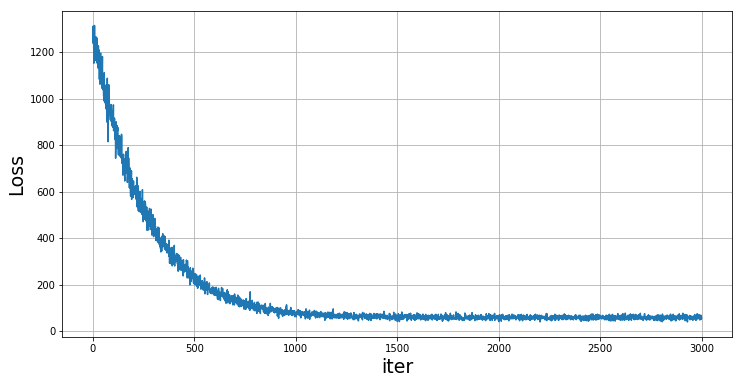

In [29]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)

Text(0.5, 0, 'iter')

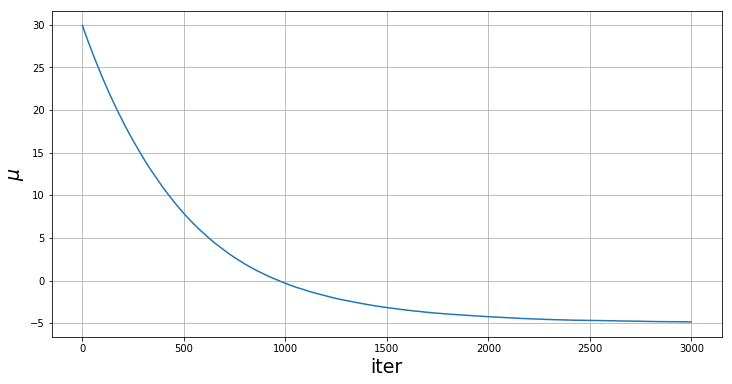

In [30]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)